# Code of the final analyses performed for the paper: 
Date created (`posthoc-cc-*`): 20 July 2022<br>
Date last updated (f`posthoc-cc2-*`): 18 Oct 2022<br>
Reran analysis with a bugfix (`posthoc-cc3-*`): 13 July 2023   | the sections having the comment `@@Milena skip` need not be rerun <br> 
Author: Roshan Rane, Milena Musial <br>

In [1]:
# standard python packages
import os, sys
from glob import glob
from os.path import join 
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.lines import Line2D
from scipy import stats

import seaborn as sns
sns.set(style="whitegrid", context='paper', color_codes=False)
sys.path.append("../MLpipelines")
from plotResults import *

import h5py
import random
import math
import json

In [2]:
rerun_ver = 'posthoc-cc3'

In [3]:
H5_DIR = "/ritter/share/data/IMAGEN/h5files/"
CONF_DATA_DIR = "/ritter/share/data/IMAGEN/posthoc/"
RESULTS_DIR = "/ritter/roshan/workspace/ML_for_IMAGEN/MLpipelines/results/"

In [4]:
H5_FILES = {
    "h5causal0" : "newlbls-clean-bl-espad-fu3-19a-binge-causal-onset0-n477.h5",
    "h5causal1" : "newlbls-clean-bl-espad-fu3-19a-binge-causal-onset1-n565.h5",
    # Take the 3 h5files used in paper
    "h5fu3" : "newlbls-clean-fu3-espad-fu3-19a-binge-n650.h5",
    "h5fu2" : "newlbls-clean-fu2-espad-fu3-19a-binge-n634.h5",
    "h5bl" : "newlbls-clean-bl-espad-fu3-19a-binge-n620.h5",
}

In [5]:
H5_FILES_HOLD = {
    "h5causal0" : "newholdout-clean-bl-espad-fu3-19a-binge-causal-onset0-n78.h5",
    "h5causal1" : "newholdout-clean-bl-espad-fu3-19a-binge-causal-onset1-n90.h5",
    # Take the 3 h5files used in paper
    "h5fu3" : "newholdout-clean-fu3-espad-fu3-19a-binge-n102.h5",
    "h5fu2" : "newholdout-clean-fu2-espad-fu3-19a-binge-n102.h5",
    "h5bl" : "newholdout-clean-bl-espad-fu3-19a-binge-n102.h5",
}

MAP_H5CAT_TO_RUN = {
    'h5causal1': RESULTS_DIR+"/newlbls-clean-bl-espad-fu3-19a-binge-causal-onset1-n565/20220726-1119/run.csv",
    'h5causal0': RESULTS_DIR+"/newlbls-clean-bl-espad-fu3-19a-binge-causal-onset0-n477/20220414-1352/run.csv",
    'h5fu3': RESULTS_DIR+"/newlbls-clean-fu3-espad-fu3-19a-binge-n650/20211026-1911/run.csv",
    'h5fu2': RESULTS_DIR+"/newlbls-clean-fu2-espad-fu3-19a-binge-n634/20210618-1701/run.csv",
    'h5bl': RESULTS_DIR+"/newlbls-clean-bl-espad-fu3-19a-binge-n620/20211026-1810/run.csv",
}

MAP_H5CAT_TO_HOLDRUN = {
    'h5causal1': RESULTS_DIR+"/holdout-causal-onset1_run.csv",
    'h5causal0': RESULTS_DIR+"/holdout-causal-onset0_run.csv",
    'h5fu3': RESULTS_DIR+"/holdout_all-tp-clean_run.csv",
    'h5fu2': RESULTS_DIR+"/holdout_all-tp-clean_run.csv",
    'h5bl': RESULTS_DIR+"/holdout_all-tp-clean_run.csv",
        }

## Useful helper functions

### H5 file inspection funcs

In [6]:
def plot_dists(h5, lbl, col_names, suptitle=''):
    
    df = pd.DataFrame({c:h5[c][()] for c in [lbl]+col_names})
    df.index = h5["i"][()]
    
    if len(df[lbl].unique())>2:
        print("lbl has more than 2 states and in range [{}, {}, {}] \n aborting distribution plots .....".format(
                df[lbl].min(), df[lbl].mean(), df[lbl].max())) 
    else:        
        f, axes = plt.subplots(1, len(col_names)+1, figsize=(4*(len(col_names)+1), 3))
        if suptitle: plt.suptitle(suptitle)

        val = dict(df[lbl].astype(int).astype('str').value_counts())
        axes[0].pie(list(val.values()), labels = list(val.keys()), autopct='%1.0f%%', shadow=True, startangle=90) 
        axes[0].axis('equal')

        for ax, c in zip(axes[1:], col_names):
            if len(df[c].unique())<=10: # then bar plot
                dfi = df[[c,lbl]].value_counts(dropna=False).unstack().sort_index()

                dfi.sort_index().plot.bar(
                    stacked=True, title=c, legend=True, 
                    alpha=0.5, sort_columns=True, 
                    grid=True, rot=90, ax=ax, width=0.9)
    #             for i, x in enumerate(dfi.values):
    #                 ax.text(i, x+(x/100)+1, str(x))

            else: # histogram
                for lbl_i, dfi in df.groupby(lbl):
                    lbl_i = int(lbl_i)
                    dfi[c].plot.hist(label="lbl="+str(lbl_i), title=c,
                                     grid=True, alpha=0.5, legend=True, bins=10, ax=ax)

        plt.legend()   
        plt.show()

def check_h5_contents(H5_FILES, ignore=''):
    
    if isinstance(H5_FILES, str): H5_FILES = [H5_FILES]
    
    for k, h5_files_glob in enumerate(H5_FILES):
        
        for h5_file in glob(h5_files_glob):
            print("______________________________________________________________________________________")
            if ignore and ignore in h5_file:
                print(f"ignoring '{h5_file}' because of the ignore str '{ignore}'")
            else:            
                with h5py.File(h5_file, 'r') as h5:
                    print("filename: {} \n h5.columns = {} \n h5.attrs = {}".format(
                        h5_file.split("/")[-1], list(h5.keys()), list(h5.attrs.keys())))

                    try:
                        n = len(h5["i"])
                        y = h5.attrs['labels'][0]
                        conf_names=h5.attrs["confs"].tolist()
                        print("n = {} \t label = {} \t X.shape = {}  \t confs = {}".format( 
                            n, y, h5["X"].shape, conf_names))

                        # plot the confs and label distributions in the data
                        print("label and conf with distributions:")
                        plot_dists(h5, y, conf_names)

                    except Exception as e:  print(e) 

                    # plot a random subject's brain image in the data 
                    random_i = random.randint(0, n-1)
                    img = h5["X"][random_i]
                    print("\nsubject: {} \t (min={:.2f}, mean={:.2f}, max={:.2f})".format(
                        h5["i"][random_i], img.min(), img.mean(), img.max()))
                    
                    for conf in  conf_names:
                        if conf not in ['sex','site']:
                            print(f"conf {conf} == label {y} ? \t True for n={np.sum(h5[conf][:]==h5[y][:])}/{n}")

In [7]:
def print_h5_for_MLpipeline(h5_dir=H5_DIR, filter_func=lambda filename: 'posthoc-cc-bl' in filename and 'causal' in filename):
    
    # print(f"  DATA_DIR + 'h5files/{ori_h5_file}',")
    for h5file in sorted(os.listdir(h5_dir)):
        if filter_func(h5file):
            print(f"  DATA_DIR + 'h5files/{h5file}',")

### attach conf to H5 files

In [8]:
# add binge itself as a conf
def attach_conf_fromseries(H5_DIR, to_h5, conf, prepend='h5causal1', print_all=True):
    
    # create a new h5 file name
    out_h5 = '-'.join([rerun_ver,prepend,conf.name])+'.h5'
    if print_all: print("writing to ..", out_h5)
    # assert not os.path.exists(H5_DIR+out_h5), "[ERROR] file already exists.. skipping h5file creation. Remove it manually first"

    try:
        with h5py.File(H5_DIR+out_h5, 'w') as data_out:
            # first just copy all h5 file data to new h5 file    
            with h5py.File(H5_DIR+to_h5, 'r') as data_dest:
                for dataset in data_dest:
                    data_out.create_dataset(dataset, data=data_dest[dataset]) 
                for attr in data_dest.attrs:
                    data_out.attrs[attr]=data_dest.attrs[attr]

            # now add the confound
            if conf.name not in data_out.attrs['confs']:

                if print_all: print(f"attaching conf {conf.name}")
                data_out.attrs['confs'] = list(data_out.attrs['confs'])+[conf.name]
                # align the subject IDs to fill the right conf value for each subject in the h5
                h5_sub_ids = data_out['i'][:]
                # below script works only if the IDs in src data h5 are arranged in an ascending order
                assert np.all(h5_sub_ids[:-1] <= h5_sub_ids[1:]), f"subject IDs in {to_h5} are not in ascending order.. change the algo below ?!"
                conf = conf.sort_index()
                h5_sub_ids_in_conf = np.argwhere(np.isin(h5_sub_ids, conf.index)).ravel()
                conf_sub_ids_in_h5 = np.argwhere(np.isin(conf.index, h5_sub_ids)).ravel()
                assert len(h5_sub_ids_in_conf)==len(conf_sub_ids_in_h5)
                data_out.create_dataset(conf.name, data=conf.iloc[conf_sub_ids_in_h5]) 

                # check if the distribution of confound is acceptable
                assert conf.iloc[conf_sub_ids_in_h5].nunique()==2, f"conf has n_classes= \
{conf.iloc[conf_sub_ids_in_h5].nunique()}. If n_classes>2 then it was not correctly\
 binarized. If n_classes=1 then all subjects are getting categorized into a single class."
                for val,counts in conf.iloc[conf_sub_ids_in_h5].value_counts().iteritems():
                    assert counts>=0.15*len(conf_sub_ids_in_h5), f"\
the value {val} in {conf.name} has fewer than 15% instances (n={counts})\
\nThis is very small for counter balancing to work properly.."

                # remove subject IDs missing the conf info
                if len(h5_sub_ids_in_conf)<len(h5_sub_ids):

                    print(f"[WARN] n={len(h5_sub_ids)-len(h5_sub_ids_in_conf)} subs missing this conf information. \
Dropping sample size from {len(h5_sub_ids)} to {len(h5_sub_ids_in_conf)}")
                    existing_datasets = list(data_out.keys())
                    existing_datasets.remove(conf.name)
                    # if print_all: print(f"Removing subjects with missing value from {existing_datasets}")
                    for existing_dataset in existing_datasets:
                        new_data = data_out[existing_dataset][h5_sub_ids_in_conf] 
                        del data_out[existing_dataset] 
                        data_out.create_dataset(existing_dataset, data=new_data) 

    except Exception as e:
        if os.path.isfile(H5_DIR+out_h5): os.remove(H5_DIR+out_h5)
        raise e

In [9]:
def attach_conf_fromh5(H5_DIR, from_h5, to_h5, print_all=True):
    
    # create a new h5 file name
    out_h5 = "-".join(from_h5.split('-')[:-1])+"-"+ "-".join(to_h5.split('-')[-4:])
    if print_all: print("writing to ..", out_h5)
    
    with h5py.File(H5_DIR+out_h5, 'w') as data_out:
        # first just copy all h5 file data to new h5 file    
        with h5py.File(H5_DIR+to_h5, 'r') as data_dest:
            for dataset in data_dest:
                data_out.create_dataset(dataset, data=data_dest[dataset]) 
            for attr in data_dest.attrs:
                data_out.attrs[attr]=data_dest.attrs[attr]
            
        # now add the confound
        with h5py.File(H5_DIR+from_h5, 'r') as data_src:
                for dataset in data_src:
                    if dataset not in data_out:
                        if print_all: print(f"attaching conf {dataset}")
                        data_out.attrs['confs'] = list(data_out.attrs['confs'])+[dataset]
                        # match subject IDs
                        src_sub_ids = data_src['i'][:]
                        out_sub_ids = data_out['i'][:]
                        # ASSUMPTION: the src_sub_ids is sorted in ascending order of IDs
                        valid_idx = np.argwhere(np.in1d(src_sub_ids, out_sub_ids)).squeeze()
                        data_out.create_dataset(dataset, data=data_src[dataset][valid_idx]) 
                        
                        if len(valid_idx)<len(out_sub_ids):
                            print(f"[WARN] only {len(valid_idx)} sub IDs were found for this conf data, out of {len(out_sub_ids)}")
                            existing_datasets = list(data_out.keys())
                            existing_datasets.remove(dataset)
                            # if print_all: print(f"Removing subjects with missing value from {existing_datasets}")
                            for existing_dataset in existing_datasets:
                                valid_idx_2 =  np.argwhere(np.in1d(out_sub_ids, src_sub_ids)).squeeze()
                                new_data = data_out[existing_dataset][valid_idx_2] 
                                del data_out[existing_dataset] 
                                data_out.create_dataset(existing_dataset, data=new_data) 
                            

### Result helper funcs

In [10]:
from scipy.stats import pearsonr

def std_dev_diff(sample1, sample2):
    # equation from https://handbook-5-1.cochrane.org/chapter_16/16_4_6_1_mean_differences.htm
    sample1_std = sample1.std()
    sample2_std = sample2.std()
    corr,_ = pearsonr(sample1, sample2)
    std_dev = (sample1_std**2 + sample2_std**2 - (2*corr*sample1_std*sample2_std))**(1/2)
    # print(std_dev, corr)
    return std_dev

def create_accuracy_csv(fil_name='', date_filter='', save_df=False):
    
    df_out = pd.DataFrame()
    # if there are multiple time points in the results then print this and chose the latest one
    resultfile_tps =  sorted(list(set(
        # extract the month and the year
        [f.split('/')[-1][:6] for f in glob(f"../MLpipelines/results/{rerun_ver}*{fil_name}*/*{date_filter}*")])))
    if len(resultfile_tps)>1: 
        print(f"[WARN] multiple result files found from timepoints (YYYYMM) : {resultfile_tps}. \
Choosing only one using the arg 'date_filter'.")
    for resultfile in glob(f"../MLpipelines/results/{rerun_ver}*{fil_name}*/*{date_filter}*/run.csv"):

        df = pd.read_csv(resultfile)    
        conf_name = list(df.o.unique())
        [conf_name.remove(remove) for remove in ['X','Binge', 'sex', 'site'] if remove in conf_name]
        assert len(conf_name)==1, conf_name+" list should have only the new confound"
        conf_name=conf_name[0]
        
        for model, dfi in df.groupby('model'):
            if 'FU3' in conf_name[:-4]:
                tp = 'FU3'
            if 'FU2' in conf_name[:-4]:
                tp = 'FU2'
            else:
                tp = 'BL'
            df_out_i = {'Confound':conf_name, 
                        'Conf_time_point':tp, 
                        'Model':model,
                        'h5name':resultfile.split('/')[-3]}
            
            if 'baseline-cb' in dfi['technique'].unique():
                dfi_bl = dfi.loc[(dfi['io'] == 'X-Binge') & (dfi['technique'] == 'baseline-cb')]
            else:
                dfi_bl = pd.read_csv(MAP_H5CAT_TO_RUN[fil_name]).groupby('model').get_group(model)
                baseline_cb = 'cb' if 'baseline-cb' not in dfi['technique'].unique() else 'baseline-cb'
                dfi_bl = dfi_bl.loc[(dfi_bl['io'] == 'X-Binge') & (dfi_bl['technique'] == baseline_cb)]                
                
            df_out_i.update({'Accuracy BL':  dfi_bl['test_score'].mean()})
            df_out_i.update({'Std-Dev BL':   dfi_bl['test_score'].std()})

            dfi_conf = dfi.loc[(dfi['io'] == 'X-Binge') & (dfi['technique'] == 'cb')]
            df_out_i.update({'Accuracy CB':   dfi_conf['test_score'].mean()})
            df_out_i.update({'Std-Dev CB':    dfi_conf['test_score'].std()})
            
            df_out_i.update({'Accuracy Diff CB - BL': (dfi_conf['test_score'].mean() - dfi_bl['test_score'].mean())})
            df_out_i.update({'Std-Dev Diff CB - BL':  std_dev_diff(dfi_conf['test_score'], dfi_bl['test_score'])})

            df_out_i = pd.DataFrame([df_out_i])
            # display(df_out_i)
            df_out = pd.concat([df_out, df_out_i], ignore_index=True)
            
    if save_df: df_out.to_csv(f"results/accuracy{fil_name}.csv", index=False)
    
    return df_out

In [11]:
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
    
def plot_accuracy_csv(df, color_cat=False, permutation_results=''):
    if isinstance(df,str): df = pd.read_csv(f'results/accuracy-{df}.csv')
    # display(df)
    
    if 'h5cat' not in df: df['h5cat'] = ''    
    
    fig, axes_i = plt.subplots(1, 2, 
                             sharex=False, sharey=True,
                             constrained_layout=True,
                             figsize=(12, round(0.4*(df['Confound']+df['h5cat']).nunique())))
    fs=12
    plt.suptitle(r" Mean balanced accuracy before ( $MBA_{pre}$ ) and after correction ( $MBA_{post}$ )"+
                 f"\n on data subset {df['h5cat'].unique()[0].replace('h5','').upper()}", fontsize=fs+2)

    df = df.loc[(df['Model'].isin(['SVM-rbf','GB']))].sort_values(
        ['Accuracy Diff CB - BL'], ascending=False)
    
    # multiply values by 100 for percent
    for col in df:
        if 'accuracy' in col.lower() or 'std' in col.lower(): 
            df[col] = df[col]*100

    # predetermine colors for each model
    colors = {m :plt.get_cmap('tab10')(i) for i,m in enumerate(sorted(df['Model'].unique()))}
    width=0.3
    offset=1.3
    
    # predetermine colors for categories
    if color_cat:
        # create a list of colors for each cat
        cat_map = df[['Confound','category']].drop_duplicates(ignore_index=True)
        cat_map = cat_map.set_index('Confound', drop=True).squeeze().to_dict()
        cats = df['category'].unique()
        cmap = plt.get_cmap('Pastel2')
        cat_to_color = {c:cmap(i) for i,c in enumerate(cats)}

    # 1) plot absolute accuracies on X axis - before correction  
    for i, (model, df_i) in enumerate(df.groupby('Model')): 
        diff_style_args = dict(color=colors[model][:-1]+(0.2,), 
                               edgecolor=colors[model][:-1]+(1.,)) 
        # print('[D]Abs (before)',h5cat, model, len(df_i))
        df_i.plot(kind='barh',
            y="Accuracy BL", x='Confound', 
            # xerr="Std-Dev BL",
            width=width, position=offset*i, label=None, 
            ax=axes_i[0],
            **diff_style_args)
    # add patch lines
    for bar in axes_i[0].patches:
        bar.set_hatch('\\\\\\\\')

    # 2) plot absolute accuracies on X axis - after correction 
    for i, (model, df_i) in enumerate(df.groupby('Model')): 
        # print('[D]Abs (after)',h5cat, model, len(df_i))
        df_i.plot(kind='barh',
            y="Accuracy CB", x='Confound', 
            xerr="Std-Dev CB",
            width=width, position=offset*i, label=model, 
            ax=axes_i[0],
            color=colors[model], alpha=1)
    
    # 3) add permuted result lines on axis 0 if requested
    if permutation_results:
        with open(permutation_results, 'r') as f:
            perm_scores = np.array(json.load(f)['SVM-rbf']['random_scores'])
            for std_scale, ls in [(-2,'dotted'),(-0.6744898,'dashed'),(0,'solid'),(0.6744898,'dashed'),(2,'dotted')]:
                axes_i[0].axvline(100*(np.mean(perm_scores) + std_scale*np.std(perm_scores)), 
                                  color='grey', lw=2, ls=ls)      
    # @here
     # 4) plot decrease/difference in accuracy on X axis
    for i, (model, df_i) in enumerate(df.groupby('Model')):  
        # print('[D]Diff',h5cat, model, len(df_i))
        diff_style_args = dict(color=colors[model][:-1]+(0.2,), 
                               edgecolor=colors[model][:-1]+(1.,)) 
        df_i.plot(kind='barh',
            y="Accuracy Diff CB - BL", x='Confound',  sort_columns=True,
            xerr="Std-Dev Diff CB - BL",
            width=width, position=offset*i, label=model, 
            ax=axes_i[1], 
            **diff_style_args)
    # add patch lines
    for bar in axes_i[1].patches:
        bar.set_hatch('\\\\\\\\')   
    
    # 5) beautify: annotate scores beside the bars in axis 1 
    for p in axes_i[1].patches:
        offset = -2 if p.get_width()<0 else 0.5
        axes_i[1].annotate(format(p.get_width(), '.1f')+'%', 
                           (p.get_width()+offset, p.get_y()))
    
    axes_i[1].axvline(0, color='k', ls='--')
   
     # 5) beautify: add category as a background color of the y-labels 
    if color_cat:
        # set y tick colors based on category
        for ticklabel in axes_i[0].get_yticklabels():
            ticklabel.set_backgroundcolor(cat_to_color[cat_map[ticklabel.get_text()]])

     # 5) beautify: Legends
    hdls, lbls = axes_i[0].get_legend_handles_labels()
    axes_i[0].get_legend().remove()
    if permutation_results:
        hdls2 = [Line2D([0], [0], color='gray', lw=2, ls='dashed'),
                 Line2D([0], [0], color='gray', lw=2, ls='dotted')]
        lbls2 = ["50% interval", "95% interval"]
        axes_i[0].legend(hdls2, lbls2,
                   fontsize=fs-1, loc='upper right')
                         
            
    # Also add label category as colors
    for cat,color in cat_to_color.items():
        lbls.append(cat)
        hdls.append(Patch(facecolor=color, edgecolor='k',
                         label=cat))
    
    axes_i[1].legend(hdls,
                   [
                    r'$MBA_{pre}$',
                    r'$MBA_{post}$', 
                    # lbls[2]+' (after \ncorrection)', ## @remove GB
                    # lbls[3]+'\n(after \ncorrection)',  ## @remove GB
                    *lbls[2:]],
                   fontsize=fs-1, loc='upper right')
    
    # 5) beautify: axis names and so on
    axes_i[0].set_title(f'Absolute accuracy (%)', fontsize=fs)
    axes_i[0].set_xlabel(f'Absolute accuracy (%)', fontsize=fs)
    axes_i[0].set_xlim([48,80])
    axes_i[1].set_title(f'(%) reduction in accuracy', fontsize=fs)
    axes_i[1].set_xlabel(f'(%) reduction in accuracy', fontsize=fs)
    axes_i[1].set_xlim([-10,10])
    axes_i[0].grid(False)
    axes_i[1].grid(False)

In [12]:
# For preprocessing confounds from raw tables
RAW_Q_DIR = '/ritter/share/data/IMAGEN/IMAGEN_RAW/2.7'

def get_col_raw_df(loc, df_confs):
    row = df_confs.loc[loc]
    tp, quest, formula = row[['time_point','raw questionnaire','score computation']]
    if 'dawba' in quest.lower():
        df_raw = pd.read_csv((RAW_Q_DIR+quest), sep='\t', index_col=False)
        # convert PSC2 code to subject ID 
        df_raw = df_raw.set_index('PSC2')
    else:
        df_raw = pd.read_csv((RAW_Q_DIR+quest))
        # convert user code to subject ID 
        df_raw.index = df_raw['User code'].astype(str).apply(lambda x: int(x.replace("-C", "").replace("-I", "").replace("-P", "")))
        
    df_raw.index.name = 'ID'
    return df_raw, tp, quest, formula

## Analysis 0: prepare missing covariate data
Prepare `all_*.csv` files for confounds that are missing this info. <br>
Extract all_* tables from raw tables.  <br>
Some confound information need to be extracted from the tables provided by IMAGEN.

In [12]:
df_confs = pd.read_excel("Confounds_list_Milena.xlsx")
print("Rows that need to be preprocessed n =", len(df_confs.dropna(subset=['raw questionnaire'])))
# df_confs.dropna(subset=['raw questionnaire'])[['time_point','raw questionnaire', 'score computation']]

Rows that need to be preprocessed n = 45


In [36]:
# check if all of them exist and have valid subject ID columns 
for i, row in df_confs.dropna(subset=['raw questionnaire']).iterrows():
    print(i, row['time_point'], row['raw questionnaire'])
    try:
        df_raw, tp, quest, formula = get_col_raw_df(i)
        # print(row['score computation'])
        # display(df_raw)
    except Exception as E:
        print(f'[ERROR {E.__class__.__name__}]', E)

30 BL /BL/psytools/IMAGEN-IMGN_PDS_RC5-IMAGEN_DIGEST.csv
31 BL /BL/psytools/IMAGEN-IMGN_ESPAD_CHILD_RC5-IMAGEN_DIGEST.csv
32 BL /BL/dawba/IMAGEN_dawba_BL.tsv


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  """


33 BL /BL/psytools/IMAGEN-IMGN_TLFB_RC5-BASIC_DIGEST.csv
34 BL /BL/psytools/IMAGEN-IMGN_ESPAD_CHILD_RC5-IMAGEN_DIGEST.csv
47 FU3 /FU3/psytools/IMAGEN-IMGN_ESPAD_FU3.csv


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DtypeWarning: Columns (104,107,183,184,194,269,274,360,363,370,372,443,450,520,530,904,907) have mixed types.Specify dtype option on import or set low_memory=False.
  """


48 FU3 /FU3/psytools/IMAGEN-IMGN_TLFB_FU3-IMAGEN_DIGEST.csv
49 FU3 /FU3/psytools/IMAGEN-IMGN_ESPAD_FU3.csv
50 FU3 /FU3/psytools/IMAGEN-IMGN_ESPAD_FU3.csv
51 FU3 /FU3/psytools/IMAGEN-IMGN_ESPAD_FU3.csv
52 FU3 /FU3/psytools/IMAGEN-IMGN_ESPAD_FU3.csv
53 FU3 /FU3/psytools/IMAGEN-IMGN_ESPAD_FU3.csv
54 FU3 /FU3/psytools/IMAGEN-IMGN_CSI_FU3.csv
55 FU3 /FU3/psytools/IMAGEN-IMGN_IRI_FU3.csv
56 FU3 /FU3/psytools/IMAGEN-IMGN_RRS_FU3.csv
57 FU3 /FU3/psytools/IMAGEN-IMGN_VIDGAME_FU3.csv
58 FU3 /FU3/psytools/IMAGEN-IMGN_EDEQ_FU3.csv
59 FU3 /FU3/psytools/IMAGEN-IMGN_EDEQ_FU3.csv
60 FU3 /FU3/psytools/IMAGEN-IMGN_EDEQ_FU3.csv
61 FU3 /FU3/psytools/IMAGEN-IMGN_EDEQ_FU3.csv
62 FU3 /FU3/psytools/IMAGEN-IMGN_TFEQ_FU3.csv
63 FU3 /FU3/psytools/IMAGEN-IMGN_TFEQ_FU3.csv
64 FU3 /FU3/psytools/IMAGEN-IMGN_TFEQ_FU3.csv
68 FU3 /FU3/psytools/IMAGEN-IMGN_URBANICITY_FU3.csv
71 FU3 /FU3/psytools/IMAGEN-IMGN_WHO5_FU3.csv
84 FU3 /FU3/psytools/IMAGEN-IMGN_HF_FU3.csv
85 FU3 /FU3/psytools/IMAGEN-IMGN_HRQOL_FU3.csv
86 FU3 /FU

##### all_PDS 
30 BL /BL/psytools/IMAGEN-IMGN_PDS_RC5-IMAGEN_DIGEST.csv

In [266]:
#read the raw data
df_raw, tp, quest, formula = get_col_raw_df(30)
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2208 entries, 1274 to 99954902
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   User code            2208 non-null   object 
 1   Iteration            2208 non-null   int64  
 2   Language             2206 non-null   object 
 3   Completed            2208 non-null   object 
 4   Completed Timestamp  2208 non-null   object 
 5   Processed Timestamp  2208 non-null   object 
 6   Valid                2208 non-null   object 
 7   a10_f                1129 non-null   float64
 8   a10_m                1079 non-null   float64
 9   a11_f                1129 non-null   float64
 10  a11_m                1079 non-null   float64
 11  a12_m                1079 non-null   float64
 12  a12a_f               1129 non-null   float64
 13  a12b_f               1007 non-null   float64
 14  a13_f                1129 non-null   float64
 15  a13_m                1079 non-n

In [267]:
columns = sorted('a8_f + a9_f + a10_f + a11_f + a12a_f + a13_f + a8_m + a9_m + a10_m + a11_m + a12_m + a13_m'.split(' + '))
columns
# @Milena some column names are like 'a12a_m' do not exist. I will sum all columns starting with 'a'
# --> right, there's no item a12a_m (m stands for for male). Corrected it in the line above. 

['a10_f',
 'a10_m',
 'a11_f',
 'a11_m',
 'a12a_f',
 'a12a_m',
 'a13_f',
 'a13_m',
 'a8_f',
 'a8_m',
 'a9_f',
 'a9_m']

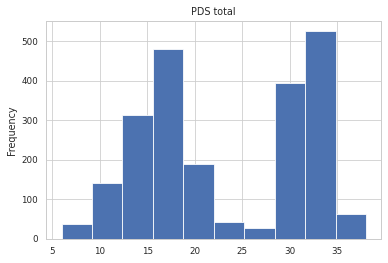

In [268]:
df_raw = df_raw.filter(regex='^a')
# correcting recode values a12a_f: 0 = 1, 1 = 4 @Milena what about a12b_f
# --> a12b_f is an age variable (and is not consodered in sum score computation), no need to recode 
df_raw.loc[:,'a12a_f'] = df_raw['a12a_f'].map({0:1,1:4})
# filling NaNs with 0 @Milena
df_raw = df_raw.fillna(0)
df_out = df_raw.sum(axis=1)
df_out.plot.hist(title='PDS total')
plt.show() #@Milena looks bimodal - might the total be different for differnt sex? Ex: Females have higher scores?
# --> yes, that's the most likely explanation as e.g. females start puberty earlier on average

In [269]:
# prepare the all_PDS.csv
df_out.name = 'PDS Sum'
df_out = df_out.to_frame()
df_out['Session']=tp
df_out

PDS Sum Session
ID                       
1274         16.0      BL
22453        14.0      BL
75717        18.0      BL
106601       15.0      BL
106871       31.0      BL
...           ...     ...
99873252     31.0      BL
99875982     32.0      BL
99888850     12.0      BL
99930021     34.0      BL
99954902     18.0      BL

[2208 rows x 2 columns]

In [270]:
# save as all_PDS.csv
df_out.to_csv(CONF_DATA_DIR + "all_PDS.csv")

##### all_ESPAD
* 31 /BL/psytools/IMAGEN-IMGN_ESPAD_CHILD_RC5-IMAGEN_DIGEST.csv
* 34 /BL/psytools/IMAGEN-IMGN_ESPAD_CHILD_RC5-IMAGEN_DIGEST.csv
* 47 FU3 /FU3/psytools/IMAGEN-IMGN_ESPAD_FU3.csv

In [549]:
df_raw, tp, quest, formula = get_col_raw_df(31)
quest, formula

('/BL/psytools/IMAGEN-IMGN_ESPAD_CHILD_RC5-IMAGEN_DIGEST.csv',
 "sum score 'bully': bully05 + bully06 + bully07 + bully08 + bully11 + bully12; sum score 'victim': bully01 + bully02 + bully03 + bully04 + bully09 + bully10")

In [550]:
_, tp2, quest2, formula2 = get_col_raw_df(34)
assert tp==tp2 and quest==quest2
formula2

"use item 6 as measure for smoking: 'On how many occasions during your lifetime have you smoked cigarettes?'"

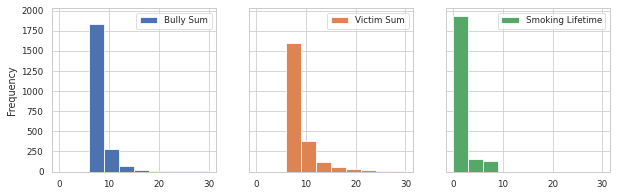

In [551]:
bully_cols = 'bully05 + bully06 + bully07 + bully08 + bully11 + bully12'.split(' + ')
victim_cols = 'bully01 + bully02 + bully03 + bully04 + bully09 + bully10'.split(' + ')

df_out = df_raw[bully_cols].sum(1)
df_out.name = 'Bully Sum'
df_out = df_out.to_frame()
df_out['Victim Sum'] = df_raw[victim_cols].sum(1)
df_out['Smoking Lifetime'] = df_raw['6']

df_out.plot.hist(subplots=True, sharey=True, layout=(1,3), figsize=(10,3))
plt.show() # @Milena 
# --> makes sense, as lowest score per bully item is 1

In [552]:
df_out['Session'] = tp
df_out

Bully Sum  Victim Sum  Smoking Lifetime Session
ID                                                       
1274              6          11                 0      BL
22453             7          10                 6      BL
75717             8           8                 6      BL
106601            6           8                 0      BL
106871            6           8                 0      BL
...             ...         ...               ...     ...
99873252          6           6                 2      BL
99875982          8           9                 0      BL
99888850          6           6                 0      BL
99930021          6           6                 0      BL
99954902          6           8                 0      BL

[2217 rows x 4 columns]

/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DtypeWarning: Columns (104,107,183,184,194,269,274,360,363,370,372,443,450,520,530,904,907) have mixed types.Specify dtype option on import or set low_memory=False.
  


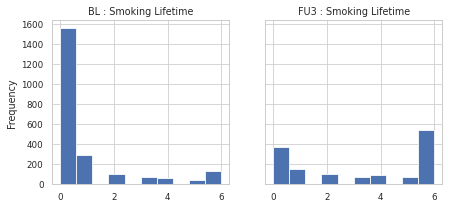

In [553]:
# add the FU3 smoking data
df_raw, tp, quest, formula = get_col_raw_df(47)
df_out2 = df_raw['6']
df_out2.name = 'Smoking Lifetime'
df_out2 = df_out2.to_frame()
df_out2['Session'] = tp
# print(len(df_out2))
df_out = df_out.append(df_out2)
# how did smoking behavior change from BL to FU3?
f, axes = plt.subplots(1,2, sharex=True, sharey=True, figsize=(7,3))
for i, (session,g) in enumerate(df_out.groupby('Session')):
    g['Smoking Lifetime'].plot.hist(title=session+' : Smoking Lifetime', ax=axes[i])
plt.show()

In [554]:
df_out.to_csv(CONF_DATA_DIR+"all_ESPAD.csv")

##### all_ESPAD_Alc
* 49 FU3 /FU3/psytools/IMAGEN-IMGN_ESPAD_FU3.csv
* 50 FU3 /FU3/psytools/IMAGEN-IMGN_ESPAD_FU3.csv
* 51 FU3 /FU3/psytools/IMAGEN-IMGN_ESPAD_FU3.csv
* 52 FU3 /FU3/psytools/IMAGEN-IMGN_ESPAD_FU3.csv
* 53 FU3 /FU3/psytools/IMAGEN-IMGN_ESPAD_FU3.csv

In [354]:
#read the raw data
formulas=[]
for i, loc in enumerate([49,50,51,52,53]):
    df_raw, tp, quest, formula = get_col_raw_df(loc)
    if i>0:assert tp_old==tp and quest_old==quest
    formulas.append(formula)
    tp_old=tp
    quest_old=quest
    print(loc, quest, formula)

/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DtypeWarning: Columns (104,107,183,184,194,269,274,360,363,370,372,443,450,520,530,904,907) have mixed types.Specify dtype option on import or set low_memory=False.
  after removing the cwd from sys.path.


49 /FU3/psytools/IMAGEN-IMGN_ESPAD_FU3.csv sum score = dmq03, dmq05, dmq11, dmq14, dmq16
50 /FU3/psytools/IMAGEN-IMGN_ESPAD_FU3.csv sum score = dmq01, dmq04, dmq06, dmq15, dmq17
51 /FU3/psytools/IMAGEN-IMGN_ESPAD_FU3.csv sum score = dmq07, dmq09, dmq10, dmq13, dmq18
52 /FU3/psytools/IMAGEN-IMGN_ESPAD_FU3.csv sum score = dmq02, dmq08, dmq12, dmq19, dmq20
53 /FU3/psytools/IMAGEN-IMGN_ESPAD_FU3.csv sum score = rapi01 + rapi02 + rapi03 + rapi04 + rapi05 + rapi06 + rapi07
+ rapi08 + rapi09 + rapi10 + rapi11 + rapi12 + rapi13 + rapi14 + rapi15 + rapi16 + rapi17 + rapi18 + rapi19 + rapi20 + rapi21 + rapi22 + rapi23


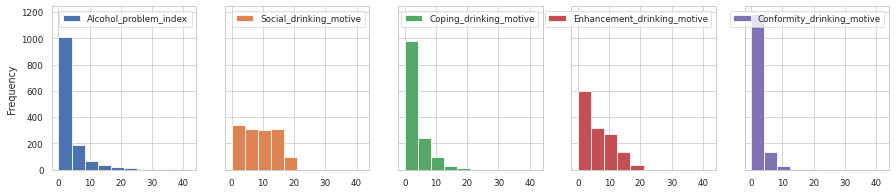

In [355]:
# prepare Alcohol_problem_index first
df_raw_rapi = df_raw["rapi01 + rapi02 + rapi03 + rapi04 + rapi05 + rapi06 + \
rapi07 + rapi08 + rapi09 + rapi10 + rapi11 + rapi12 + rapi13 + rapi14 + \
rapi15 + rapi16 + rapi17 + rapi18 + rapi19 + rapi20 + rapi21 + rapi22 + rapi23".split(' + ')]
df_raw_rapi = df_raw_rapi.fillna(0) #@Milena --> correct
df_out = df_raw_rapi.sum(1)
df_out.name = 'Alcohol_problem_index'
df_out = df_out.to_frame()

# now the remaining 4
other_cols = [
("Social_drinking_motive", 'dmq03, dmq05, dmq11, dmq14, dmq16'.split(', ')),
("Coping_drinking_motive", 'dmq01, dmq04, dmq06, dmq15, dmq17'.split(', ')),
("Enhancement_drinking_motive", 'dmq07, dmq09, dmq10, dmq13, dmq18'.split(', ')),
("Conformity_drinking_motive", 'dmq02, dmq08, dmq12, dmq19, dmq20'.split(', ')), 
]

for colname, cols in other_cols:
    df_raw_i = df_raw[cols]
    df_raw_i = df_raw_i.fillna(0) #@Milena --> correct
    df_out[colname] = df_raw_i.sum(1)
    
df_out.plot.hist(subplots=True, sharey=True, layout=(1,5), figsize=(15,3))
plt.show() # @Milena --> very skewed distributions, but makes sense as participants indicate mostly low alcohol problems (RAPI)
# and we see a plausible difference btw drinking motives (mostly social and enhancement, less coping and conformity, which might also be a social desirability effect)

In [356]:
df_out['Session'] = tp
df_out

Alcohol_problem_index  Social_drinking_motive  \
ID                                                        
112288                      3.0                     6.0   
215284                      1.0                     6.0   
240546                      1.0                    10.0   
297685                      4.0                     5.0   
308867                      0.0                    11.0   
...                         ...                     ...   
99677574                    0.0                     0.0   
99873252                    6.0                     9.0   
99875982                    3.0                     1.0   
99930021                    0.0                     0.0   
99954902                    4.0                     6.0   

          Coping_drinking_motive  Enhancement_drinking_motive  \
ID                                                              
112288                       0.0                          8.0   
215284                       1.0                          0.0   
240546                       1.0                          7.0   
297685                       1.0                          3.0   
308867                       1.0                          1.0   
...                          ...                          ...   
99677574                     0.0                          0.0   
99873252                     2.0                          7.0   
99875982                     0.0                          0.0   
99930021                     0.0                          0.0   
99954902                     1.0                          4.0   

          Conformity_drinking_motive Session  
ID                                            
112288                           0.0     FU3  
215284                           0.0     FU3  
240546                           1.0     FU3  
297685                           1.0     FU3  
308867                           0.0     FU3  
...                              ...     ...  
99677574                         0.0     FU3  
99873252                         0.0     FU3  
99875982                         0.0     FU3  
99930021                         0.0     FU3  
99954902                         2.0     FU3  

[1351 rows x 6 columns]

In [357]:
df_old = pd.read_csv(CONF_DATA_DIR+'all_ESPAD_Alc.csv')
df_out = pd.merge(df_old, df_out.reset_index(), on=['ID','Session'], how='outer')
df_out.set_index('ID').to_csv(CONF_DATA_DIR+'all_ESPAD_Alc.csv')

##### all_Eating
* 58 FU3 /FU3/psytools/IMAGEN-IMGN_EDEQ_FU3.csv
* 59 FU3 /FU3/psytools/IMAGEN-IMGN_EDEQ_FU3.csv
* 60 FU3 /FU3/psytools/IMAGEN-IMGN_EDEQ_FU3.csv
* 61 FU3 /FU3/psytools/IMAGEN-IMGN_EDEQ_FU3.csv
* 62 FU3 /FU3/psytools/IMAGEN-IMGN_TFEQ_FU3.csv
* 63 FU3 /FU3/psytools/IMAGEN-IMGN_TFEQ_FU3.csv
* 64 FU3 /FU3/psytools/IMAGEN-IMGN_TFEQ_FU3.csv

In [400]:
#read the raw data of EDEQ first
formulas=[]
for i, loc in enumerate([58,59,60,61]):
    df_raw, tp, quest, formula = get_col_raw_df(loc)
    if i>0:assert tp_old==tp and quest_old==quest
    formulas.append(formula)
    tp_old=tp
    quest_old=quest
    print(loc, quest, formula)

58 /FU3/psytools/IMAGEN-IMGN_EDEQ_FU3.csv mean score = sum(EDEQ_1, EDEQ_2, EDEQ_3, EDEQ_4, EDEQ_5)/5
59 /FU3/psytools/IMAGEN-IMGN_EDEQ_FU3.csv mean score = sum(EDEQ_7, EDEQ_9, EDEQ_19, EDEQ_21, EDEQ_20)/5
60 /FU3/psytools/IMAGEN-IMGN_EDEQ_FU3.csv mean score = sum(EDEQ_6, EDEQ_8, EDEQ_23, EDEQ_10,
EDEQ_26, EDEQ_27, EDEQ_28, EDEQ_11)/8
61 /FU3/psytools/IMAGEN-IMGN_EDEQ_FU3.csv mean score = sum(EDEQ_22, EDEQ_24, EDEQ_8, EDEQ_25, EDEQ_12)/5


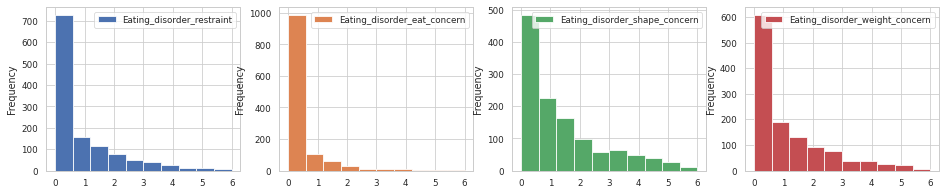

In [401]:
# prepare Eating_disorder_restraint first
df_raw_i = df_raw["EDEQ_1, EDEQ_2, EDEQ_3, EDEQ_4, EDEQ_5".split(', ')]
df_out = df_raw_i.mean(1)
df_out.name = 'Eating_disorder_restraint'
df_out = df_out.to_frame()
df_out

# now the remaining 3
other_cols = [
("Eating_disorder_eat_concern", 'EDEQ_7, EDEQ_9, EDEQ_19, EDEQ_21, EDEQ_20'.split(', ')),
("Eating_disorder_shape_concern", 'EDEQ_6, EDEQ_8, EDEQ_23, EDEQ_10, EDEQ_26, EDEQ_27, EDEQ_28, EDEQ_11'.split(', ')),
("Eating_disorder_weight_concern", 'EDEQ_22, EDEQ_24, EDEQ_8, EDEQ_25, EDEQ_12'.split(', '))
]

for colname, cols in other_cols:
    df_raw_i = df_raw[cols]
    df_raw_i = df_raw_i.fillna(0) #@Milena --> correct
    df_out[colname] = df_raw_i.mean(1)
    
df_out.plot.hist(subplots=True,  layout=(1,len(other_cols)+1), figsize=(4*len(other_cols)+4,3))
plt.show() # @Milena --> plausible, as many people don't experience eating disorder related symptoms

In [402]:
#read the raw data of TFEQ first
formulas2=[]
for i, loc in enumerate([62,63,64]):
    df_raw2, tp, quest2, formula = get_col_raw_df(loc)
    if i>0:assert tp_old==tp and quest_old2==quest2
    formulas2.append(formula)
    tp_old=tp
    quest_old2=quest2
    print(loc, quest2, formula)

62 /FU3/psytools/IMAGEN-IMGN_TFEQ_FU3.csv transformed sum score = [sum(TFEQ_2, TFEQ_11, TFEQ_12, TFEQ_15,
TFEQ_16,TFEQ_18) - 6] / 24 * 100
63 /FU3/psytools/IMAGEN-IMGN_TFEQ_FU3.csv transformed sum score = [sum(TFEQ_1, TFEQ_4, TFEQ_5, TFEQ_7,
TFEQ_8, TFEQ_9, TFEQ_13, TFEQ_14, TFEQ_17) - 9] / 36 * 100
64 /FU3/psytools/IMAGEN-IMGN_TFEQ_FU3.csv transformed sum score = [sum(TFEQ_3, TFEQ_6, TFEQ_10) - 3] / 12 * 100


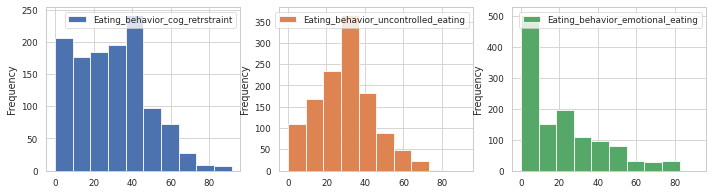

In [410]:
other_cols2 = [
("Eating_behavior_cog_retrstraint", 'TFEQ_2, TFEQ_11, TFEQ_12, TFEQ_15, TFEQ_16, TFEQ_18'.split(', ')),
("Eating_behavior_uncontrolled_eating", 'TFEQ_1, TFEQ_4, TFEQ_5, TFEQ_7, TFEQ_8, TFEQ_9, TFEQ_13, TFEQ_14, TFEQ_17'.split(', ')),
("Eating_behavior_emotional_eating", 'TFEQ_3, TFEQ_6, TFEQ_10'.split(', '))
]

for colname, cols in other_cols2:
    df_raw_i = df_raw2[cols]
    df_raw_i = df_raw_i.fillna(0) #@Milena --> correct; item 18 has to be recoded (from a scale of 8 to a scale of 4), I inserted the code below, is that correct?
    df_raw_i.loc[:,'TFEQ_18'] = df_raw_i['TFEQ_18'].map({1:1,2:1,3:2,4:2,5:3,6:3,7:4,8:4})
    
    df_out[colname] = 100*(df_raw_i.sum(1)-len(cols))/(4*len(cols))
    
df_out[list(list(zip(*other_cols2))[0])].plot.hist(subplots=True, layout=(1,len(other_cols2)+1), figsize=(4*len(other_cols)+4,3))
plt.show() # @Milena --> plausible, as transformed to a scale from 0 - 100

In [411]:
df_out['Session'] = tp
df_out

Eating_disorder_restraint  Eating_disorder_eat_concern  \
ID                                                                 
112288                          0.0                          0.0   
215284                          1.6                          1.0   
240546                          0.4                          0.0   
297685                          1.8                          0.2   
308867                          0.0                          0.0   
...                             ...                          ...   
99616225                        2.8                          0.4   
99677574                        0.0                          0.0   
99873252                        1.6                          0.0   
99875982                        0.0                          0.0   
99954902                        0.0                          0.0   

          Eating_disorder_shape_concern  Eating_disorder_weight_concern  \
ID                                                                        
112288                            0.000                             0.8   
215284                            5.125                             4.0   
240546                            1.375                             0.8   
297685                            1.625                             0.4   
308867                            0.125                             0.2   
...                                 ...                             ...   
99616225                          3.625                             3.4   
99677574                          0.250                             0.0   
99873252                          1.500                             1.8   
99875982                          1.250                             1.0   
99954902                          0.625                             1.2   

          Eating_behavior_cog_retrstraint  \
ID                                          
112288                           0.000000   
215284                          50.000000   
240546                          37.500000   
297685                          29.166667   
308867                          41.666667   
...                                   ...   
99616225                        54.166667   
99677574                        12.500000   
99873252                        29.166667   
99875982                         8.333333   
99954902                        41.666667   

          Eating_behavior_uncontrolled_eating  \
ID                                              
112288                              55.555556   
215284                              27.777778   
240546                              36.111111   
297685                              30.555556   
308867                               8.333333   
...                                       ...   
99616225                             2.777778   
99677574                            22.222222   
99873252                            16.666667   
99875982                            11.111111   
99954902                            16.666667   

          Eating_behavior_emotional_eating Session  
ID                                                  
112288                            0.000000     FU3  
215284                           58.333333     FU3  
240546                           50.000000     FU3  
297685                           50.000000     FU3  
308867                            0.000000     FU3  
...                                    ...     ...  
99616225                          0.000000     FU3  
99677574                          8.333333     FU3  
99873252                          8.333333     FU3  
99875982                         16.666667     FU3  
99954902                          0.000000     FU3  

[1216 rows x 8 columns]

In [412]:
df_out.to_csv(CONF_DATA_DIR+'all_Eating.csv')

##### all_QOL
* 85 FU3 /FU3/psytools/IMAGEN-IMGN_HRQOL_FU3.csv
* 86 FU3 /FU3/psytools/IMAGEN-IMGN_HRQOL_FU3.csv
* 87 FU3 /FU3/psytools/IMAGEN-IMGN_HRQOL_FU3.csv
* 88 FU3 /FU3/psytools/IMAGEN-IMGN_HRQOL_FU3.csv

In [416]:
#read the raw data
formulas=[]
for i, loc in enumerate([85,86,87,88]):
    df_raw, tp, quest, formula = get_col_raw_df(loc)
    if i>0:assert tp_old==tp and quest_old==quest
    formulas.append(formula)
    tp_old=tp
    quest_old=quest
    print(loc, quest, formula)

85 /FU3/psytools/IMAGEN-IMGN_HRQOL_FU3.csv HRQOL_HDCM_1
86 /FU3/psytools/IMAGEN-IMGN_HRQOL_FU3.csv HRQOL_HDCM_2
87 /FU3/psytools/IMAGEN-IMGN_HRQOL_FU3.csv HRQOL_HDCM_3
88 /FU3/psytools/IMAGEN-IMGN_HRQOL_FU3.csv HRQOL_HDCM_4


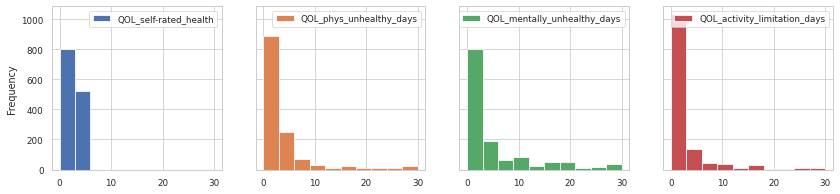

In [423]:
# prepare QOL_self-rated_health first
df_raw_i = df_raw["HRQOL_HDCM_1"]
df_raw_i.name = 'QOL_self-rated_health'
df_out = df_raw_i.to_frame()

# now the remaining 4
other_cols = [
("QOL_phys_unhealthy_days", 'HRQOL_HDCM_2'),
("QOL_mentally_unhealthy_days", 'HRQOL_HDCM_3'),
("QOL_activity_limitation_days", 'HRQOL_HDCM_4'),
]

for colname, cols in other_cols:
    df_out[colname] = df_raw[cols]
    
df_out.plot.hist(subplots=True, sharey=True, layout=(1,len(other_cols)+1), figsize=(4*len(other_cols)+2,3))
plt.show() # @Milena --> the last three plots are plausible, as they refer to a max of 30 days per month. 
# The first variable is, however, measured on a scale from 1 (excellent health) to 5 (poor health). So the x-axis 
# limits should be chosen differently for the plot. But the values range itself looks plausible.

In [424]:
df_out['Session'] = tp
df_out

QOL_self-rated_health  QOL_phys_unhealthy_days  \
ID                                                         
112288                        1                        0   
215284                        5                       25   
240546                        1                        0   
297685                        2                        3   
308867                        2                        0   
...                         ...                      ...   
99677574                      2                        2   
99873252                      2                        1   
99875982                      2                        0   
99930021                      3                       15   
99954902                      2                       10   

          QOL_mentally_unhealthy_days  QOL_activity_limitation_days Session  
ID                                                                           
112288                              0                             0     FU3  
215284                              7                             4     FU3  
240546                              0                             0     FU3  
297685                              2                             2     FU3  
308867                              0                             0     FU3  
...                               ...                           ...     ...  
99677574                            0                             2     FU3  
99873252                            1                             0     FU3  
99875982                            0                             0     FU3  
99930021                            2                             8     FU3  
99954902                            6                             0     FU3  

[1324 rows x 5 columns]

In [425]:
df_out.to_csv(CONF_DATA_DIR+'all_QOL.csv')

##### all_CTS
* 111 BL /BL/psytools/IMAGEN-IMGN_CTS_PARENT_RC5-BASIC_DIGEST.csv
* 112 BL /BL/psytools/IMAGEN-IMGN_CTS_PARENT_RC5-BASIC_DIGEST.csv
* 113 BL /BL/psytools/IMAGEN-IMGN_CTS_PARENT_RC5-BASIC_DIGEST.csv
* 114 BL /BL/psytools/IMAGEN-IMGN_CTS_PARENT_RC5-BASIC_DIGEST.csv
* 115 BL /BL/psytools/IMAGEN-IMGN_CTS_PARENT_RC5-BASIC_DIGEST.csv

In [37]:
#read the raw data
formulas=[]
for i, loc in enumerate([111,112,113,114,115]):
    df_raw, tp, quest, formula = get_col_raw_df(loc)
    print(loc, quest, formula)
    if i>0:assert tp_old==tp and quest_old==quest
    formulas.append(formula)
    tp_old=tp
    quest_old=quest


111 /BL/psytools/IMAGEN-IMGN_CTS_PARENT_RC5-BASIC_DIGEST.csv cts_assault
112 /BL/psytools/IMAGEN-IMGN_CTS_PARENT_RC5-BASIC_DIGEST.csv cts_injury
113 /BL/psytools/IMAGEN-IMGN_CTS_PARENT_RC5-BASIC_DIGEST.csv cts_negotiation
114 /BL/psytools/IMAGEN-IMGN_CTS_PARENT_RC5-BASIC_DIGEST.csv cts_psychological_aggression
115 /BL/psytools/IMAGEN-IMGN_CTS_PARENT_RC5-BASIC_DIGEST.csv cts_secual_coercion


In [38]:
df_raw_i = df_raw["cts_assault"]
df_raw_i.name = 'Parent Assault Mean'
df_out = df_raw_i.to_frame()
# df_out.info()

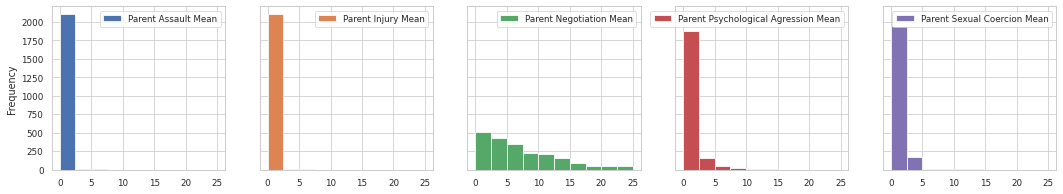

In [39]:
# now the remaining 4
other_cols = [
('Parent Injury Mean', 'cts_injury'),
('Parent Negotiation Mean', 'cts_negotiation'),
('Parent Psychological Agression Mean', 'cts_psychological_aggression'),
('Parent Sexual Coercion Mean', 'cts_sexual_coercion'),
]

for colname, cols in other_cols:
    df_out[colname] = df_raw[cols]
    
df_out.plot.hist(subplots=True, sharey=True, sharex=False, layout=(1,len(other_cols)+1), figsize=(4*len(other_cols)+2,3))
plt.show() # @Milena --> plausible, as values represent means on a scale from 0 - 25 and certain types of behavior are very rare

In [40]:
df_out['Session'] = tp
df_out

Parent Assault Mean  Parent Injury Mean  Parent Negotiation Mean  \
ID                                                                           
1274                      0.0                 0.0                 4.500000   
22453                     0.0                 0.0                22.166667   
75717                     0.6                 0.0                 9.416667   
106601                    0.0                 0.0                 0.583333   
106871                    0.0                 0.0                 1.500000   
...                       ...                 ...                      ...   
99873252                  0.0                 0.0                 8.333333   
99875982                  0.0                 0.0                 4.916667   
99888850                  0.0                 0.0                 1.500000   
99930021                  0.0                 0.0                 3.833333   
99954902                  0.0                 0.0                10.583333   

          Parent Psychological Agression Mean  Parent Sexual Coercion Mean  \
ID                                                                           
1274                                    0.875                     0.000000   
22453                                   3.625                     4.166667   
75717                                  10.000                     0.000000   
106601                                  0.125                     0.000000   
106871                                  0.500                     0.000000   
...                                       ...                          ...   
99873252                                0.250                     0.000000   
99875982                                0.250                     0.000000   
99888850                                0.000                     0.000000   
99930021                                0.250                     0.000000   
99954902                                0.625                     2.083333   

         Session  
ID                
1274          BL  
22453         BL  
75717         BL  
106601        BL  
106871        BL  
...          ...  
99873252      BL  
99875982      BL  
99888850      BL  
99930021      BL  
99954902      BL  

[2114 rows x 6 columns]

In [54]:
df_old = pd.read_csv(CONF_DATA_DIR+'all_CTS.csv')
df_old = df_old.drop(columns= [c for c in list(df_out.columns)+['Parent Psychological Agreesion Mean'] if c in df_old.columns and c not in ['ID','Session']])
df_out = pd.merge(df_old, df_out.reset_index(), on=['ID','Session'], how='outer')
df_out.set_index('ID').to_csv(CONF_DATA_DIR+'all_CTS.csv')

##### all_GEN
* 117 BL /BL/psytools/IMAGEN-IMGN_GEN_RC5-BASIC_DIGEST.csv

In [453]:
#read the raw data
formulas=[]
for i, loc in enumerate([117]):
    df_raw, tp, quest, formula = get_col_raw_df(loc)
    if i>0:assert tp_old==tp and quest_old==quest
    formulas.append(formula)
    tp_old=tp
    quest_old=quest
    print(loc, quest, formula)

117 /BL/psytools/IMAGEN-IMGN_GEN_RC5-BASIC_DIGEST.csv Psych_History (recode yes = 1, no = 0)


In [454]:
df_raw_i = df_raw["Psych_History"].map({'YES':1, 'NO':0, 'DK':np.nan, 'RF':np.nan}) #@Milena is it ok that I can map DK and RF as nans? --> yes, good point!
df_raw_i.name = 'Parent Psychiatric Disorders History'
df_out = df_raw_i.to_frame()
df_out['Session'] = tp
df_out.value_counts(dropna=False)

Parent Psychiatric Disorders History  Session
1.0                                   BL         1104
0.0                                   BL         1032
NaN                                   BL           55
dtype: int64

In [455]:
df_old = pd.read_csv(CONF_DATA_DIR+'all_GEN.csv')
df_out = pd.merge(df_old, df_out.reset_index(), on=['ID','Session'], how='outer')
df_out.set_index('ID').to_csv(CONF_DATA_DIR+'all_GEN.csv')

## Analysis 0: prepare missing covariates (iter 2)
Check which covariates are still pending preprocessing

In [275]:
df_confs = pd.read_excel("Confounds_list_Milena_v2.xlsx")
df_confs = df_confs.loc[df_confs['questionnaire'].str.contains('\?\?\?') | df_confs['colname'].str.contains('\?\?\?')]
print("Rows that need to be preprocessed n =", len(df_confs))
# df_confs.dropna(subset=['raw questionnaire'])[['time_point','raw questionnaire', 'score computation']]

# check if all of them exist and have valid subject ID columns 
for i, row in df_confs.iterrows():
    print(i, row['time_point'], row['raw questionnaire'])
    try:
        df_raw, tp, quest, formula = get_col_raw_df(i, df_confs)
        # print(row['score computation'])
        # display(df_raw)
    except Exception as E:
        print(f'[ERROR {E.__class__.__name__}]', E)

Rows that need to be preprocessed n = 19
33 BL /BL/dawba/IMAGEN_dawba_BL.tsv


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  # Remove the CWD from sys.path while we load stuff.


34 BL /BL/psytools/IMAGEN-IMGN_TLFB_RC5-BASIC_DIGEST.csv
49 FU3 /FU3/psytools/IMAGEN-IMGN_TLFB_FU3-IMAGEN_DIGEST.csv
55 FU3 /FU3/psytools/IMAGEN-IMGN_CSI_FU3.csv
56 FU3 /FU3/psytools/IMAGEN-IMGN_IRI_FU3.csv
57 FU3 /FU3/psytools/IMAGEN-IMGN_RRS_FU3.csv
58 FU3 /FU3/psytools/IMAGEN-IMGN_VIDGAME_FU3.csv
69 FU3 /FU3/psytools/IMAGEN-IMGN_URBANICITY_FU3.csv
72 FU3 /FU3/psytools/IMAGEN-IMGN_WHO5_FU3.csv
85 FU3 /FU3/psytools/IMAGEN-IMGN_HF_FU3.csv
108 FU3 /FU3/dawba/IMAGEN_dawba_FU3.tsv
109 FU3 /FU3/psytools/IMAGEN-IMGN_BULLY_FU3.csv
111 BL /BL/psytools/IMAGEN-IMGN_ESPAD_PARENT_RC5-BASIC_DIGEST.csv
118 BL /BL/psytools/IMAGEN-IMGN_PBQ_RC1-BASIC_DIGEST.csv
119 BL /BL/psytools/IMAGEN-IMGN_PBQ_RC1-BASIC_DIGEST.csv
120 BL /BL/psytools/IMAGEN-IMGN_PBQ_RC1-BASIC_DIGEST.csv
121 BL /BL/psytools/IMAGEN-IMGN_PBQ_RC1-BASIC_DIGEST.csv
122 BL /BL/psytools/IMAGEN-IMGN_PBQ_RC1-BASIC_DIGEST.csv
123 BL /BL/psytools/IMAGEN-IMGN_AUDIT_PARENT_RC5-BASIC_DIGEST.csv


##### all_SDQ
* 33 BL /BL/dawba/IMAGEN_dawba_BL.tsv
* 108 FU3 /FU3/dawba/IMAGEN_dawba_FU3.tsv

In [336]:
#read the raw data
df_raw, tp, quest, formula = get_col_raw_df(33, df_confs)
print(quest, formula)
# df_raw

/BL/dawba/IMAGEN_dawba_BL.tsv recode items sobeys, sreflect, sattends, sfriend, spopular: 0 = 2, 1 = 1, 2 = 0; sum score = sconsid +  srestles + ssomatic + sshares + stantrum + sloner + sobeys + sworries + scaring + sfidgety + sfriend + sfights + sunhappy + spopular + sdistrac + sclingy + skind + slies + sbullied + shelpout + sreflect + ssteals + soldbest + safraid + sattends + sebddiff + schronic + sdistres + simphome + simpfrie + simpclas + simpleis + sburden + sebdtot + semotion + sconduct + shyper + speer + sprosoc + simpact


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  


In [337]:
df_raw_i = df_raw["sebdtot"]
df_raw_i.name = 'Social_difficulties'
df_out = df_raw_i.to_frame()

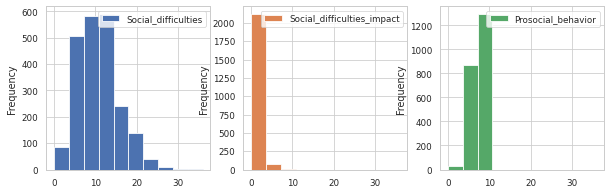

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2223 entries, 1274 to 99954902
Data columns (total 4 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Social_difficulties         2195 non-null   float64
 1   Social_difficulties_impact  2195 non-null   float64
 2   Prosocial_behavior          2195 non-null   float64
 3   Session                     2223 non-null   object 
dtypes: float64(3), object(1)
memory usage: 86.8+ KB


In [338]:
other_cols = [
('Social_difficulties_impact', 'simpact'),
('Prosocial_behavior', 'sprosoc')
]
for colname, cols in other_cols:
    df_out[colname] = df_raw[cols]
# @milena --> I adapted score calculation as I saw that the necessary variables are already included in the raw data file. Can you check if correct?
df_out.plot.hist(subplots=True, sharey=False, layout=(1,len(other_cols)+1), figsize=(4*len(other_cols)+2,3))
plt.show() 

df_out['Session'] = tp 
df_out.info() 

In [339]:
#read the raw data
df_raw2, tp, quest, formula = get_col_raw_df(108, df_confs)
print(quest, formula)
# df_raw2.columns

/FU3/dawba/IMAGEN_dawba_FU3.tsv recode items sobeys, sreflect, sattends, sfriend, spopular: 0 = 2, 1 = 1, 2 = 0; sum score = sconsid +  srestles + ssomatic + sshares + stantrum + sloner + sobeys + sworries + scaring + sfidgety + sfriend + sfights + sunhappy + spopular + sdistrac + sclingy + skind + slies + sbullied + shelpout + sreflect + ssteals + soldbest + safraid + sattends + sebddiff + schronic + sdistres + simphome + simpfrie + simpclas + simpleis + sburden + sebdtot + semotion + sconduct + shyper + speer + sprosoc + simpact


In [340]:
df_raw2 = df_raw2.reset_index().rename(columns={'level_0':'ID', 'level_1':'index'}).set_index('ID')

In [341]:
df_raw_i = df_raw2["sebdtot"]
df_raw_i.name = 'Social_difficulties'
df_out2 = df_raw_i.to_frame()
df_out2.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1315 entries, 112288 to 99954902
Data columns (total 1 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Social_difficulties  1312 non-null   float64
dtypes: float64(1)
memory usage: 20.5 KB


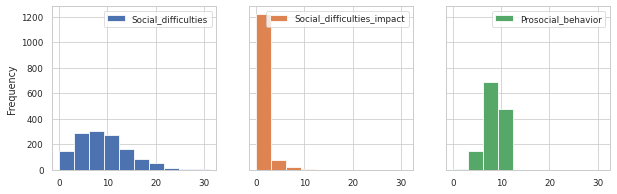

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1315 entries, 112288 to 99954902
Data columns (total 4 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Social_difficulties         1312 non-null   float64
 1   Social_difficulties_impact  1312 non-null   float64
 2   Prosocial_behavior          1312 non-null   float64
 3   Session                     1315 non-null   object 
dtypes: float64(3), object(1)
memory usage: 51.4+ KB


In [342]:
other_cols = [
('Social_difficulties_impact', 'simpact'),
('Prosocial_behavior', 'sprosoc')
]

for colname, cols in other_cols:
    df_out2[colname] = df_raw2[cols]
df_out2['Session'] = tp 

df_out2.plot.hist(subplots=True, sharey=True, layout=(1,len(other_cols)+1), figsize=(4*len(other_cols)+2,3))
plt.show() 

df_out2.info()

In [343]:
df_out = df_out.append(df_out2)

In [344]:
df_out.to_csv(CONF_DATA_DIR+'all_SDQ.csv')

##### all_TLFB
* 34 BL /BL/psytools/IMAGEN-IMGN_TLFB_RC5-BASIC_DIGEST.csv
* 49 FU3 /FU3/psytools/IMAGEN-IMGN_TLFB_FU3-IMAGEN_DIGEST.csv

In [570]:
#read the raw data
df_raw, tp, quest, formula = get_col_raw_df(34)
print(loc, quest, formula)

49 /BL/psytools/IMAGEN-IMGN_TLFB_RC5-BASIC_DIGEST.csv following items indicate number of days usage per substance in past 30 days: tlfb_alcohol1, tlfb_tobacco1, tlfb_cannabis1, tlfb_inhalants1, tlfb_prescription1, tlfb_amphet1, tlfb_lsd1, tlfb_mushrooms1, tlfb_crack1, tlfb_cocaine1, tlfb_heroin1, tlfb_narcotics1, tlfb_ecstasy1, tlfb_ketamine1, tlfb_ghb1, tlfb_anabolic1, tlfb_other1; take alcohol and tobacco scores as separate variables each; add up remaining items to a drug use variable


In [579]:
# display(df_raw)
df_raw_i = df_raw["tlfb_cannabis1, tlfb_inhalants1, tlfb_prescription1, tlfb_amphet1, tlfb_lsd1, tlfb_mushrooms1, \
tlfb_crack1, tlfb_cocaine1, tlfb_heroin1, tlfb_narcotics1, tlfb_ecstasy1, \
tlfb_ketamine1, tlfb_ghb1, tlfb_anabolic1, tlfb_other1".split(', ')].sum(1)
df_raw_i.name = 'Drugs Last Month'
df_out = df_raw_i.apply(lambda x:x if x>=0 else np.nan).to_frame() # @Milena were are some negative values that I made NaN --> good, negative values are not plausible as they refer to number of days
df_out['Session'] = tp
# df_out.info()

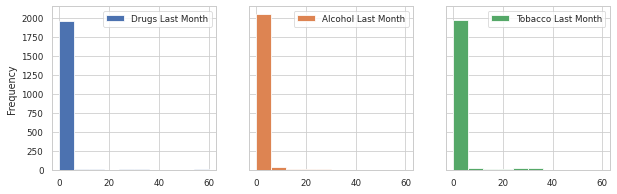

In [580]:
# now the remaining 4
other_cols = [
('Alcohol Last Month', 'tlfb_alcohol1'),
('Tobacco Last Month', 'tlfb_tobacco1'),
]

for colname, cols in other_cols:
    df_out[colname] = df_raw[cols].apply(lambda x:x if x>=0 else np.nan) # @Milena were are some negative values that I made NaN --> good, negative values are not plausible as they refer to number of days
    
df_out.plot.hist(subplots=True, sharey=True, layout=(1,len(other_cols)+1), figsize=(4*len(other_cols)+2,3))
plt.show() 

In [583]:
df_raw2, tp, quest, formula = get_col_raw_df(49)
print(loc, quest, formula)

49 /FU3/psytools/IMAGEN-IMGN_TLFB_FU3-IMAGEN_DIGEST.csv following items indicate number of days usage per substance in past 30 days: tlfb_alcohol1, tlfb_tobacco1, tlfb_cannabis1, tlfb_inhalants1, tlfb_prescription1, tlfb_amphet1, tlfb_lsd1, tlfb_mushrooms1, tlfb_crack1, tlfb_cocaine1, tlfb_heroin1, tlfb_narcotics1, tlfb_ecstasy1, tlfb_ketamine1, tlfb_ghb1, tlfb_anabolic1, tlfb_other1; take alcohol and tobacco scores as separate variables each; add up remaining items to a drug use variable


In [585]:
# display(df_raw)
df_raw2_i = df_raw2["tlfb_cannabis1, tlfb_inhalants1, tlfb_prescription1, tlfb_amphet1, tlfb_lsd1, tlfb_mushrooms1, \
tlfb_crack1, tlfb_cocaine1, tlfb_heroin1, tlfb_narcotics1, tlfb_ecstasy1, \
tlfb_ketamine1, tlfb_ghb1, tlfb_anabolic1, tlfb_other1".split(', ')].sum(1)
df_raw2_i.name = 'Drugs Last Month'
df_out2 = df_raw2_i.apply(lambda x:x if x>=0 else np.nan).to_frame() # @Milena were are some negative values that I made NaN --> good, negative values are not plausible as they refer to number of days
df_out2['Session'] = tp
# df_out2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1177 entries, 215284 to 99954902
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Drugs Last Month  1177 non-null   float64
 1   Session           1177 non-null   object 
dtypes: float64(1), object(1)
memory usage: 27.6+ KB


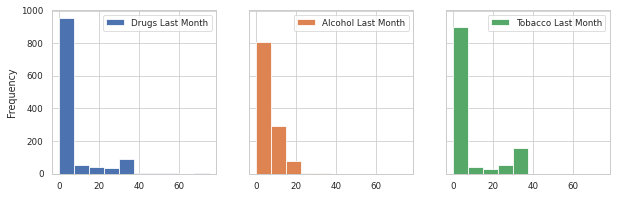

In [586]:
# now the remaining 4
other_cols = [
('Alcohol Last Month', 'tlfb_alcohol1'),
('Tobacco Last Month', 'tlfb_tobacco1'),
]

for colname, cols in other_cols:
    df_out2[colname] = df_raw2[cols].apply(lambda x:x if x>=0 else np.nan) # @Milena were are some negative values that I made NaN --> good, negative values are not plausible as they refer to number of days
    
df_out2.plot.hist(subplots=True, sharey=True, layout=(1,len(other_cols)+1), figsize=(4*len(other_cols)+2,3))
plt.show() 

In [591]:
df_out = df_out.append(df_out2)
df_out.to_csv(CONF_DATA_DIR+'all_TLFB.csv')

##### all_CSI
55 FU3 /FU3/psytools/IMAGEN-IMGN_CSI_FU3.csv

In [592]:
#read the raw data
df_raw, tp, quest, formula = get_col_raw_df(55)
print(loc, quest, formula)

49 /FU3/psytools/IMAGEN-IMGN_CSI_FU3.csv csi_sum


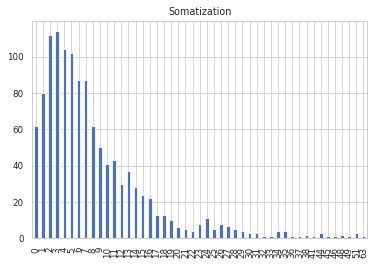

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1217 entries, 112288 to 99954902
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Somatization  1217 non-null   int64 
 1   Session       1217 non-null   object
dtypes: int64(1), object(1)
memory usage: 28.5+ KB


In [594]:
df_raw_i = df_raw['csi_sum']
df_raw_i.name = 'Somatization'
df_raw_i.value_counts().sort_index().plot.bar(title=df_raw_i.name)
plt.show() # @milena binarizing at median? --> lets try median first for consistency
df_out['Session'] = tp
df_out.info() 

In [595]:
df_out.to_csv(CONF_DATA_DIR+'all_CSI.csv')

##### all_IRI
56 FU3 /FU3/psytools/IMAGEN-IMGN_IRI_FU3.csv

In [31]:
#read the raw data
df_raw, tp, quest, formula = get_col_raw_df(56, df_confs)
print(quest, formula)

/FU3/psytools/IMAGEN-IMGN_IRI_FU3.csv sum score = IRI_fantasy + IRI_perspective + IRI_empathic + IRI_personal


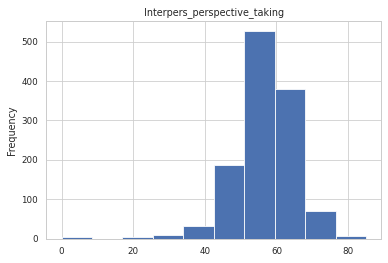

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1217 entries, 112288 to 99954902
Data columns (total 2 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   Interpers_perspective_taking  1217 non-null   int64 
 1   Session                       1217 non-null   object
dtypes: int64(1), object(1)
memory usage: 28.5+ KB


In [32]:
df_raw_i = df_raw['IRI_fantasy + IRI_perspective + IRI_empathic + IRI_personal'.split(' + ')].sum(1)
df_raw_i.name = 'Interpers_perspective_taking'
df_raw_i.plot.hist(title=df_raw_i.name)
plt.show() # @milena there are some outliers near 0 --> I would leave them in and try, as it's not unplausible that some people have very low scores.
df_out = df_raw_i.to_frame()
df_out['Session'] = tp
df_out.info() 

In [33]:
df_out.to_csv(CONF_DATA_DIR+'all_IRI.csv')

##### all_RRS
57 FU3 /FU3/psytools/IMAGEN-IMGN_RRS_FU3.csv

In [25]:
#read the raw data
df_raw, tp, quest, formula = get_col_raw_df(57, df_confs)
print(quest, formula)

/FU3/psytools/IMAGEN-IMGN_RRS_FU3.csv sum score = sum(RRS_1, RRS_2, RRS_3, RRS_4, RRS_5, RRS_6, RRS_7,
RRS_8, RRS_9, RRS_10, RRS_11, RRS_12, RRS_13, RRS_14, RRS_15, RRS_16, RRS_17,
RRS_18, RRS_19, RRS_20, RRS_21, RRS_22


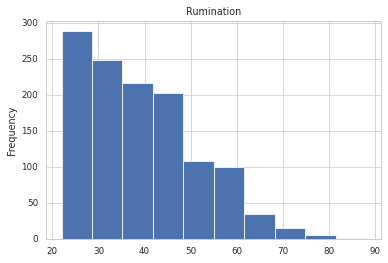

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1217 entries, 112288 to 99954902
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Rumination  1217 non-null   int64 
 1   Session     1217 non-null   object
dtypes: int64(1), object(1)
memory usage: 28.5+ KB


In [26]:
df_raw_i = df_raw['RRS_1, RRS_2, RRS_3, RRS_4, RRS_5, RRS_6, RRS_7, \
RRS_8, RRS_9, RRS_10, RRS_11, RRS_12, RRS_13, RRS_14, RRS_15, RRS_16, RRS_17, \
RRS_18, RRS_19, RRS_20, RRS_21, RRS_22'.split(', ')].sum(1)
df_raw_i.name = 'Rumination'
df_raw_i.plot.hist(title=df_raw_i.name)
plt.show() # @milena binary threshold median may not make sense?! --> I think it's the same as with all skewed distributions. Would stick with the median for consistency. 
df_out = df_raw_i.to_frame()
df_out['Session'] = tp
df_out.info() 

In [27]:
df_out.to_csv(CONF_DATA_DIR+'all_RRS.csv')

##### all_VGS
58 FU3 /FU3/psytools/IMAGEN-IMGN_VIDGAME_FU3.csv

In [605]:
#read the raw data
df_raw, tp, quest, formula = get_col_raw_df(58, df_confs)
print(loc, quest, formula)

49 /FU3/psytools/IMAGEN-IMGN_VIDGAME_FU3.csv only consider item VideoGame_2_1d: In the PAST 12 MONTHS On how many days per
week did you play?


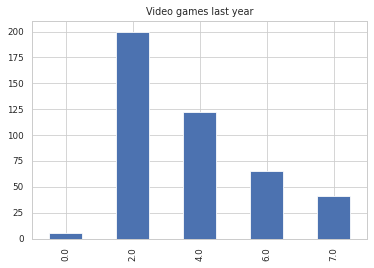

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1214 entries, 112288 to 99954902
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Video games last year  433 non-null    float64
 1   Session                1214 non-null   object 
dtypes: float64(1), object(1)
memory usage: 28.5+ KB


In [608]:
df_raw_i = df_raw['VideoGame_2_1d']
df_raw_i.name = 'Video games last year'
df_raw_i.value_counts().sort_index().plot.bar(title=df_raw_i.name)
plt.show() # @milena does the binary threshold median makes sense?! --> it would only make sense if values <= 2 are 0 and > 2 are 1.
df_out = df_raw_i.to_frame()
df_out['Session'] = tp
df_out.info() 

In [609]:
df_out.to_csv(CONF_DATA_DIR+'all_VGS.csv')

##### all_Urbanicity
69 FU3 /FU3/psytools/IMAGEN-IMGN_URBANICITY_FU3.csv

In [187]:
#read the raw data
df_raw, tp, quest, formula = get_col_raw_df(69, df_confs)
print(quest, formula)

/FU3/psytools/IMAGEN-IMGN_URBANICITY_FU3.csv weighted sum score = sum((URBANICITY_city*3), (URBANICITY_town*2),(URBANICITY_rural*1))


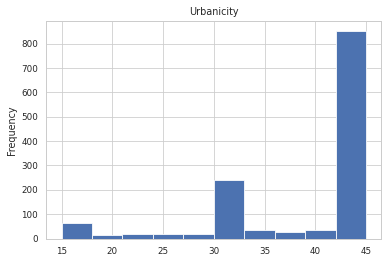

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1327 entries, 112288 to 99954902
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Urbanicity  1327 non-null   float64
 1   Session     1327 non-null   object 
dtypes: float64(1), object(1)
memory usage: 31.1+ KB


In [191]:
df_raw_i = (df_raw['URBANICITY_city']*3 +  df_raw['URBANICITY_town']*2 +  df_raw['URBANICITY_rural']) 

df_raw_i.name = 'Urbanicity'
df_raw_i.plot.hist(title=df_raw_i.name)
plt.show() # @milena does the binary threshold median makes sense?! --> there was a bug in sum score calculation, corrected it above :)
df_out = df_raw_i.to_frame()
df_out['Session'] = tp
df_out.info() 

In [192]:
df_out.to_csv(CONF_DATA_DIR+'all_Urbanicity.csv')

##### all_WHO
72 FU3 /FU3/psytools/IMAGEN-IMGN_WHO5_FU3.csv

In [626]:
#read the raw data
df_raw, tp, quest, formula = get_col_raw_df(72, df_confs)
print(loc, quest, formula)

49 /FU3/psytools/IMAGEN-IMGN_WHO5_FU3.csv transformed sum score = sum(WHO5_1 to WHO5_5) * 4


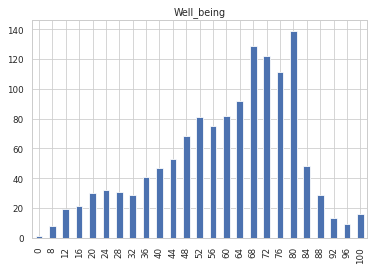

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1326 entries, 112288 to 99954902
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Well_being  1326 non-null   int64 
 1   Session     1326 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.1+ KB


In [627]:
df_raw_i = df_raw.filter(regex='WHO').sum(1)*4 # @Milena is it x4 or x5? --> x4 is correct. This is done to bring it to a percentage scale (4 x max score of 25 is = 100).
df_raw_i.name = 'Well_being'
df_raw_i.value_counts().sort_index().plot.bar(title=df_raw_i.name)
plt.show() # @milena should the binary threshold be greater than median or lower than median ? --> could again try the median first and then if it doesn't work well take the mean instead (which will be lower than median).
df_out = df_raw_i.to_frame()
df_out['Session'] = tp
df_out.info() 

In [628]:
df_out.to_csv(CONF_DATA_DIR+'all_WHO.csv')

##### all_HF
85 FU3 /FU3/psytools/IMAGEN-IMGN_HF_FU3.csv

In [193]:
#read the raw data
df_raw, tp, quest, formula = get_col_raw_df(85, df_confs)
print(loc, quest, formula)
# df_raw.columns

122 /FU3/psytools/IMAGEN-IMGN_HF_FU3.csv sum score any physical condition = sum(HF_08 to HF_18)


In [195]:
# recode items
for col in ['HF_08', 'HF_09', 'HF_10', 'HF_11', 'HF_12', 'HF_13', 'HF_14', 'HF_15', 'HF_16', 'HF_17', 'HF_18']:
    df_raw[col] = df_raw[col].map({1:1,2:0,7: np.nan,9: np.nan})

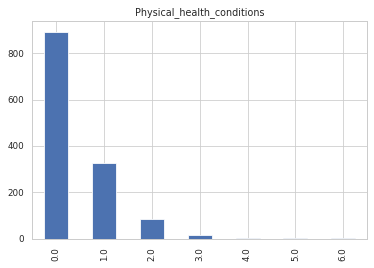

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1322 entries, 112288 to 99954902
Data columns (total 2 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Physical_health_conditions  1322 non-null   float64
 1   Session                     1322 non-null   object 
dtypes: float64(1), object(1)
memory usage: 31.0+ KB


In [196]:
df_raw_i = df_raw["'HF_08', 'HF_09', 'HF_10', 'HF_11', \
'HF_12', 'HF_13', 'HF_14', 'HF_15', 'HF_16', 'HF_17', 'HF_18'".replace("'","").split(", ")].sum(1)
df_raw_i.name = 'Physical_health_conditions'
df_raw_i.value_counts().sort_index().plot.bar(title=df_raw_i.name)
plt.show() # @milena --> items have to be recoded so that 1 = 1, 2 = 0, 7 = NaN, 9 = NaN; inserted this in the cell above - can you check if correct?
df_out = df_raw_i.to_frame()
df_out['Session'] = tp
df_out.info() 

In [197]:
df_out.to_csv(CONF_DATA_DIR+'all_HF.csv')

##### all_Par_ESPAD
111 https://matt.might.net/articles/phd-school-in-pictures/BL /BL/psytools/IMAGEN-IMGN_ESPAD_PARENT_RC5-BASIC_DIGEST.csv

In [ ]:
#read the raw data
df_raw, tp, quest, formula = get_col_raw_df(111, df_confs)
print(loc, quest, formula)

111 /BL/psytools/IMAGEN-IMGN_ESPAD_PARENT_RC5-BASIC_DIGEST.csv sum of all dast items as global measure for drug abuse


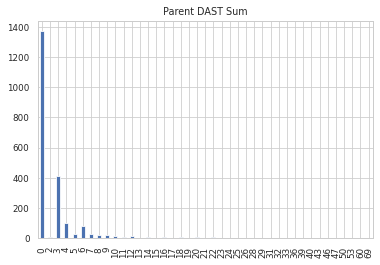

Parent DAST Sum Session
ID                               
1274                    0      BL
22453                   0      BL
75717                   0      BL
106601                  0      BL
106871                  0      BL
...                   ...     ...
99826568                0      BL
99873252                0      BL
99888850                0      BL
99930021                0      BL
99954902                3      BL

[2182 rows x 2 columns]

In [ ]:
df_raw_i = df_raw.filter(regex='dast_.*_sum').sum(1)
df_raw_i.name = 'Parent DAST Sum'
df_raw_i.value_counts().sort_index().plot.bar(title=df_raw_i.name)
plt.show()
df_out = df_raw_i.to_frame()
df_out['Session'] = tp
df_out

In [ ]:
df_out.to_csv(CONF_DATA_DIR+'all_Par_ESPADall_Par_ESPAD.csv')

##### all_PBQ
* 118 BL /BL/psytools/IMAGEN-IMGN_PBQ_RC1-BASIX_DIGEST.csv
* 119 BL /BL/psytools/IMAGEN-IMGN_PBQ_RC1-BASIX_DIGEST.csv
* 120 BL /BL/psytools/IMAGEN-IMGN_PBQ_RC1-BASIX_DIGEST.csv
* 121 BL /BL/psytools/IMAGEN-IMGN_PBQ_RC1-BASIX_DIGEST.csv
* 122 BL /BL/psytools/IMAGEN-IMGN_PBQ_RC1-BASIX_DIGEST.csv

In [171]:
#read the raw data
formulas=[]
for i, loc in enumerate([118,119,120,121,122]):
    df_raw, tp, quest, formula = get_col_raw_df(loc, df_confs)
    if i>0:assert tp_old==tp and quest_old==quest
    formulas.append(formula)
    tp_old=tp
    quest_old=quest
    print(loc, quest, formula)

118 /BL/psytools/IMAGEN-IMGN_PBQ_RC1-BASIC_DIGEST.csv sum(pbq_05a, pbq_05b, pbq_05c)
119 /BL/psytools/IMAGEN-IMGN_PBQ_RC1-BASIC_DIGEST.csv pbq_06a
120 /BL/psytools/IMAGEN-IMGN_PBQ_RC1-BASIC_DIGEST.csv pbq_10
121 /BL/psytools/IMAGEN-IMGN_PBQ_RC1-BASIC_DIGEST.csv pbq_11
122 /BL/psytools/IMAGEN-IMGN_PBQ_RC1-BASIC_DIGEST.csv pbq_12


In [172]:
df_raw_i = df_raw["pbq_05a, pbq_05b, pbq_05c".split(', ')].sum(1)
df_raw_i.name = 'Parent cigerattes during pregnancy'
df_out = df_raw_i.to_frame()
df_out['Session'] = tp
# df_out.info()

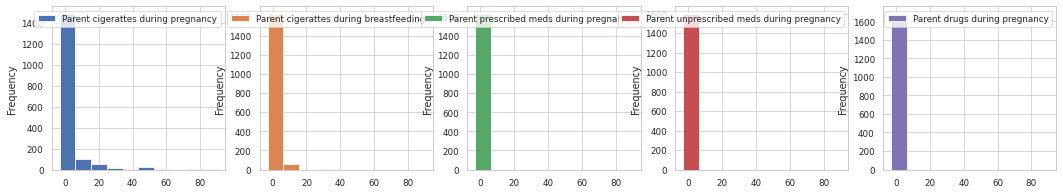

In [173]:
# now the remaining 4
other_cols = [
('Parent cigerattes during breastfeeding', 'pbq_06a'),
('Parent prescribed meds during pregnancy', 'pbq_10'),
('Parent unprescribed meds during pregnancy', 'pbq_11'),
('Parent drugs during pregnancy', 'pbq_12'),
]

for colname, cols in other_cols:
    df_out[colname] = df_raw[cols]
    if cols in ['pbq_10', 'pbq_11', 'pbq_12']: #@Milena for pbq_10, pbq_11 and pbq_12, negative values have to be coded as missing
        # display(df_out[colname].value_counts())
        df_out[colname] = df_out[colname].map({0:0, 1:1, -1:np.NaN,-2:np.NaN})
    else:   #@Milena missing as 0 --> correct; for all others
        df_out[colname] = df_out[colname].fillna(0)
        
df_out.plot.hist(subplots=True, sharey=False, layout=(1,len(other_cols)+1), figsize=(4*len(other_cols)+2,3))
plt.show() # @Milena --> low values are plausible

In [174]:
df_out.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1688 entries, 1274 to 99954902
Data columns (total 6 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Parent cigerattes during pregnancy         1688 non-null   float64
 1   Session                                    1688 non-null   object 
 2   Parent cigerattes during breastfeeding     1688 non-null   float64
 3   Parent prescribed meds during pregnancy    1627 non-null   float64
 4   Parent unprescribed meds during pregnancy  1594 non-null   float64
 5   Parent drugs during pregnancy              1677 non-null   float64
dtypes: float64(5), object(1)
memory usage: 92.3+ KB


In [175]:
df_old = pd.read_csv(CONF_DATA_DIR+'all_PBQ.csv').set_index(['ID','Session'])
df_out = df_out.reset_index().set_index(['ID','Session'])
df_old[df_out.columns] = df_out
df_old.reset_index().set_index('ID').to_csv(CONF_DATA_DIR+'all_PBQ.csv')

##### all_Par_AUDIT
123 BL /BL/psytools/IMAGEN-IMGN_AUDIT_PARENT_RC5-BASIC_DIGEST.csv

In [509]:
#read the raw data
df_raw, tp, quest, formula = get_col_raw_df(123, df_confs)
print(loc, quest, formula)

111 /BL/psytools/IMAGEN-IMGN_AUDIT_PARENT_RC5-BASIC_DIGEST.csv audit_total


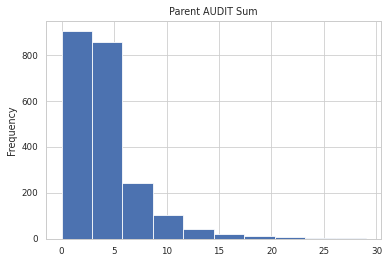

Parent AUDIT Sum Session
ID                                
1274                     3      BL
22453                    4      BL
75717                    2      BL
106601                   2      BL
106871                   2      BL
...                    ...     ...
99826568                 0      BL
99873252                 2      BL
99888850                 4      BL
99930021                 3      BL
99954902                 7      BL

[2182 rows x 2 columns]

In [510]:
df_raw_i = df_raw["audit_total"]
df_raw_i.name = 'Parent AUDIT Sum'
df_raw_i.plot.hist(title=df_raw_i.name)
plt.show()
df_out = df_raw_i.to_frame()
df_out['Session'] = tp
df_out

In [511]:
df_out.to_csv(CONF_DATA_DIR+'all_Par_AUDIT.csv')

##### all_ESPAD (bully)
109 FU3 /FU3/psytools/IMAGEN-IMGN_BULLY_FU3.csv

In [565]:
#read the raw data
df_raw, tp, quest, formula = get_col_raw_df(109, df_confs)
print(loc, quest, formula)

111 /FU3/psytools/IMAGEN-IMGN_BULLY_FU3.csv sum score 'bully': bully05 + bully06 + bully07 + bully08 + bully11 + bully12; sum score 'victim': bully01 + bully02 + bully03 + bully04 + bully09 + bully10


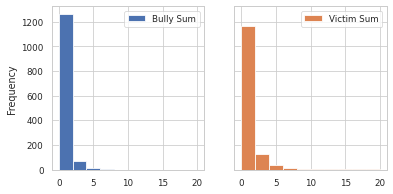

Bully Sum  Victim Sum Session
ID                                     
112288            0           0     FU3
215284            0           4     FU3
240546            0           2     FU3
297685            0           0     FU3
308867            0           0     FU3
...             ...         ...     ...
99677574          0           1     FU3
99873252          0           0     FU3
99875982          0           8     FU3
99930021          0           0     FU3
99954902          0           0     FU3

[1350 rows x 3 columns]

In [566]:
df_raw_i = df_raw["bully05 + bully06 + bully07 + bully08 + bully11 + bully12".split(' + ')].sum(1)
df_raw_i.name = 'Bully Sum'
df_out = df_raw_i.to_frame()

df_out['Victim Sum'] = df_raw["bully01 + bully02 + bully03 + bully04 + bully09 + bully10".split(' + ')].sum(1)

df_out['Session'] = tp

df_out.plot.hist(subplots=True, sharey=True, layout=(1,2), figsize=(4+2,3))
plt.show() # @Milena - is this the same as the 'all_ESPAD' file creation in analysis 0 iteration 1? And could you add 'df_out['Smoking Lifetime'] = df_raw['6']' for FU3 as well? (either here or in iteration 1?)

df_out

In [567]:
df_old = pd.read_csv(CONF_DATA_DIR+'all_ESPAD.csv').set_index('ID')
# df_old.loc[:,["Bully Sum","Victim Sum"]] = df_out.reset_index().set_index(['ID','Session'])
df_old.loc[df_old['Session']==tp, ["Bully Sum","Victim Sum"]] = df_out[["Bully Sum","Victim Sum"]]
df_old.to_csv(CONF_DATA_DIR+'all_ESPAD.csv')

# Main Analysis
Prepare all H5files and run the MLpipelines on 3 h5files:

1) MRI BL 1 binge experience --> FU3 binge drinking with confounds from FU3 and BL
2) MRI BL 0 binge experience --> FU3 binge drinking with confounds from FU3 and BL
3) MRI BL --> FU3 binge drinking with confounds from FU3 and BL
4) MRI FU3 --> FU3 binge drinking with confounds from FU3

In [13]:
from matplotlib.ticker import FormatStrFormatter
from sklearn.impute import KNNImputer

In [14]:
plot_dist = True
print_all = True
h5_name = 'h5causal1' # 'h5causal0' 'h5causal1', 'h5fu3', 'h5bl'
h5_src = H5_FILES[h5_name] 

### Create h5files with confounders
@@Milena skip

In [15]:
# ! rm -rvf $H5_DIR/$rerun_ver*$h5_name*
# ! rm -rvf $H5_DIR/../$rerun_ver*$h5_name*

In [16]:
# ! rm -rf ../MLpipelines/results/$rerun_ver-*$h5_name*

-------------------  (0) Alc-lastmnt   ----------------------
Using Q collected at session-BL
imputing 752/2217 missing values with 0.0
range (min, mean, median, max) = (0.00, 0.60, 0.00, 6.00)


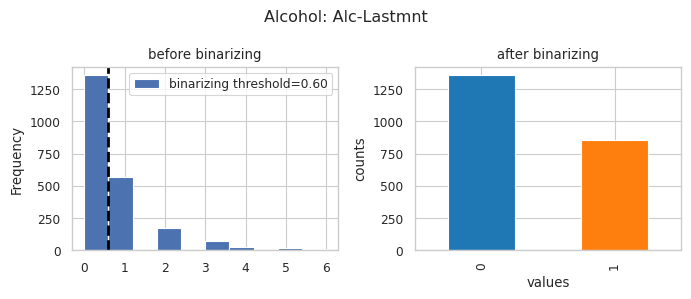

writing to .. posthoc-cc3-h5causal1-Alc-lastmnt.h5
attaching conf Alc-lastmnt
-------------------  (1) Alc-last12mnt   ----------------------
Using Q collected at session-BL
imputing 521/2217 missing values with 0.0


/tmp/ipykernel_814234/3644680309.py:37: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for val,counts in conf.iloc[conf_sub_ids_in_h5].value_counts().iteritems():


range (min, mean, median, max) = (0.00, 1.41, 1.00, 6.00)


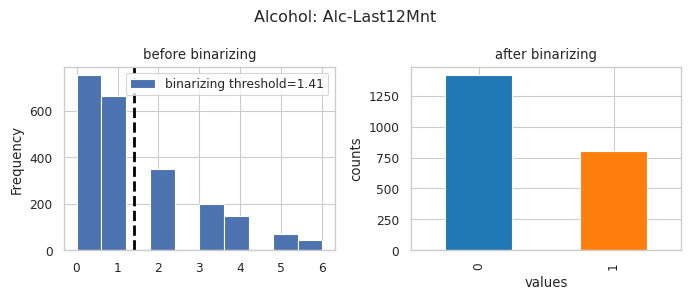

writing to .. posthoc-cc3-h5causal1-Alc-last12mnt.h5
attaching conf Alc-last12mnt
-------------------  (2) Neuroticism   ----------------------
Using Q collected at session-BL
range (min, mean, median, max) = (0.33, 1.93, 1.92, 3.92)


/tmp/ipykernel_814234/3644680309.py:37: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for val,counts in conf.iloc[conf_sub_ids_in_h5].value_counts().iteritems():


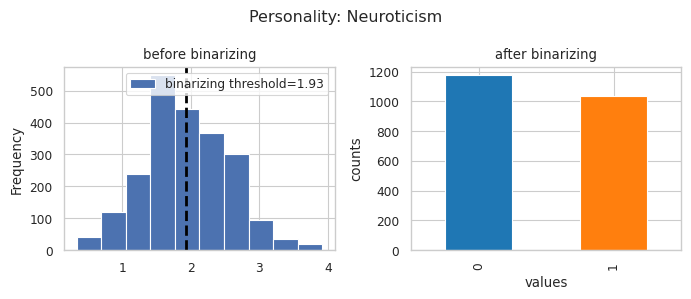

writing to .. posthoc-cc3-h5causal1-Neuroticism.h5
attaching conf Neuroticism
-------------------  (3) Extroversion   ----------------------
Using Q collected at session-BL
range (min, mean, median, max) = (0.25, 2.50, 2.50, 3.92)


/tmp/ipykernel_814234/3644680309.py:37: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for val,counts in conf.iloc[conf_sub_ids_in_h5].value_counts().iteritems():


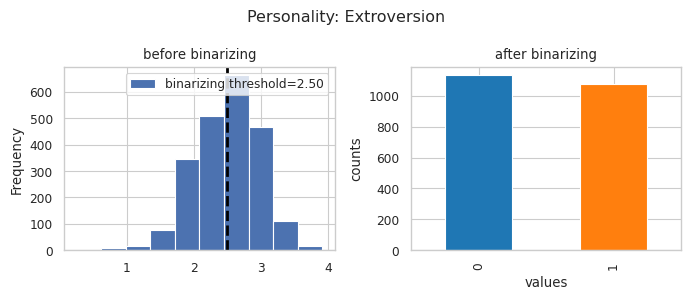

writing to .. posthoc-cc3-h5causal1-Extroversion.h5
attaching conf Extroversion
-------------------  (4) Conscientiousness   ----------------------
Using Q collected at session-BL
range (min, mean, median, max) = (0.50, 2.30, 2.33, 4.00)


/tmp/ipykernel_814234/3644680309.py:37: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for val,counts in conf.iloc[conf_sub_ids_in_h5].value_counts().iteritems():


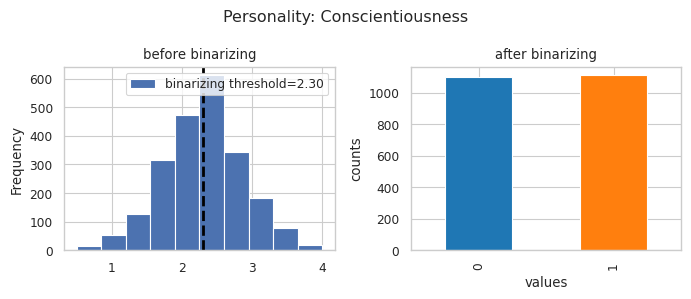

writing to .. posthoc-cc3-h5causal1-Conscientiousness.h5
attaching conf Conscientiousness
-------------------  (5) Openness   ----------------------
Using Q collected at session-BL
range (min, mean, median, max) = (0.83, 2.17, 2.17, 3.75)


/tmp/ipykernel_814234/3644680309.py:37: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for val,counts in conf.iloc[conf_sub_ids_in_h5].value_counts().iteritems():


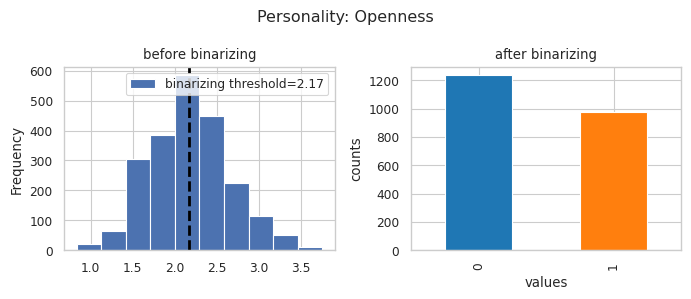

writing to .. posthoc-cc3-h5causal1-Openness.h5
attaching conf Openness
-------------------  (6) Agreeableness   ----------------------
Using Q collected at session-BL
range (min, mean, median, max) = (0.50, 2.40, 2.42, 3.67)


/tmp/ipykernel_814234/3644680309.py:37: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for val,counts in conf.iloc[conf_sub_ids_in_h5].value_counts().iteritems():


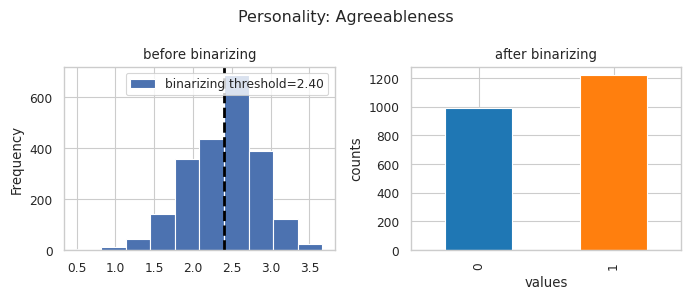

writing to .. posthoc-cc3-h5causal1-Agreeableness.h5
attaching conf Agreeableness
-------------------  (7) Family_freq   ----------------------
Using Q collected at session-BL
range (min, mean, median, max) = (0.00, 0.26, 0.20, 1.00)


/tmp/ipykernel_814234/3644680309.py:37: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for val,counts in conf.iloc[conf_sub_ids_in_h5].value_counts().iteritems():


KeyboardInterrupt: 

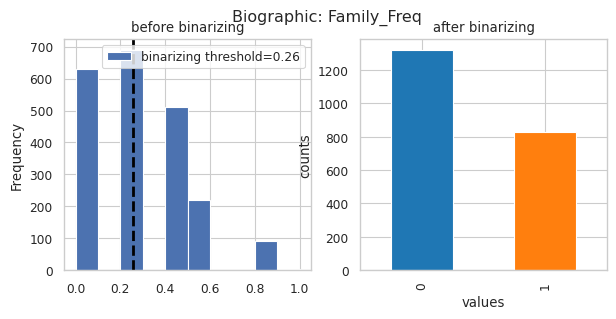

In [17]:
df_conf_list = pd.read_excel("Confounds_list_Milena_v3.xlsx")

for i,row in df_conf_list.iterrows():
    print(f"-------------------  ({i}) {row['conf_name']}   ----------------------")
    # load the confound from corresponding questionnaire as a pandas Series
    # print(f"From {CONF_DATA_DIR+row['questionnaire']} reading column '{row['colname']}'")
    if '???' in row["questionnaire"] or '???' in row["colname"]:
        print(f"[ERROR] {row['conf_name']} missing preprocessed tables. Extract this first.")
        continue
        
    if 'FU' in h5_name.upper() and ('FU' not in row['time_point'].upper()) and row['subject']!='parent':
        print(f"Skipping this conf since it is not applicable for FUx timepoint analysis")
        continue
        
    df_conf = pd.read_csv(CONF_DATA_DIR + row["questionnaire"]).set_index('ID')

    if ('Session' in df_conf):
        conf = df_conf.loc[df_conf['Session']==row['time_point'], row['colname']] 
        if print_all: print(f"Using Q collected at session-{row['time_point']}")
    elif ('Session' in df_conf and df_conf['Session'].nunique()>1):
        conf = df_conf.loc[df_conf['Session']=='FU3', row['colname']] 
        if print_all: print(f"Using Q collected at session-FU3")
    else:
        conf = df_conf[row['colname']]
        if print_all: print(f"Using Q collected at session-???")

    # attach the timepoint to the name if it is not BL 
    conf.name = row['conf_name']
    if row['time_point'] != 'BL': 
        conf.name += row['time_point']

    # impute missing values with given value
    if conf.isna().sum() and isinstance(row['impute_missing_with'], (int,float)):
        if print_all: print(f"imputing {conf.isna().sum()}/{len(conf)} missing values with {row['impute_missing_with']}")
        conf = conf.fillna(row['impute_missing_with'])
    elif conf.isna().sum():
        if print_all: print(f"imputing {conf.isna().sum()}/{len(conf)} missing with K-Nearest-Neighbour algorithm")
        # use KNN
        conf.loc[:] = KNNImputer().fit_transform(conf.values.reshape(-1, 1)).ravel()

    # plot conf distribution before binarizing
    if plot_dist:
        f, axes = plt.subplots(1,2, figsize=(7,3), sharey=False)
        plt.suptitle(f"{row['category']}: {conf.name.title()}")

        kwargs = dict(ax=axes[0],
            title="before binarizing", 
            xlabel='values', ylabel='counts')

        nunique = conf.nunique()

        conf.plot(
            kind='hist', bins=10 if nunique<100 else nunique//10,
            **kwargs)

        if print_all: print(
            f"range (min, mean, median, max) = ({conf.min():.2f}, {conf.mean():.2f}, {conf.median():.2f}, {conf.max():.2f})")

    # binarize 
    binarizing_threshold = conf.median() if row['binarizing_threshold']=='median' else conf.mean()
    conf = conf.apply(lambda x: int(x>binarizing_threshold))

    # plot conf distribution after binarizing
    if plot_dist:
        # draw the threshold in the prev plot
        axes[0].axvline(binarizing_threshold, c='k', ls='--', lw=2, label='binarizing threshold')
        hdls, lbls = axes[0].get_legend_handles_labels()
        axes[0].legend([hdls[0]], ['binarizing threshold={:.2f}'.format(binarizing_threshold)])

        colors = [plt.get_cmap("tab10")(v) for v in sorted(conf.unique())]
        conf.value_counts(dropna=False).sort_index().plot(
            ax=axes[1], kind='bar',
            title="after binarizing", 
            xlabel='values', ylabel='counts', color=colors)
        plt.tight_layout()
        plt.show()

    # attach conf to the h5 file
    try:
        attach_conf_fromseries(H5_DIR, h5_src, conf, prepend=h5_name, print_all=print_all)
    except AssertionError as e:
        print("[ERROR] Failed to create h5:",e)
            # @Milena look at the log below for the 120+ confounds

### Check created h5files

In [17]:
# check_h5_contents(glob(H5_DIR+f"$rerun_ver-*.h5")) #{h5_name}

In [18]:
print("Created {} h5 files".format(len(glob(H5_DIR+f"{rerun_ver}-*{h5_name}*.h5")))) #{h5_name}

Created 123 h5 files


In [19]:
print_h5_for_MLpipeline(filter_func=lambda x: f"{rerun_ver}-{h5_name}" in x) #{h5_name}

  DATA_DIR + 'h5files/posthoc-cc3-h5causal1-AUDIT_parent.h5',
  DATA_DIR + 'h5files/posthoc-cc3-h5causal1-Accident_freq.h5',
  DATA_DIR + 'h5files/posthoc-cc3-h5causal1-Accident_val.h5',
  DATA_DIR + 'h5files/posthoc-cc3-h5causal1-Accident_valFU3.h5',
  DATA_DIR + 'h5files/posthoc-cc3-h5causal1-Age_first_drunkFU3.h5',
  DATA_DIR + 'h5files/posthoc-cc3-h5causal1-Agreeableness.h5',
  DATA_DIR + 'h5files/posthoc-cc3-h5causal1-AgreeablenessFU3.h5',
  DATA_DIR + 'h5files/posthoc-cc3-h5causal1-Alc-last12mnt.h5',
  DATA_DIR + 'h5files/posthoc-cc3-h5causal1-Alc-last12mntFU3.h5',
  DATA_DIR + 'h5files/posthoc-cc3-h5causal1-Alc-lastmnt.h5',
  DATA_DIR + 'h5files/posthoc-cc3-h5causal1-Alc-lastmntFU3.h5',
  DATA_DIR + 'h5files/posthoc-cc3-h5causal1-Alc_lastmnt_TLFB.h5',
  DATA_DIR + 'h5files/posthoc-cc3-h5causal1-Alc_lastmnt_TLFBFU3.h5',
  DATA_DIR + 'h5files/posthoc-cc3-h5causal1-Alcohol_problem_indexFU3.h5',
  DATA_DIR + 'h5files/posthoc-cc3-h5causal1-Alcoholism_screening_parent.h5',
  DATA_DIR 

### Run MLpipeline
 Add the above h5files in runMLpipelines.py, configure the appropriate settings and run it as
 `$nohup python3 runMLpipelines.py &`

## Exploratory stage
##### For each variable find the extend of the effect it has on accuracy

In [20]:
# map the categories and the confound name
df_conf_list = pd.read_excel("Confounds_list_Milena_v3.xlsx")
all_confs = (df_conf_list['conf_name']+df_conf_list['time_point']).apply(lambda x: x[::-1].replace("LB","",1)[::-1]) # remove the last 'BL'in conf name
df_conf_list['confound_final_name'] = all_confs
all_confs = all_confs.unique().tolist()
print("n confounds in the table:",len(all_confs))

cat_map = df_conf_list[['category','confound_final_name']].drop_duplicates(ignore_index=True)
cat_map = cat_map.set_index('confound_final_name', drop=True).squeeze().to_dict()

n confounds in the table: 137


In [21]:
# for each h5 and do other checks and preprocessings
all_df = {}
dfi_top_red, dfi_top_incr = {}, {}
for h5_name in ['h5causal0', 'h5causal1']: ## @remove 'h5bl'
    dfi = create_accuracy_csv(h5_name)
    # display(dfi)
    dfi['h5cat'] = h5_name
    dfi = dfi.loc[(dfi['Model'].isin(['SVM-rbf']))].sort_values( ## @remove 'GB'
        ['Accuracy Diff CB - BL'])
    print(f"{'-'*20}\nh5_name = {h5_name}:\n{'-'*20} \n accuracy range (max-drop, max-gain) = \
({dfi['Accuracy Diff CB - BL'].min()*100:.0f}%, {dfi['Accuracy Diff CB - BL'].max()*100:.0f}%)")
    
    confounds = dfi.Confound.unique().tolist()
    
    print(f" no. of accepted variables = {len(confounds)}")
    skipped = [c for c in all_confs if c not in confounds]
    # for FU3 filter out non-FU3 confs as they were skipped on purpose
    if 'fu3' in h5_name:
        skipped = [k for k in skipped if (('FU3' in skipped[-4:]) or ('FU2' in skipped[-4:]))]
    print(f" {len(skipped)} of skipped variables : {skipped}")
    
    
    # add the cat_map to the df csv 
    dfi['category'] = dfi.apply(lambda row: cat_map[row['Confound']] if row['Confound'] in cat_map else np.nan, axis=1)
    dfi.to_csv(f"results_explorative_{h5_name}.csv")
    all_df.update({h5_name: dfi})
    
    # # define lower and upper threshold based on results in section 'exploratory results summary plot' - @Roshan: this is still hard coded, didn't adapt it til now
    # lower_threshold = -2.9153173773
    # upper_threshold = 1.4510502575
    
    # # filter out variables below and above SD-defined threshold
    # dfi_top_red[h5_name] = dfi.loc[(dfi['Accuracy Diff CB - BL']<=(lower_threshold/100))].sort_values( ## @remove 'GB'
    # ['Accuracy Diff CB - BL'])
    # dfi_top_red[h5_name].to_csv(f"results/results_explorative_{h5_name}_top_red.csv", index=False)
    
    # dfi_top_incr[h5_name] = dfi.loc[(dfi['Accuracy Diff CB - BL']>=(upper_threshold/100))].sort_values( ## @remove 'GB'
    # ['Accuracy Diff CB - BL'])
    # dfi_top_incr[h5_name].to_csv(f"results/results_explorative_{h5_name}_top_incr.csv", index=False)

    # print("Top accuracy reducing variables (df):")
    # display(dfi_top_red[h5_name])
    # print("Top accuracy increasing variables (df):")
    # display(dfi_top_incr[h5_name])

--------------------
h5_name = h5causal0:
-------------------- 
 accuracy range (max-drop, max-gain) = (-8%, 4%)
 no. of accepted variables = 120
 17 of skipped variables : ['Drug_abuse_lft', 'Nicotine_dependence', 'Comp_sub_abuse_lft', 'Tobacco_lastmnt_TLFB', 'Drugs_lastmnt_TLFB', 'Smoking_lifetime', 'Drug_abuse_lftFU3', 'Nicotine_dependenceFU3', 'Accident_freqFU3', 'BullyingFU3', 'Conflict_tactics_parent_mean_assault', 'Conflict_tactics_parent_mean_injury', 'Conflict_tactics_parent_sexual_coercion', 'PBQ_cigarettes_pregnancy', 'PBQ_cigarettes_breastfeeding', 'PBQ_pres_meds', 'PBQ_drugs']
--------------------
h5_name = h5causal1:
-------------------- 
 accuracy range (max-drop, max-gain) = (-9%, 4%)
 no. of accepted variables = 121
 16 of skipped variables : ['Alc-lastmnt', 'Drug_abuse_lft', 'Nicotine_dependence', 'Comp_sub_abuse_lft', 'Tobacco_lastmnt_TLFB', 'Drugs_lastmnt_TLFB', 'Drug_abuse_lftFU3', 'Nicotine_dependenceFU3', 'Accident_freqFU3', 'Conflict_tactics_parent_mean_assault'

### Explorative results plot
@@Milena skip

/tmp/ipykernel_359404/1756800940.py:78: FutureWarning: `sort_columns` is deprecated and will be removed in a future version.
  df_i.plot(kind='barh',


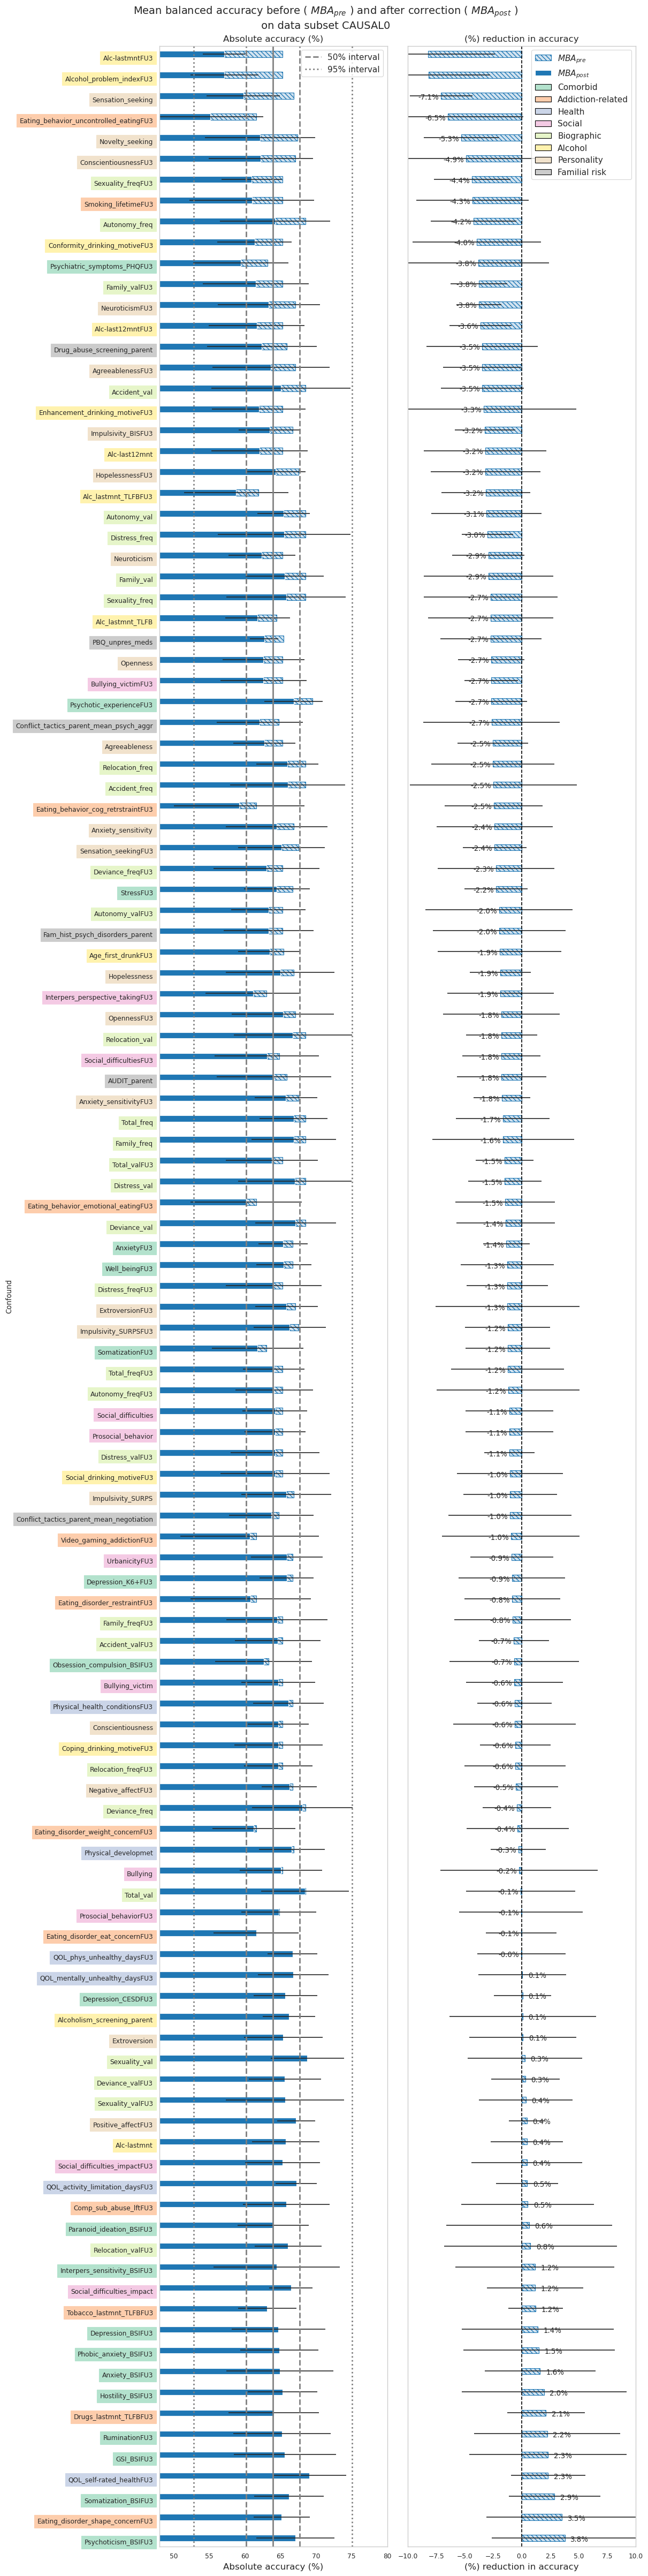

/tmp/ipykernel_359404/1756800940.py:78: FutureWarning: `sort_columns` is deprecated and will be removed in a future version.
  df_i.plot(kind='barh',


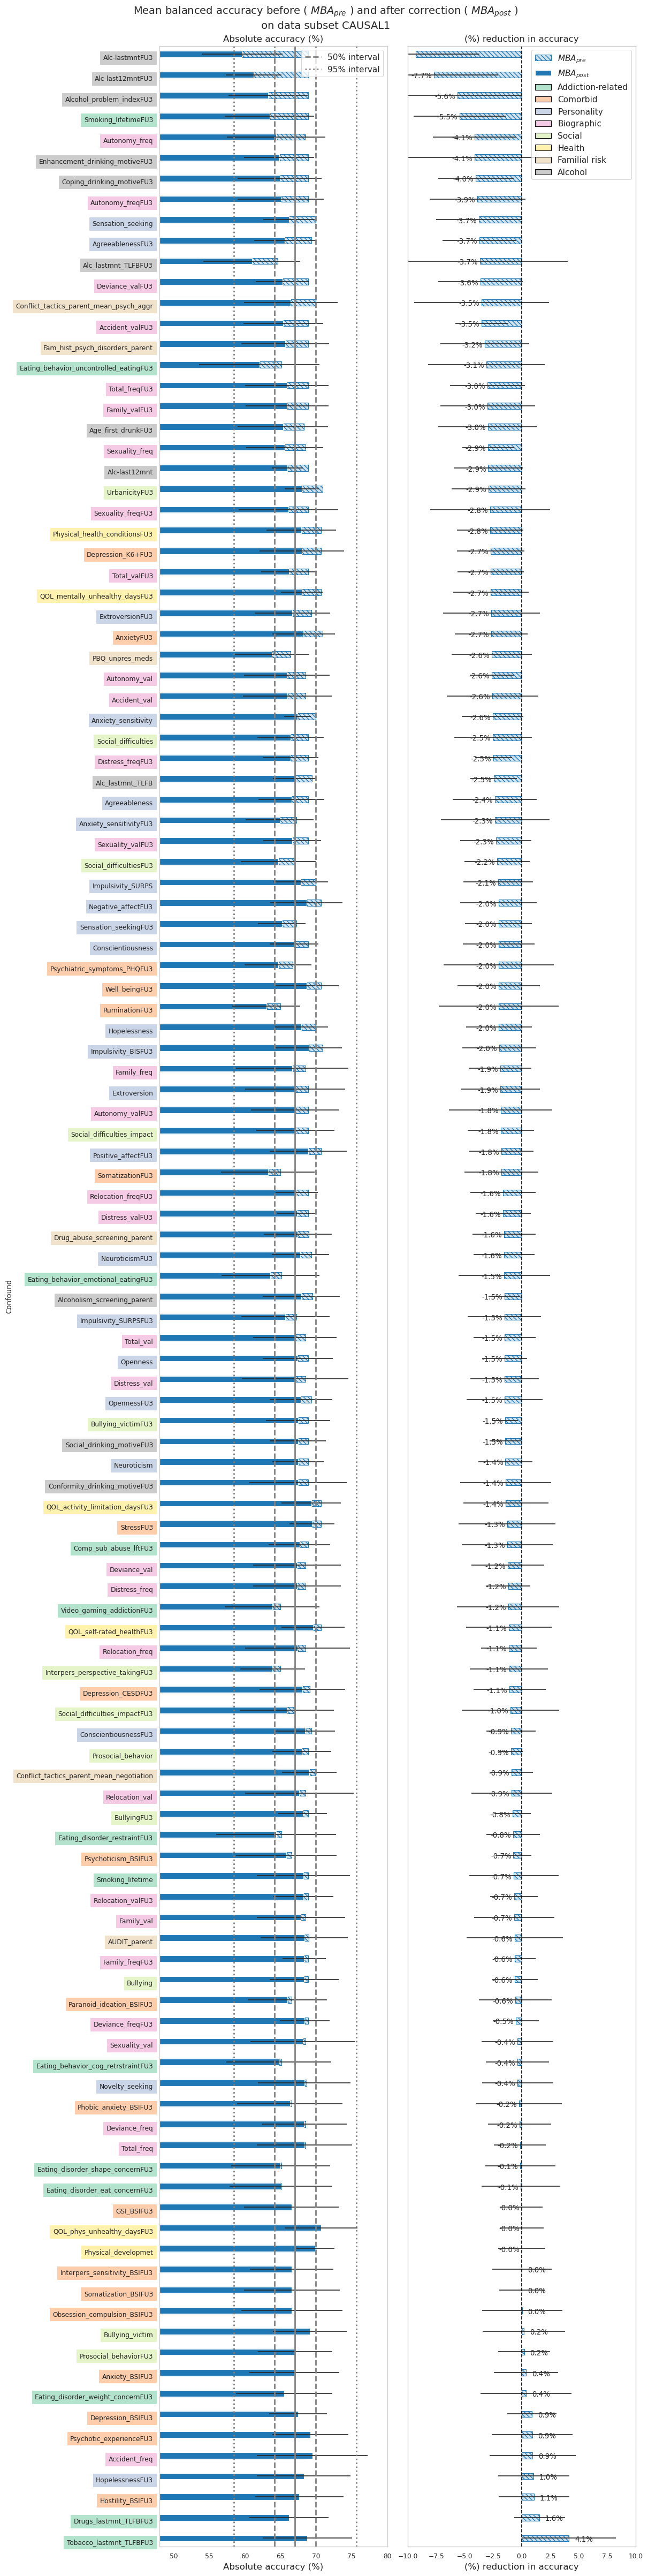

In [15]:
# plot results
for h5_name, dfi in all_df.items():
    
    plot_accuracy_csv(dfi, color_cat=True, 
                      permutation_results=f"results/{h5_name}_permutation_results.json"
                     )
    plt.savefig(f"results/results-{h5_name}.png", bbox_inches='tight')
    plt.show()
    # break

### Explorative results summary plot

In [67]:
df_all = pd.DataFrame()
for h5_name, dfi in all_df.items():
    dfi = dfi.sort_values(['category','Confound'])
    dfi['abs_diff'] = dfi['Accuracy Diff CB - BL'].apply(abs)
    for c in ['Accuracy BL',
       'Std-Dev BL', 'Accuracy CB', 'Std-Dev CB', 'Accuracy Diff CB - BL',
       'Std-Dev Diff CB - BL','abs_diff']:
        dfi[c] *= 100
    # calculate ranks
    dfi['rank'] = np.nan
    for h5_i, df_h5_i in dfi.groupby("h5cat"):
        df_h5_i = df_h5_i.sort_values('Accuracy Diff CB - BL')
        dfi.loc[df_h5_i.index, ['rank']] = np.arange(len(df_h5_i))
    assert dfi['rank'].isna().any() != True
    df_all = df_all.append(dfi)

df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 241 entries, 104 to 290
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Confound               241 non-null    object 
 1   Conf_time_point        241 non-null    object 
 2   Model                  241 non-null    object 
 3   h5name                 241 non-null    object 
 4   Accuracy BL            241 non-null    float64
 5   Std-Dev BL             241 non-null    float64
 6   Accuracy CB            241 non-null    float64
 7   Std-Dev CB             241 non-null    float64
 8   Accuracy Diff CB - BL  241 non-null    float64
 9   Std-Dev Diff CB - BL   241 non-null    float64
 10  h5cat                  241 non-null    object 
 11  category               241 non-null    object 
 12  abs_diff               241 non-null    float64
 13  rank                   241 non-null    int64  
dtypes: float64(7), int64(1), object(6)
memory usage: 28.2+ K

/tmp/ipykernel_814234/3193176335.py:13: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  dfi.loc[df_h5_i.index, ['rank']] = np.arange(len(df_h5_i))
/tmp/ipykernel_814234/3193176335.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all = df_all.append(dfi)
/tmp/ipykernel_814234/3193176335.py:13: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  dfi.loc[df_h5_i.index, ['rank']] = np.arange(len(df_h5_i))
/tmp/ipykernel_814234/3193176335.py:15: FutureWarning

In [69]:
df_all = df_all[df_all.h5cat=='h5causal0']

In [23]:
# save the table for the paper
df_all.to_csv("results/results_explorative_cc3.csv")

##### Which variables co-occur in both onset0 and onset1? systematic analysis

In [80]:
#@@Milena adjust the thresholds if needed. Currently set to the same as before
mean = df_all["Accuracy Diff CB - BL"].mean()
std_dev =  df_all["Accuracy Diff CB - BL"].std()
print(f"Thresholds for (mean-1.282*std_dev, mean-1.036*std_dev, mean-1.0*std_dev, mean, mean+1.0*std_dev, mean+1.036*std_dev, mean+1.282*std_dev)= \n\
({mean-1.282*std_dev:.10f}, {mean-1.036*std_dev:.10f}, {mean-1.0*std_dev:.10f}, {mean:.10f}, {mean+1.0*std_dev:.10f}, {mean+1.036*std_dev:.10f}, {mean+1.282*std_dev:.10f}, )")


upper_threshold = mean+2*std_dev
lower_threshold = mean-2*std_dev

Thresholds for (mean-1.282*std_dev, mean-1.036*std_dev, mean-1.0*std_dev, mean, mean+1.0*std_dev, mean+1.036*std_dev, mean+1.282*std_dev)= 
(-4.1308643043, -3.6092085224, -3.5328686519, -1.4123166930, 0.7082352659, 0.7845751365, 1.3062309183, )


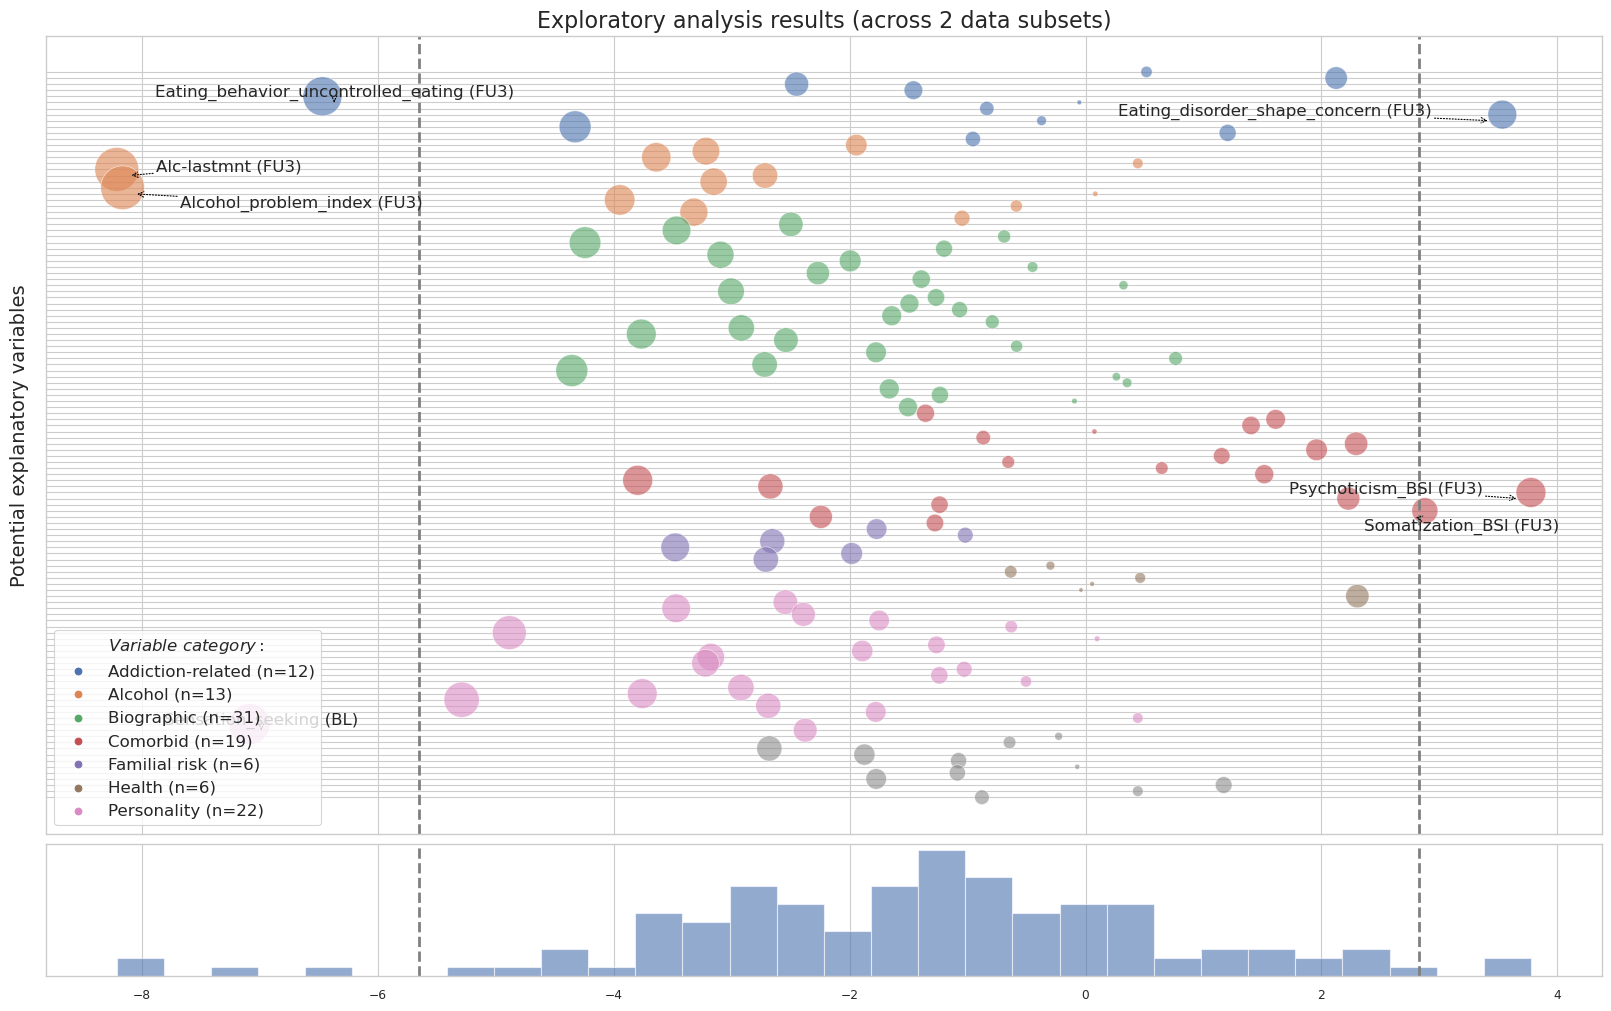

In [81]:
from adjustText import adjust_text
fig, axes = plt.subplots(nrows=2, figsize=(16,10), 
                         sharex=True, constrained_layout=True, gridspec_kw={'height_ratios': [6, 1]})


# distribution of the values to determine the threshold first
ax = axes[1]
ax.hist(df_all["Accuracy Diff CB - BL"], bins=30, alpha=0.6)
ax.set_yticks([])

ax.axvline(upper_threshold, ls='--', lw=2, c='gray')
ax.axvline(lower_threshold, ls='--', lw=2, c='gray')
# also add the lines to the previous axis
axes[0].axvline(upper_threshold, ls='--', lw=2, c='gray')
axes[0].axvline(lower_threshold, ls='--', lw=2, c='gray')

ax =axes[0]

g = sns.scatterplot(
            data=df_all,
            x="Accuracy Diff CB - BL", y="Confound", 
            hue="category", palette="deep", 
            # style="Model", markers={"SVM-rbf": "o", "GB": "D"}, ## @remove GB
            size="abs_diff", sizes=(10, 1000),
            ax=ax,# col='h5cat',
            alpha=.6)
fs=14 # fontsize
g.set_yticklabels([])
g.set_xlabel(r"Difference in Mean Balanced Accuracy ( $MBA_{post} - MBA_{pre}$ )", fontdict={'fontsize':fs})
g.set_ylabel("Potential explanatory variables", fontdict={'fontsize':fs})
g.set_title(f"Exploratory analysis results (across 2 data subsets)",
           fontdict={'fontsize':fs+2})
 
# filter out points that have large difference of either [-3% or +2%] for both models
points = g.collections[0]
points_to_show = {} # first store {point: model}
for i, point in enumerate(points.get_offsets()):
    point_info = df_all.iloc[i]
    var = point_info.Confound
    var_val = point_info['Accuracy Diff CB - BL']
    if (var_val<=lower_threshold or var_val>=upper_threshold): 
        if var not in points_to_show:
            points_to_show.update({var: (point,1)})
        else: #  (var in points_to_show)
            old_pt, old_cnt = points_to_show[var]
            # if a var is already there then only upddate the new point if
            # it has caused a greater reduction in accuracy than the existing one
            if (abs(var_val) > abs(old_pt[0])):
                points_to_show.update({var: (point, old_cnt+1)})
            else:
                points_to_show.update({var+'_2': (point, old_cnt+1)})
                
            
# annotate the points on the figure ##@@Milena comment this section if you want a plot without annotations
texts = []
for var, (point, w) in points_to_show.items():
    # print(var, w)
    sign = 1 if point[0]>=0 else -1
    ha = 'left' if sign>0 else 'right'
    var_corr = var.replace('FU3', ' (FU3)') if 'FU3' in var else var+' (BL)'
    # if it occurs in both data subsets then show a higher font size
    if var not in []: # manually exclude some annotation which are not informative
        size = (fs-2) #if var in [SELECTED_TOP_VARS, SELECTED_WRST_VARS] else (fs-4) #'bold' if w>1 else 
        txt = (g.text(point[0]-sign*0.1, point[1]+1, #texts.append
                     var_corr.replace('retrstraint', 'restraint'),  # var name corrections
                    horizontalalignment=ha, size=size)) # increase boldness of annotation if it occurs many times
        texts.append(txt)
adjust_text(texts, autoalign='y', ax=axes[0],
           arrowprops=dict(arrowstyle='->', color='k', ls=':',lw=0.8)
           )
        
# prepare the legend
n_cats = df_all.category.nunique()
hdls, lbls = g.get_legend_handles_labels()
hdls = hdls[:n_cats]
lbls = lbls[1:n_cats]
# append the number of instances in each category
lbls = [f"{lbl} (n={(df_all.category==lbl).sum()})" for lbl in lbls]
# todo  in legend of category add number of points
lbl_title = r"$\it{Variable}$ $\it{category}:$"
ax.legend(hdls, 
          [lbl_title]+lbls,
          loc='lower left', fontsize=fs-2)
            

plt.savefig(f"results/results-scatter-combined.png", bbox_inches='tight')
plt.show()

In [82]:
print("# points that crossed the threshold above: try other less conservative thresholds")
for var, (values, cnts) in points_to_show.items(): 
    print(f"{var} appeared {cnts} times. Best value {values[0]:.2f}")

# points that crossed the threshold above: try other less conservative thresholds
Eating_behavior_uncontrolled_eatingFU3 appeared 1 times. Best value -6.47
Eating_disorder_shape_concernFU3 appeared 1 times. Best value 3.53
Alc-lastmntFU3 appeared 1 times. Best value -8.22
Alcohol_problem_indexFU3 appeared 1 times. Best value -8.17
Psychoticism_BSIFU3 appeared 1 times. Best value 3.78
Somatization_BSIFU3 appeared 1 times. Best value 2.88
Sensation_seeking appeared 1 times. Best value -7.09


##### Which variables co-occur in both onset0 and onset1? Priminary adhoc analysis

In [83]:
# filter out variables below and above SD-defined threshold
df_all_top_red = df_all.loc[(df_all['Accuracy Diff CB - BL']<=(lower_threshold))].sort_values(['Accuracy Diff CB - BL'])
df_all_top_red.to_csv(f"results/results_explorative_top_red.csv", index=False)

df_all_top_incr = df_all.loc[(df_all['Accuracy Diff CB - BL']>=(upper_threshold))].sort_values(['Accuracy Diff CB - BL'])
df_all_top_incr.to_csv(f"results/results_explorative_top_incr.csv", index=False)

print(f"Top accuracy reducing variables:")
display(df_all_top_red)
print(f"Top accuracy increasing variables:")
display(df_all_top_incr)

Top accuracy reducing variables:


Confound Conf_time_point    Model  \
218                          Alc-lastmntFU3              BL  SVM-rbf   
317                Alcohol_problem_indexFU3              BL  SVM-rbf   
215                       Sensation_seeking              BL  SVM-rbf   
26   Eating_behavior_uncontrolled_eatingFU3              BL  SVM-rbf   

                                                h5name  Accuracy BL  \
218               posthoc-cc3-h5causal0-Alc-lastmntFU3    65.311358   
317     posthoc-cc3-h5causal0-Alcohol_problem_indexFU3    65.311358   
215            posthoc-cc3-h5causal0-Sensation_seeking    66.874702   
26   posthoc-cc3-h5causal0-Eating_behavior_uncontro...    61.650993   

     Std-Dev BL  Accuracy CB  Std-Dev CB  Accuracy Diff CB - BL  \
218    6.410567    57.095697    2.979281              -8.215661   
317    6.410567    57.144652    4.743399              -8.166706   
215    6.645273    59.784648    5.126935              -7.090054   
26     7.708677    55.179344    7.430372              -6.471648   

     Std-Dev Diff CB - BL      h5cat           category  abs_diff  rank  
218              5.879379  h5causal0            Alcohol  8.215661     0  
317              5.396152  h5causal0            Alcohol  8.166706     1  
215              2.750690  h5causal0        Personality  7.090054     2  
26               6.606139  h5causal0  Addiction-related  6.471648     3

Top accuracy increasing variables:


Confound Conf_time_point    Model  \
356               Somatization_BSIFU3              BL  SVM-rbf   
146  Eating_disorder_shape_concernFU3              BL  SVM-rbf   
200               Psychoticism_BSIFU3              BL  SVM-rbf   

                                                h5name  Accuracy BL  \
356          posthoc-cc3-h5causal0-Somatization_BSIFU3    63.318155   
146  posthoc-cc3-h5causal0-Eating_disorder_shape_co...    61.650993   
200          posthoc-cc3-h5causal0-Psychoticism_BSIFU3    63.318155   

     Std-Dev BL  Accuracy CB  Std-Dev CB  Accuracy Diff CB - BL  \
356    7.550864    66.195345    4.906937               2.877190   
146    7.708677    65.185102    3.946772               3.534110   
200    7.550864    67.095128    5.471563               3.776973   

     Std-Dev Diff CB - BL      h5cat           category  abs_diff  rank  
356              4.015624  h5causal0           Comorbid  2.877190   117  
146              6.631879  h5causal0  Addiction-related  3.534110   118  
200              6.421138  h5causal0           Comorbid  3.776973   119

In [78]:
# df_all_top_red_causal0 = df_all_top_red[df_all_top_red['h5cat'] == 'h5causal0']
# df_all_top_red_causal1 = df_all_top_red[df_all_top_red['h5cat'] == 'h5causal1']
# # filter out variables occuring in BL0 and BL1 dataset and and compute mean MBApost-pre
# df_both_top_red = pd.merge(df_all_top_red_causal0.reset_index(drop=True),
#                        df_all_top_red_causal1.reset_index(drop=True), 
#                        on='Confound', how='inner')
# df_both_top_red['mean_Accuracy_CB'] = df_both_top_red[['Accuracy CB_x', 'Accuracy CB_y']].mean(axis=1)
# df_both_top_red['mean_Accuracy Diff CB-BL'] = df_both_top_red[['Accuracy Diff CB - BL_x', 'Accuracy Diff CB - BL_y']].mean(axis=1)
# df_both_top_red.to_csv(f"results/results_explorative_common_top_red.csv", index=False)
# df_both_top_red

In [79]:
# df_all_top_incr_causal0 = df_all_top_incr[df_all_top_incr['h5cat'] == 'h5causal0']
# df_all_top_incr_causal1 = df_all_top_incr[df_all_top_incr['h5cat'] == 'h5causal1']
# # filter out variables occuring in BL0 and BL1 dataset and and compute mean MBApost-pre
# df_both_top_incr = pd.merge(df_all_top_incr_causal0.reset_index(drop=True),
#                        df_all_top_incr_causal1.reset_index(drop=True), 
#                        on='Confound', how='inner')
# df_both_top_incr['mean_Accuracy_CB'] = df_both_top_incr[['Accuracy CB_x', 'Accuracy CB_y']].mean(axis=1)
# df_both_top_incr['mean_Accuracy Diff CB-BL'] = df_both_top_incr[['Accuracy Diff CB - BL_x', 'Accuracy Diff CB - BL_y']].mean(axis=1)
# df_both_top_incr.to_csv(f"results/results_explorative_common_top_incr.csv", index=False)
# df_both_top_incr

### Exploratory stage conclusions
Selecting all the top reducing and top increasing variables that cross the threshold in both causal0 and causal1 splits for the generalization test

In [84]:
SELECTED_VARS = pd.read_csv("results/results_explorative_top_red.csv").Confound.values.tolist() + \
pd.read_csv("results/results_explorative_top_incr.csv").Confound.values.tolist()
                 #['Alc-lastmntFU3', 
                 # 'Alcohol_problem_indexFU3',
                 # 'Eating_behavior_uncontrolled_eatingFU3', 
                 # 'QOL_phys_unhealthy_daysFU3',
                 # 'Family_val']

In [85]:
SELECTED_VARS

['Alc-lastmntFU3',
 'Alcohol_problem_indexFU3',
 'Sensation_seeking',
 'Eating_behavior_uncontrolled_eatingFU3',
 'Somatization_BSIFU3',
 'Eating_disorder_shape_concernFU3',
 'Psychoticism_BSIFU3']

#### Save the final selected vars as a table

In [88]:
df_all_i = df_all.groupby('Model').get_group('SVM-rbf')
df_exp_selected = df_all_i[df_all_i.Confound.isin(SELECTED_VARS)]
# save in a file
df_exp_selected.to_csv("results/results_explorative_selected_confs.csv")

## Generalization tests
Do the results generalize to test data? - repeat on holdout data

### Create holdout h5files
Create holdout h5 file for BL, BLcausal1 and BLcausal0 with all confs in it <br>
@@Milena skip

In [51]:
plot_dist = False
print_all = False

In [52]:
df_conf_list = pd.read_excel("Confounds_list_Milena_v3.xlsx")

# get list of holdout subject IDs
df_participants = pd.read_csv(f"/ritter/share/data/IMAGEN/IMAGEN_BIDS/participants_BL.csv", index_col="ID")
df_participants = df_participants[df_participants['holdout']]

all_confs = pd.DataFrame(index=df_participants.index)

for i,row in df_conf_list.iterrows():
    print(f"-------------------  ({i}) {row['conf_name']}   ----------------------")
    # load the confound from corresponding questionnaire as a pandas Series
    # print(f"From {CONF_DATA_DIR+row['questionnaire']} reading column '{row['colname']}'")
    if '???' in row["questionnaire"] or '???' in row["colname"]:
        print(f"[ERROR] {row['conf_name']} missing preprocessed tables. Extract this first.")
        continue

    if 'FU' in h5_name.upper() and ('FU' not in row['time_point'].upper()) and row['subject']!='parent':
        print(f"Skipping this conf since it is not applicable for FUx timepoint analysis")
        continue

    df_conf = pd.read_csv(CONF_DATA_DIR + row["questionnaire"]).set_index('ID')

    if ('Session' in df_conf):
        conf = df_conf.loc[df_conf['Session']==row['time_point'], row['colname']] 
        if print_all: print(f"Using Q collected at session-{row['time_point']}")
    elif ('Session' in df_conf and df_conf['Session'].nunique()>1):
        conf = df_conf.loc[df_conf['Session']=='FU3', row['colname']] 
        if print_all: print(f"Using Q collected at session-FU3")
    else:
        conf = df_conf[row['colname']]
        if print_all: print(f"Using Q collected at session-???")

    # attach the timepoint to the name if it is not BL 
    conf.name = row['conf_name']
    if row['time_point'] != 'BL': 
        conf.name += row['time_point']

    # filter out only holdout sub IDs
    all_confs[conf.name] = conf
    conf = all_confs[conf.name]

    # impute missing values with given value
    if conf.isna().sum() and isinstance(row['impute_missing_with'], (int,float)):
        if print_all: print(f"imputing {conf.isna().sum()}/{len(conf)} missing values with {row['impute_missing_with']}")
        conf = conf.fillna(row['impute_missing_with'])
    elif conf.isna().sum():
        if print_all: print(f"imputing {conf.isna().sum()}/{len(conf)} missing with K-Nearest-Neighbour algorithm")
        # use KNN
        conf.loc[:] = KNNImputer().fit_transform(conf.values.reshape(-1, 1)).ravel()

    # plot conf distribution before binarizing
    if plot_dist:
        f, axes = plt.subplots(1,2, figsize=(7,3), sharey=False)
        plt.suptitle(f"{row['category']}: {conf.name.title()}")

        kwargs = dict(ax=axes[0],
            title="before binarizing", 
            xlabel='values', ylabel='counts')

        nunique = conf.nunique()

        conf.plot(
            kind='hist', bins=10 if nunique<100 else nunique//10,
            **kwargs)

        if print_all: print(
            f"range (min, mean, median, max) = ({conf.min():.2f}, {conf.mean():.2f}, {conf.median():.2f}, {conf.max():.2f})")

    # binarize 
    binarizing_threshold = conf.median() if row['binarizing_threshold']=='median' else conf.mean()
    conf = conf.apply(lambda x: int(x>binarizing_threshold))


    # plot conf distribution after binarizing
    if plot_dist:
        # draw the threshold in the prev plot
        axes[0].axvline(binarizing_threshold, c='k', ls='--', lw=2, label='binarizing threshold')
        hdls, lbls = axes[0].get_legend_handles_labels()
        axes[0].legend([hdls[0]], ['binarizing threshold={:.2f}'.format(binarizing_threshold)])

        colors = [plt.get_cmap("tab10")(v) for v in sorted(conf.unique())]
        conf.value_counts(dropna=False).sort_index().plot(
            ax=axes[1], kind='bar',
            title="after binarizing", 
            xlabel='values', ylabel='counts', color=colors)
        plt.tight_layout()
        plt.show()


    # resave confounds
    all_confs[conf.name] = conf

all_confs

-------------------  (0) Alc-lastmnt   ----------------------
-------------------  (1) Alc-last12mnt   ----------------------
-------------------  (2) Neuroticism   ----------------------
-------------------  (3) Extroversion   ----------------------
-------------------  (4) Conscientiousness   ----------------------
-------------------  (5) Openness   ----------------------
-------------------  (6) Agreeableness   ----------------------
-------------------  (7) Family_freq   ----------------------
-------------------  (8) Family_val   ----------------------
-------------------  (9) Accident_freq   ----------------------
-------------------  (10) Accident_val   ----------------------
-------------------  (11) Sexuality_freq   ----------------------
-------------------  (12) Sexuality_val   ----------------------
-------------------  (13) Autonomy_freq   ----------------------
-------------------  (14) Autonomy_val   ----------------------
-------------------  (15) Deviance_freq   -----

/tmp/ipykernel_814234/3782893452.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_confs[conf.name] = conf
/tmp/ipykernel_814234/3782893452.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_confs[conf.name] = conf
/tmp/ipykernel_814234/3782893452.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = fra

-------------------  (108) Autonomy_freq   ----------------------
-------------------  (109) Autonomy_val   ----------------------
-------------------  (110) Deviance_freq   ----------------------
-------------------  (111) Deviance_val   ----------------------
-------------------  (112) Relocation_freq   ----------------------
-------------------  (113) Relocation_val   ----------------------
-------------------  (114) Distress_freq   ----------------------
-------------------  (115) Distress_val   ----------------------
-------------------  (116) Total_freq   ----------------------
-------------------  (117) Total_val   ----------------------
-------------------  (118) Psychiatric_symptoms_PHQ   ----------------------
-------------------  (119) Social_difficulties   ----------------------
-------------------  (120) Social_difficulties_impact   ----------------------
-------------------  (121) Prosocial_behavior   ----------------------
-------------------  (122) Bullying   ----------

/tmp/ipykernel_814234/3782893452.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_confs[conf.name] = conf
/tmp/ipykernel_814234/3782893452.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_confs[conf.name] = conf
/tmp/ipykernel_814234/3782893452.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = fra

-------------------  (125) Drug_abuse_screening_parent   ----------------------
-------------------  (126) Conflict_tactics_parent_mean_assault   ----------------------
-------------------  (127) Conflict_tactics_parent_mean_injury   ----------------------
-------------------  (128) Conflict_tactics_parent_mean_negotiation   ----------------------
-------------------  (129) Conflict_tactics_parent_mean_psych_aggr   ----------------------
-------------------  (130) Conflict_tactics_parent_sexual_coercion   ----------------------
-------------------  (131) Fam_hist_psych_disorders_parent   ----------------------
-------------------  (132) PBQ_cigarettes_pregnancy   ----------------------
-------------------  (133) PBQ_cigarettes_breastfeeding   ----------------------
-------------------  (134) PBQ_pres_meds   ----------------------
-------------------  (135) PBQ_unpres_meds   ----------------------
-------------------  (136) PBQ_drugs   ----------------------
-------------------  (137) A

/tmp/ipykernel_814234/3782893452.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_confs[conf.name] = conf
/tmp/ipykernel_814234/3782893452.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_confs[conf.name] = conf
/tmp/ipykernel_814234/3782893452.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = fra

Alc-lastmnt  Alc-last12mnt  Neuroticism  Extroversion  \
ID                                                                
240546              0              0            0             1   
1163495             0              0            0             0   
1938036             1              1            0             1   
2103894             0              0            0             0   
2766073             1              1            1             1   
...               ...            ...          ...           ...   
98671905            1              1            1             1   
99217838            0              0            0             1   
99677574            0              0            0             1   
99875982            0              0            1             1   
99954902            0              0            1             0   

          Conscientiousness  Openness  Agreeableness  Family_freq  Family_val  \
ID                                                                              
240546                    0         1              1            0           0   
1163495                   1         0              1            0           1   
1938036                   0         1              1            1           1   
2103894                   0         1              1            1           0   
2766073                   0         1              1            0           0   
...                     ...       ...            ...          ...         ...   
98671905                  0         1              1            1           1   
99217838                  0         1              0            0           0   
99677574                  1         0              1            0           0   
99875982                  0         1              0            0           0   
99954902                  1         1              1            0           0   

          Accident_freq  ...  Conflict_tactics_parent_mean_negotiation  \
ID                       ...                                             
240546                1  ...                                         1   
1163495               0  ...                                         0   
1938036               1  ...                                         1   
2103894               1  ...                                         1   
2766073               1  ...                                         0   
...                 ...  ...                                       ...   
98671905              1  ...                                         0   
99217838              1  ...                                         1   
99677574              1  ...                                         0   
99875982              1  ...                                         0   
99954902              1  ...                                         1   

          Conflict_tactics_parent_mean_psych_aggr  \
ID                                                  
240546                                          0   
1163495                                         0   
1938036                                         1   
2103894                                         0   
2766073                                         0   
...                                           ...   
98671905                                        0   
99217838                                        0   
99677574                                        0   
99875982                                        0   
99954902                                        0   

          Conflict_tactics_parent_sexual_coercion  \
ID                                                  
240546                                          0   
1163495                                         0   
1938036                                         0   
2103894                                         0   
2766073                                         0   
...                                           ...   
9867190

In [31]:
# add binge itself as a conf
def attach_conf_from_df(H5_DIR, to_h5, conf_table, prepend='h5causal1-allconfs', print_all=True):
    
    conf_table = conf_table.sort_index()
    
    # create a new h5 file name
    out_h5 = '-'.join([rerun_ver,prepend])+'.h5'
    if print_all: print("writing to ..", out_h5)
    assert not os.path.exists(H5_DIR+out_h5), "[ERROR] file already exists.. skipping h5file creation. Remove it manually first"

    with h5py.File(H5_DIR+out_h5, 'w') as data_out:
        # first just copy all h5 file data to new h5 file    
        with h5py.File(H5_DIR+to_h5, 'r') as data_dest:
            for dataset in data_dest:
                data_out.create_dataset(dataset, data=data_dest[dataset]) 
            for attr in data_dest.attrs:
                data_out.attrs[attr]=data_dest.attrs[attr]

        for conf_name, conf in conf_table.items():
                # now add the confound
                if conf_name not in data_out.attrs['confs']:

                    if print_all: print(f"attaching conf {conf_name}")
                    data_out.attrs['confs'] = list(data_out.attrs['confs'])+[conf_name]
                    # align the subject IDs to fill the right conf value for each subject in the h5
                    h5_sub_ids = data_out['i'][:]
                    # below script works only if the IDs in src data h5 are arranged in an ascending order
                    assert np.all(h5_sub_ids[:-1] <= h5_sub_ids[1:]), f"subject IDs in {to_h5} are not in ascending order.. change the algo below ?!"
                    conf = conf.sort_index()
                    h5_sub_ids_in_conf = np.argwhere(np.isin(h5_sub_ids, conf.index)).ravel()
                    conf_sub_ids_in_h5 = np.argwhere(np.isin(conf.index, h5_sub_ids)).ravel()
                    assert len(h5_sub_ids_in_conf)==len(conf_sub_ids_in_h5)
                    data_out.create_dataset(conf_name, data=conf.iloc[conf_sub_ids_in_h5]) 
                
                    # check if the distribution of confound is acceptable
                    if not conf.iloc[conf_sub_ids_in_h5].nunique()==2:
                        print(f"[ERROR] Failed to create h5: conf '{conf_name}' has n_classes= \
{conf.iloc[conf_sub_ids_in_h5].nunique()}. If n_classes>2 then it was not correctly\
binarized. If n_classes=1 then all subjects are getting categorized into a single class.")
                        continue
                              
                    for val,counts in conf.iloc[conf_sub_ids_in_h5].value_counts().iteritems():
                        if not counts>=0.15*len(conf_sub_ids_in_h5):
                            print(f"[ERROR] Failed to create h5: the value {val} in {conf_name}\
has fewer than 15% instances (n={counts})\nThis is very small for counter balancing to work properly..")
                            continue

                    # remove subject IDs missing the conf info
                    if len(h5_sub_ids_in_conf)<len(h5_sub_ids):

                        print(f"[WARN] n={len(h5_sub_ids)-len(h5_sub_ids_in_conf)} subs missing this conf information. \
    Dropping sample size from {len(h5_sub_ids)} to {len(h5_sub_ids_in_conf)}")
                        existing_datasets = list(data_out.keys())
                        existing_datasets.remove(conf_name)
                        # if print_all: print(f"Removing subjects with missing value from {existing_datasets}")
                        for existing_dataset in existing_datasets:
                            new_data = data_out[existing_dataset][h5_sub_ids_in_conf] 
                            del data_out[existing_dataset] 
                            data_out.create_dataset(existing_dataset, data=new_data) 

In [ ]:
h5_names =  'h5causal0', 'h5causal1']#, 'h5fu3', 'h5bl'
for h5_name in h5_names:
    h5_src_hold = H5_FILES_HOLD[h5_name] 
    # attach conf to the h5 file
    attach_conf_from_df(H5_DIR, h5_src_hold, conf_table=all_confs, prepend='holdout-'+h5_name, print_all=print_all)


In [64]:
hold_h5s = glob(H5_DIR+f"/{rerun_ver}-holdout*.h5")
hold_h5s

['/ritter/share/data/IMAGEN/h5files/posthoc-cc2-holdout-h5causal1.h5',
 '/ritter/share/data/IMAGEN/h5files/posthoc-cc2-holdout-h5causal0.h5',
 '/ritter/share/data/IMAGEN/h5files/posthoc-cc2-holdout-h5bl.h5']

______________________________________________________________________________________
filename: posthoc-cc2-h5bl-Eating_disorder_weight_concernFU3.h5 
 h5.columns = ['Binge', 'Eating_disorder_weight_concernFU3', 'X', 'i', 'sex', 'site'] 
 h5.attrs = ['X_col_names', 'confs', 'labels']
n = 553 	 label = Binge 	 X.shape = (553, 719)  	 confs = ['sex', 'site', 'Eating_disorder_weight_concernFU3']
label and conf with distributions:


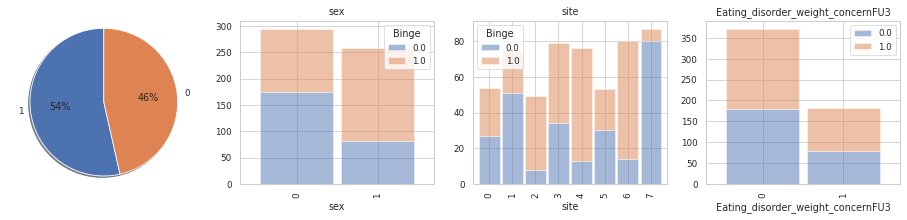


subject: 13148228 	 (min=0.00, mean=17798.66, max=1591918.00)
conf Eating_disorder_weight_concernFU3 == label Binge ? 	 True for n=282/553


In [75]:
check_h5_contents([f"/ritter/share/data/IMAGEN/h5files/{rerun_ver}-h5bl-Eating_disorder_weight_concernFU3.h5"])

In [112]:
# ! ls ../MLpipelines/results/{rerun_ver}-h5bl-*/*/run.csv | wc -l

### Holdout conf-permute tests


for difference: (a) random conf distribution vs our confs (b) 1 sample t-test comparing the 7-fold accuracies before controlling for confound $C$ vs after controlling $C$. -> do significance tests on the holdout data


------------------------------
causal1
------------------------------
mean: [65.80% - 65.80%]
50% interval: [64.39% - 67.21%]
75% interval: [63.39% - 68.20%]
95% interval: [61.62% - 69.98%]
------------------------------
causal0
------------------------------
mean: [67.46% - 67.46%]
50% interval: [65.70% - 69.22%]
75% interval: [64.45% - 70.47%]
95% interval: [62.23% - 72.69%]


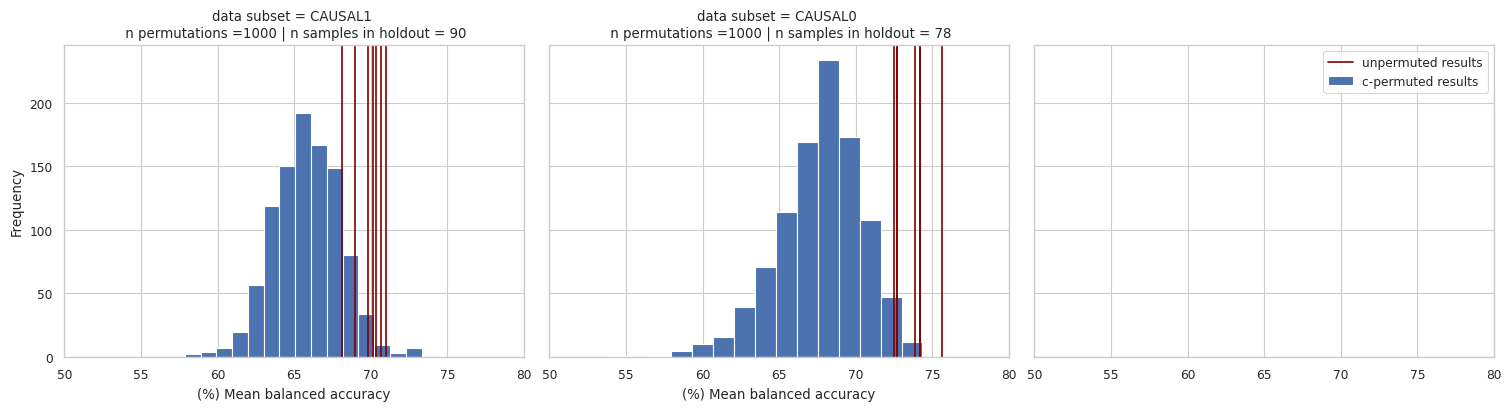

In [30]:
df = pd.read_csv(RESULTS_DIR + f"holdout-{rerun_ver}-permuted_run.csv")

f, axes = plt.subplots(1,3, figsize=(15,4),
                       sharey=True, sharex=True,
                       constrained_layout=True)

for i, (cat, dfi) in enumerate(df.groupby('h5cat', sort=False)):
    ax = axes[i]
    print(f"{'-'*30}\n{cat}\n{'-'*30}")
    # draw the original results as lines
    unpermuted_results = pd.read_csv(MAP_H5CAT_TO_HOLDRUN['h5'+cat])
    unpermuted_results = unpermuted_results[(unpermuted_results.tp == 'bl') & (unpermuted_results.model == 'SVM-rbf')]
    unpermuted_results.holdout_score *= 100
    for old_score in unpermuted_results.holdout_score:
        ax.axvline(old_score, ls ='-', color='maroon', label='unpermuted results')
        
    # get the number of samples in the holdout data from the h5file and prepare the title
    with h5py.File(dfi.hold_h5.unique()[0]) as h5_f:
        n_samples = len(h5_f['X'])
    title = f"data subset = {cat.upper()} \n n permutations ={len(dfi)} | n samples in holdout = {n_samples}"
    
    # permuted results
    # mul by 100 for percentage
    dfi.holdout_score = dfi.holdout_score *100
    ax = dfi.holdout_score.plot.hist(bins=15, ax=ax, title=title, label='c-permuted results')
    ax.set_xlim([50,80])
    ax.set_xlabel("(%) Mean balanced accuracy")
    
    # draw the percentiles 
    perm_scores = dfi.holdout_score.values
    mean_ls, std50_ls, std75_ls, std95_ls = 'solid', 'dashed', 'dashdot', 'dotted'
    for std_scale, ls in [(0,mean_ls), (0.6744898,std50_ls), (1.1503,std75_ls), (2,std95_ls)]:
        label = {0:'mean', 0.6744898:'50% interval', 1.1503:'75% interval', 2:'95% interval'}[std_scale]
        print(f"{label}: [{(np.mean(perm_scores)-std_scale*np.std(perm_scores)):.2f}% - {(np.mean(perm_scores)+std_scale*np.std(perm_scores)):.2f}%]")
        # ax.axvline((np.mean(perm_scores) + std_scale*np.std(perm_scores)), 
        #            color='k', lw=2, ls=ls, label=label)      
        # ax.axvline((np.mean(perm_scores) - std_scale*np.std(perm_scores)), 
        #            color='k', lw=2, ls=ls)

hdls, lbls = ax.get_legend_handles_labels()
plt.legend(hdls[6:], lbls[6:])
plt.savefig(f"results/results-permutations.png", bbox_inches='tight')
plt.show()

### Holdout results

In [90]:
df_results = pd.read_csv(RESULTS_DIR +f"/holdout-{rerun_ver}_run.csv")
# multiply scores by 100
for col in df_results.filter(like='_score'):
    df_results[col] = df_results[col]*100

title_map = {'causal0': 'Baseline-binge-0 (n=477)',
             'causal1': 'Baseline-binge-1 (n=565)'
            } ## @remove BL

valid_confs = pd.read_csv("results/results_explorative_selected_confs.csv")[['h5cat','Confound']]
valid_confs

h5cat                                Confound
0  h5causal0  Eating_behavior_uncontrolled_eatingFU3
1  h5causal0        Eating_disorder_shape_concernFU3
2  h5causal0                          Alc-lastmntFU3
3  h5causal0                Alcohol_problem_indexFU3
4  h5causal0                     Psychoticism_BSIFU3
5  h5causal0                     Somatization_BSIFU3
6  h5causal0                       Sensation_seeking

Data subset = causal1 
 --------------------- 


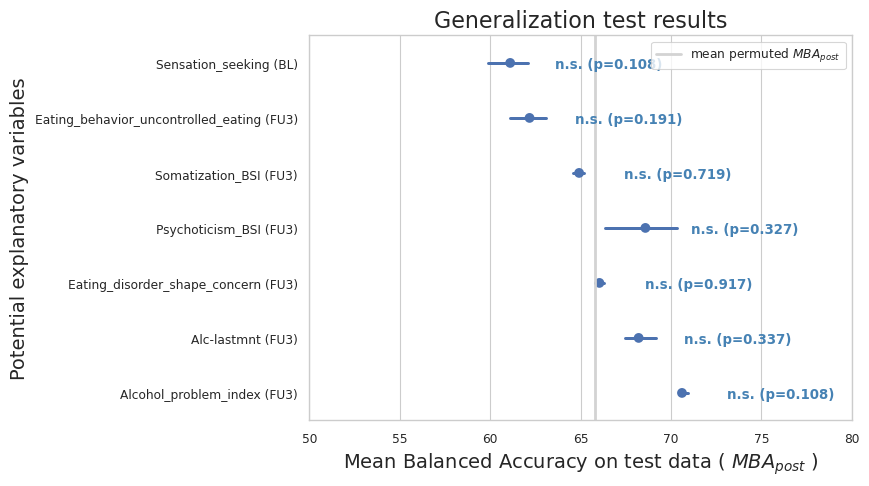

Confound  MBA_post-mean  MBA_post-std  \
0                          Alc-lastmnt (FU3)      68.210908      1.319042   
1                Alcohol_problem_index (FU3)      70.607267      0.460932   
2  Eating_behavior_uncontrolled_eating (FU3)      62.177345      1.475876   
3        Eating_disorder_shape_concern (FU3)      66.042096      0.366019   
4                     Psychoticism_BSI (FU3)      68.584228      2.743847   
5                     Sensation_seeking (BL)      61.107161      1.622672   
6                     Somatization_BSI (FU3)      64.918581      0.452993   

   MBA_post-minus-pre-mean  MBA_post-minus-pre-std  
0                67.511995                1.218751  
1                69.908354                0.423554  
2                61.478432                1.367045  
3                65.343183                0.338180  
4                67.885315                2.543092  
5                60.408247                1.504303  
6                64.219667                0.423539

Data subset = causal0 
 --------------------- 


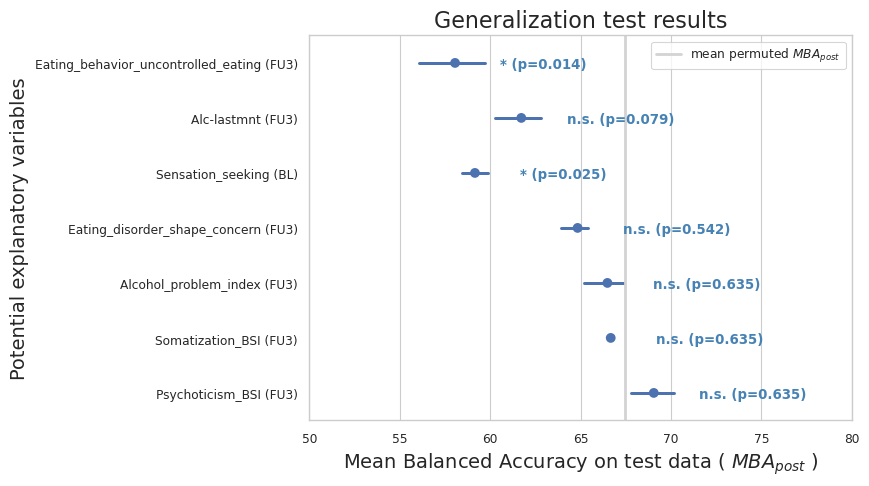

/ritter/roshan/installations/anaconda3/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Confound  MBA_post-mean  MBA_post-std  \
0                          Alc-lastmnt (FU3)      61.721612      2.017425   
1                Alcohol_problem_index (FU3)      66.483516      1.724597   
2  Eating_behavior_uncontrolled_eating (FU3)      58.058608      2.741141   
3        Eating_disorder_shape_concern (FU3)      64.835165      1.008713   
4                     Psychoticism_BSI (FU3)      69.047619      1.876731   
5                     Sensation_seeking (BL)      59.157509      1.153507   
6                     Somatization_BSI (FU3)      66.666667      0.000000   

   MBA_post-minus-pre-mean  MBA_post-minus-pre-std  
0                60.984774                1.873624  
1                65.746679                1.598967  
2                57.321770                2.542819  
3                64.098327                0.939758  
4                68.310781                1.745740  
5                58.420671                1.075090  
6                65.929829                     NaN

In [91]:
from scipy.stats import t

# f, axes = plt.subplots(2,1, figsize=(10,8), 
#                        sharex=True, sharey=True, 
#                        constrained_layout=True)
# axes = axes.ravel()
for cat, df_results_i in df_results.groupby('h5cat', sort=False):
    if cat in title_map.keys():
        # filter only selected confs
        valid_confs_i = valid_confs.Confound.unique().tolist()
        # valid_confs_i = valid_confs.loc[valid_confs.h5cat.str.replace('h5','')==cat.replace('h5','')].Confound
        # filter out model
        df_results_i = df_results_i.groupby('model').get_group('SVM-rbf')  
        df_results_i = df_results_i.loc[df_results_i.conf.isin(valid_confs_i)]
        # rename variables 
        df_results_i.conf = df_results_i.conf.apply(lambda x: x.replace('FU3', ' (FU3)') if 'FU3' in x else x+' (BL)')
        df_results_i = df_results_i.sort_values(['holdout_score'])
        
        f, ax = plt.subplots(figsize=(7,5))
        g = sns.pointplot(data=df_results_i, 
                      x='holdout_score', y='conf', 
                      # hue='model', hue_order=['SVM-rbf', 'GB'], ##@remove
                      ax=ax, 
                      dodge=True, join=False
                     )

        # plot the permutation results
        df_perm = pd.read_csv(f"../MLpipelines/results/holdout-{rerun_ver}-permuted_run.csv")
        df_perm = df_perm[df_perm.h5cat==cat]
        
        # get the pre-control scores:
        cat_map = {'causal0': 'causal-onset0',
                   'causal1': 'causal-onset1'}
        MBA_pre = pd.read_csv(f"../MLpipelines/results/holdout-{cat_map[cat]}_run.csv").groupby('model').get_group('SVM-rbf')['holdout_score']
        assert len(MBA_pre)==7
        # difference between MBApost and MBApre for permutation scores
        perm_scores = (df_perm.holdout_score.values - MBA_pre.mean())
        perm_score_mean = perm_scores.mean()
        perm_scores = perm_scores-perm_score_mean
        # iter over all accuracy means
        points = g.collections[0]
        p_vals = []
        for i, point in enumerate(points.get_offsets()):
            # 2-tailed p-value calculation is correct? --> I adapted it based on this website: https://thomasleeper.com/Rcourse/Tutorials/permutationtests.html
            # difference between one empirical MBApost and permute mean
            true_score = (point[0]/100 - MBA_pre.mean()) - perm_score_mean 
            C = np.sum(abs(perm_scores) > abs(true_score))
            p_val = C/(len(perm_scores))
            p_vals.append((point,p_val))
            
        # multiple comparison correction
        from statsmodels.stats.multitest import multipletests
        _,p_vals_corr,_,_ = multipletests(list(zip(*p_vals))[1], method="fdr_bh")
        
        for i,(point, p_val) in enumerate(p_vals):
            p_val = p_vals_corr[i]
            g.text(point[0]+2.5, point[1]+0.1, #texts.append
                   f"{return_asterisks(p_val)} (p={p_val:.3f})",
                    color='steelblue', weight='bold')
            
        # compute mean MBApost of permscores for figure
        perm_scores_post = df_perm.holdout_score.values
        perm_score_mean_post = perm_scores_post.mean()
        perm_scores_post = perm_scores_post-perm_score_mean_post
        g.axvline((perm_score_mean_post)*100, 
                  color='lightgrey', lw=2, label='mean permuted $MBA_{post}$')
        
        fs=14 # fontsize
        g.set_xlabel(r"Mean Balanced Accuracy on test data ( $MBA_{post}$ )", fontdict={'fontsize':fs})
        g.set_ylabel("Potential explanatory variables", fontdict={'fontsize':fs})
        g.set_title(f"Generalization test results",
                   fontdict={'fontsize':fs+2})
        g.set_xlim([50,80])
        g.legend()
            
        # plt.savefig(f"results/results-holdout-{cat}.png", bbox_inches='tight')
        print(f"Data subset = {cat} \n --------------------- ")
        plt.show()
        
        # save the results table
        scores = df_results_i[['conf','holdout_score']].groupby('conf')
        df_results_i_out = scores.mean()
        df_results_i_out["MBA_post-std"] = scores.std()
        df_results_i_out["MBA_post-minus-pre-mean"] = df_results_i_out["holdout_score"] - MBA_pre.mean()
        df_results_i_out["MBA_post-minus-pre-std"] = scores.apply(lambda MBA_post: std_dev_diff(
            MBA_post['holdout_score'].values, MBA_pre.values))
        df_results_i_out = df_results_i_out.reset_index().rename(columns={'conf':'Confound', 'holdout_score':'MBA_post-mean'})
        # display(df_results_i_out)
        # df_results_i_out.to_csv("results/results_gen.csv")
        display(df_results_i_out)

## plot accuracy sMRI -> confounds

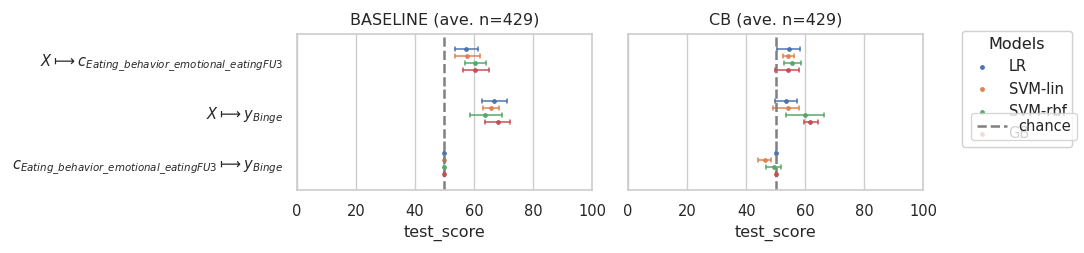

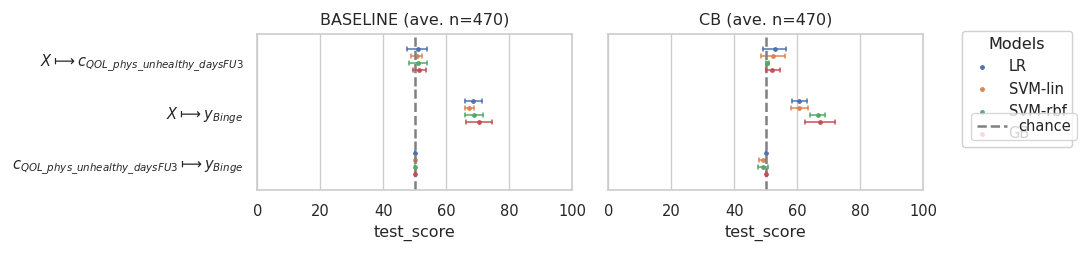

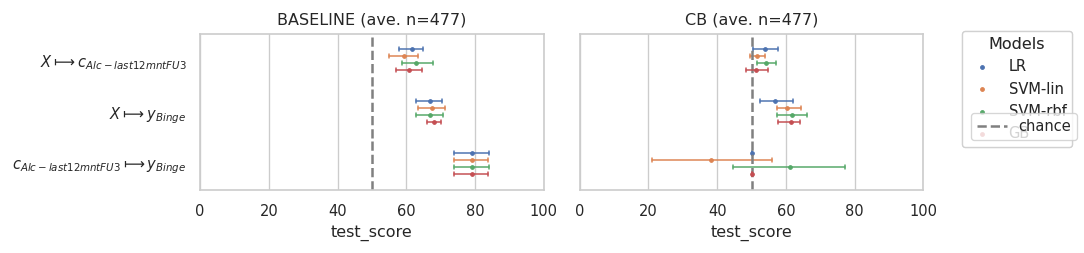

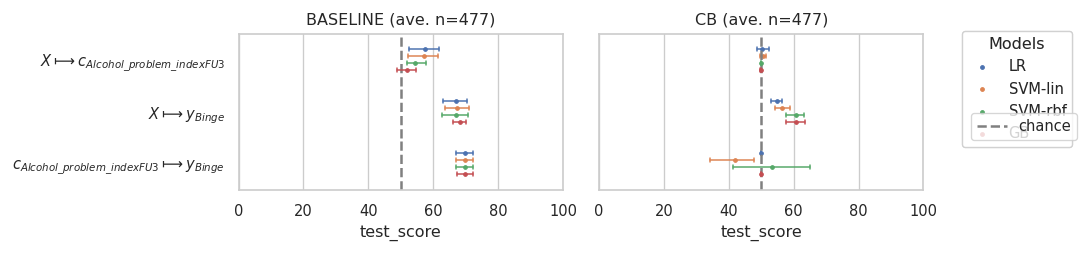

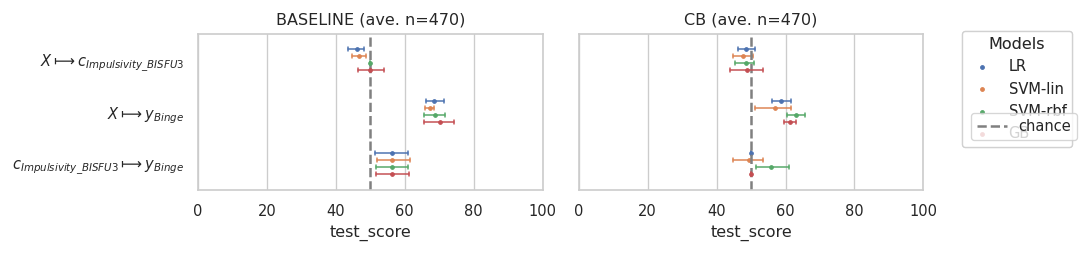

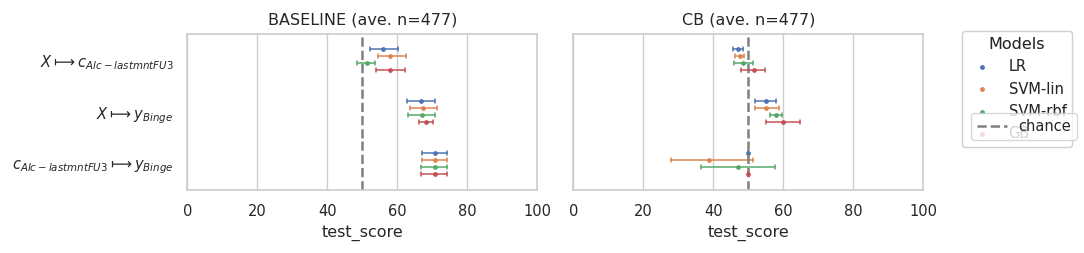

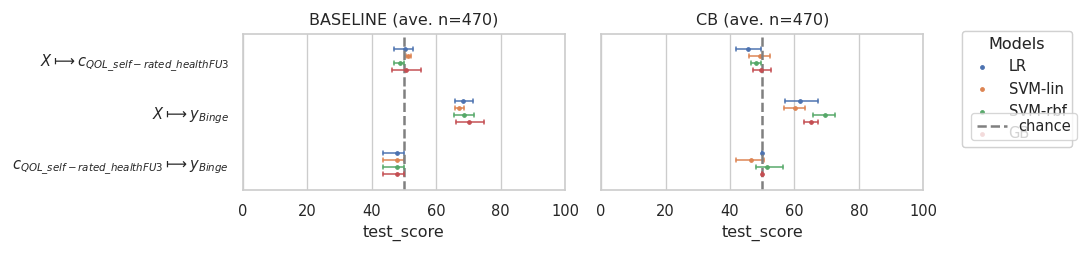

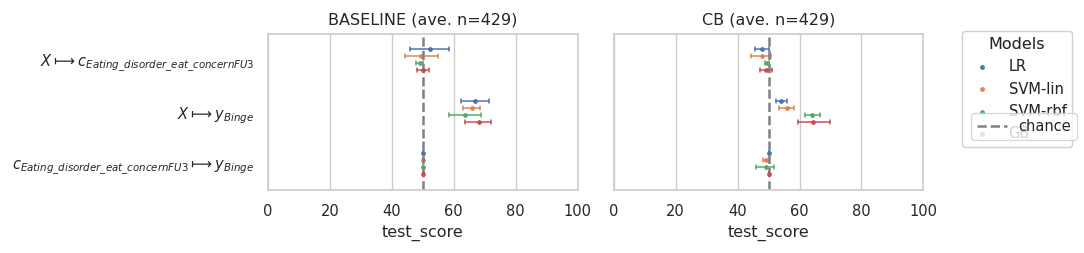

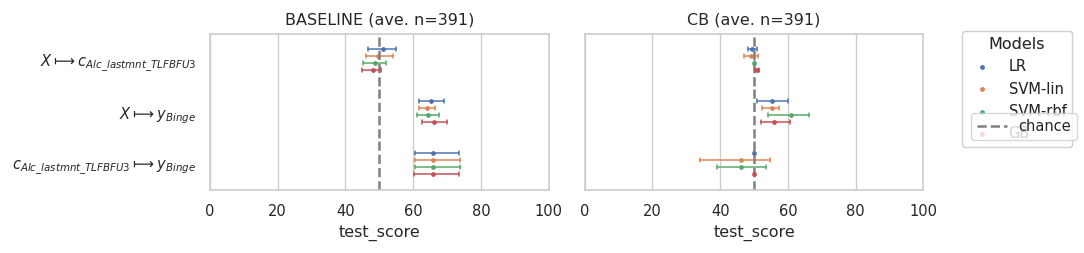

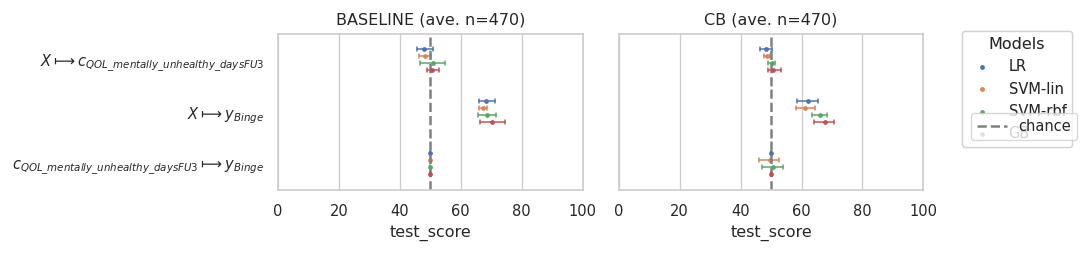

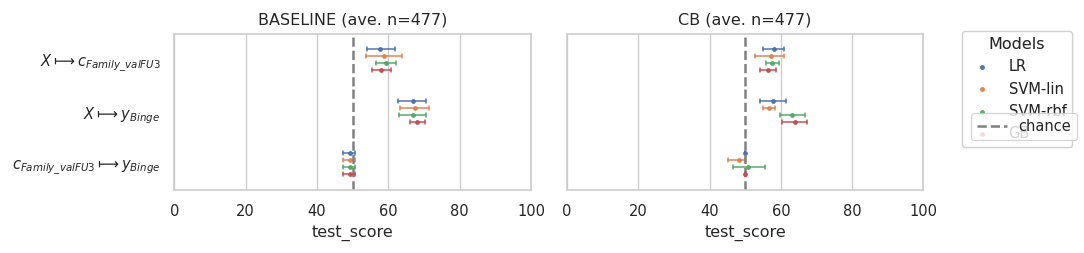

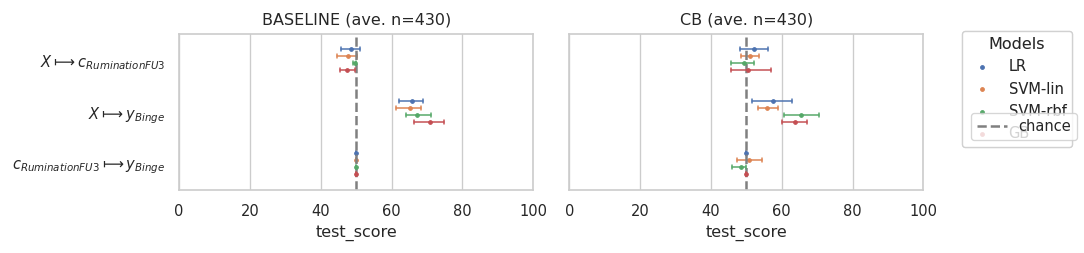

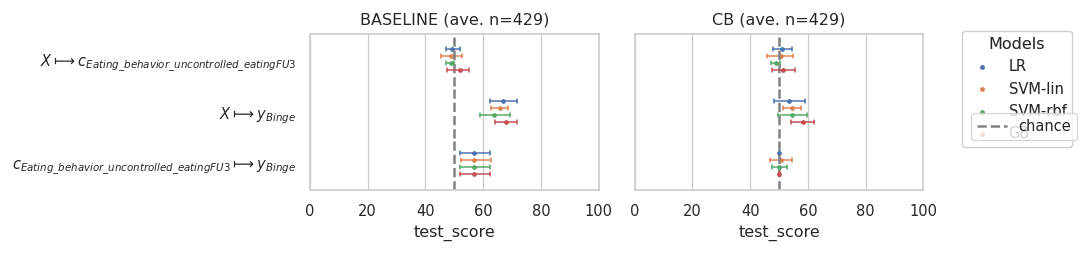

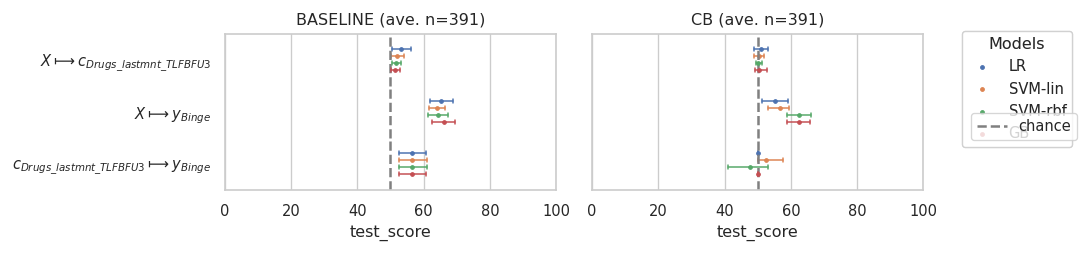

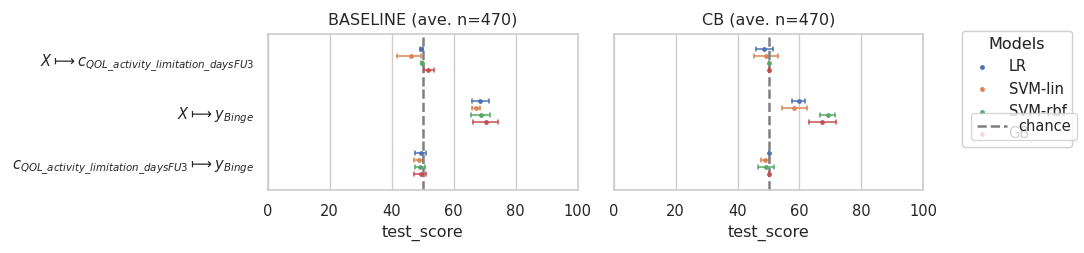

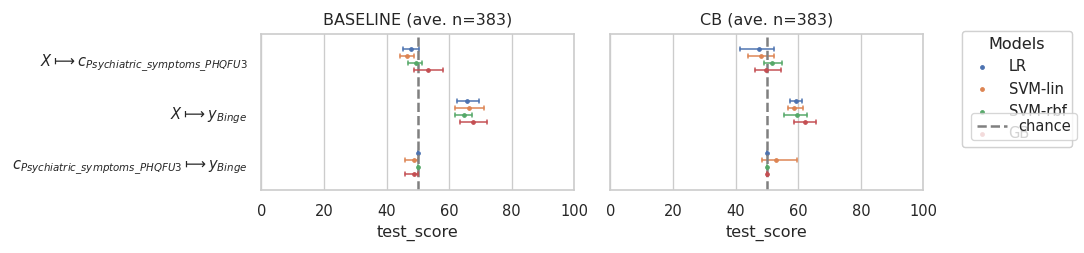

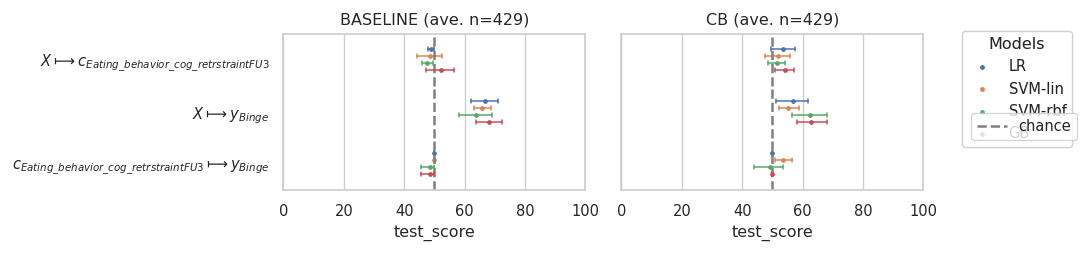

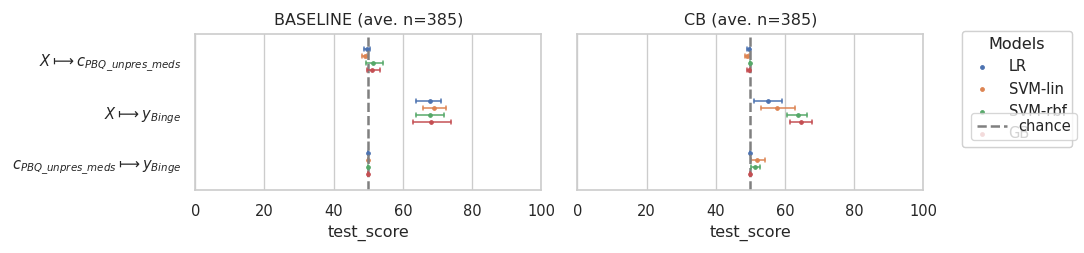

In [32]:
# plot all results from controlling for specific interesting variables
for causal in ["causal"]: #, "causal1"
    # print results of all models trained on 20221122
    for result in (glob(f"../MLpipelines/results/{rerun_ver}-h5*{causal}*/20221122-*/run.csv")):
        df = pd.read_csv(result)
        plot_result(df, x="test_score", no_confs=False)
        plt.show()

In [130]:
# for result in (glob("../MLpipelines/results/newlbls-posthoc2-*/*/run.csv")):
#     df = pd.read_csv(result)
#     plot_result(df, x="test_score", no_confs=False)
#     plt.show()

## Secondary Analysis

### Correlation analysis
Among the variables selected during explorative stage, check which variables are highly correlated and capture the same/similar information

In [10]:
TOP_INC_VARS = pd.read_csv("results/results_explorative_common_top_incr.csv").Confound.tolist()
TOP_RED_VARS = pd.read_csv("results/results_explorative_common_top_red.csv").Confound.tolist()
VARS_TO_CORR = TOP_INC_VARS + TOP_RED_VARS
print("checking the correlation for n= {} variables".format(len(VARS_TO_CORR)))

checking the correlation for n= 10 variables


In [11]:
VARS_TO_CORR

['Tobacco_lastmnt_TLFBFU3',
 'Depression_BSIFU3',
 'Hostility_BSIFU3',
 'Drugs_lastmnt_TLFBFU3',
 'Alc-lastmntFU3',
 'Alcohol_problem_indexFU3',
 'Sensation_seeking',
 'Smoking_lifetimeFU3',
 'Autonomy_freq',
 'Alc-last12mntFU3']

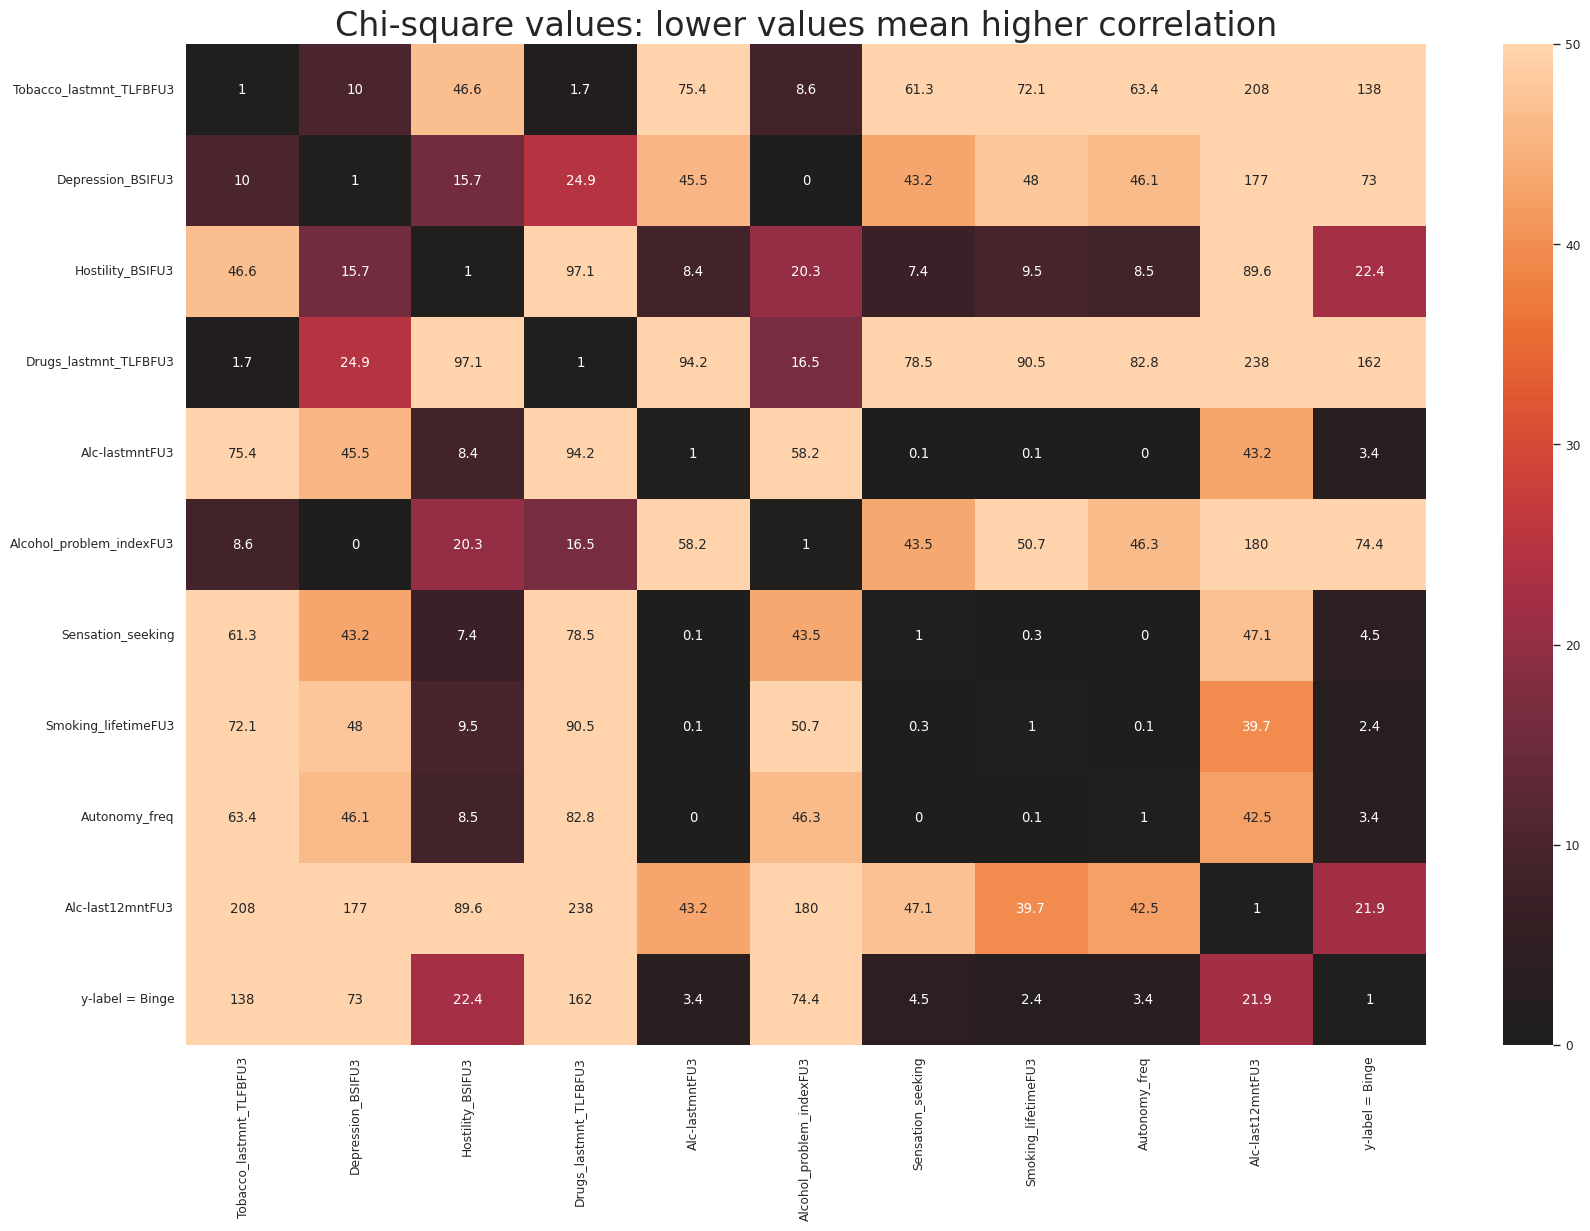

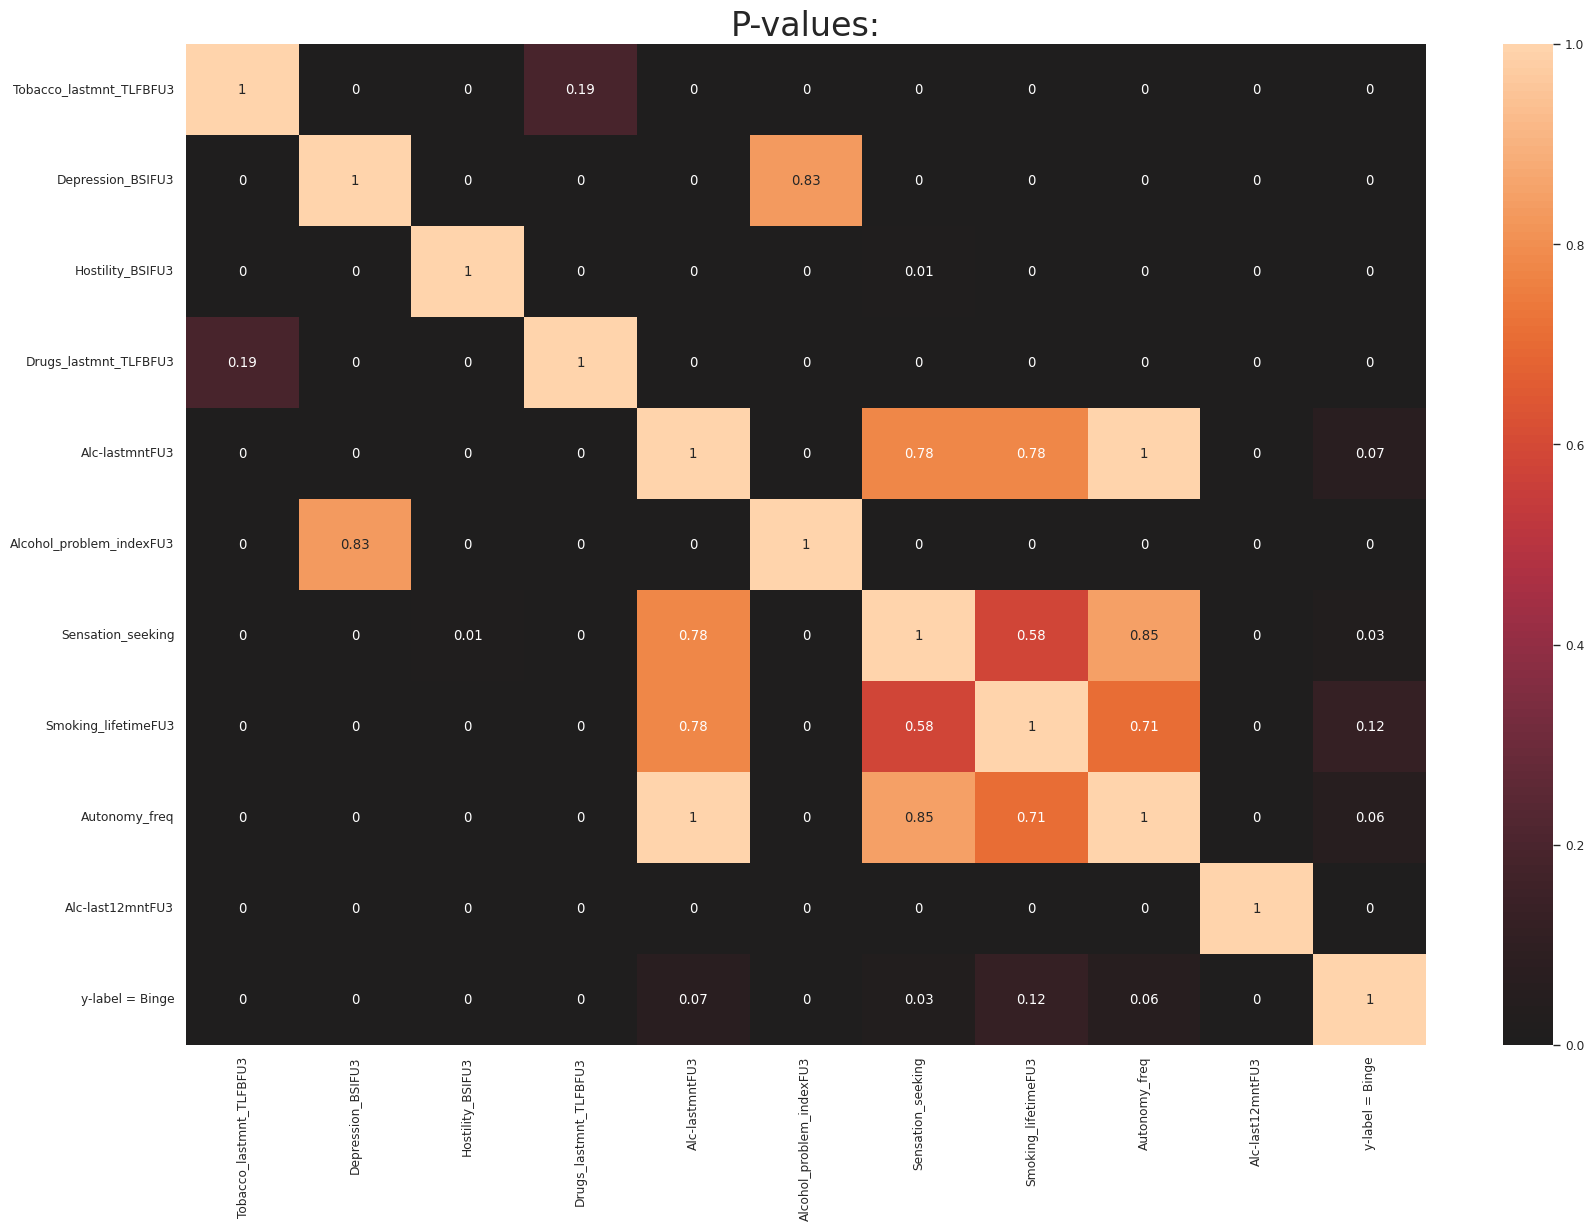

In [12]:
all_posthoc_h5s = glob(H5_DIR+f"/{rerun_ver}-h5causal0-*.h5")

# get the variable's values
with h5py.File(H5_DIR+H5_FILES['h5bl'], 'r') as f:
    ids = f['i'][:]
df_var_vals = pd.DataFrame(index=ids)

for var in VARS_TO_CORR:
    h5 = [h5 for h5 in all_posthoc_h5s if var in h5]
    if len(h5)==2 and 'FU3' not in var:
        h5 = [h5_i for h5_i in h5 if 'FU3' not in h5_i]
    assert len(h5)==1, f"For var = {var}, too many h5files were found = {h5}"
    with h5py.File(h5[0], 'r') as f:
        var_val = pd.Series(data=f[var][:], index=f['i'][:])
        df_var_vals[var] = var_val

# add the label first
with h5py.File(h5[0], 'r') as f:
    var_val = pd.Series(data=f['Binge'][:], index=f['i'][:])
    df_var_vals['y-label = Binge'] = var_val
    
# calculate correlation between all binary variables
def chi_sq(var_a, var_b):
    _, var_a_cnts = np.unique(var_a, return_counts=True)
    _, var_b_cnts = np.unique(var_b, return_counts=True)
    chi, p = stats.chisquare(var_a_cnts, var_b_cnts, ddof=0)
    return float(f"{chi:0.1f}")
def chi_sq_p(var_a, var_b):
    _, var_a_cnts = np.unique(var_a, return_counts=True)
    _, var_b_cnts = np.unique(var_b, return_counts=True)
    chi, p = stats.chisquare(var_a_cnts, var_b_cnts, ddof=0)
    return float(f"{p:0.2f}")
    
corr = df_var_vals.corr(chi_sq)
# mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 13))
# Generate a custom diverging colormap
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, center=0, vmax=50, fmt='.3g', annot=True)
plt.title("Chi-square values: lower values mean higher correlation", fontsize=24)
plt.show()

## PLOT the p values
corr = df_var_vals.corr(chi_sq_p)

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 13))
# Generate a custom diverging colormap
# cmap = sns.diverging_palette(230, 20, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, center=0, vmin=0, vmax=1, annot=True)
plt.title("P-values:", fontsize=24)
plt.show()

#### Prediction performance in co-morbid binge-eating and binge-drinking groups

In [91]:
df_preds = pd.DataFrame(index=df_var_vals.index)
df_preds['y_true2'] = df_var_vals['y-label = Binge']

for col in ['Eating_behavior_uncontrolled_eatingFU3', 'Eating_behavior_emotional_eatingFU3', 'Eating_behavior_cog_retrstraintFU3']:
    df_preds[col] = df_var_vals[col]

In [92]:
dfi = pd.read_csv(MAP_H5CAT_TO_RUN['h5causal0']).groupby('model').get_group('SVM-rbf').groupby('technique').get_group('cb')

ids_all = np.array([id_lists for ids in dfi["test_ids"] for id_lists in eval(ids)])
assert ids_all.shape[0] == np.unique(ids_all).shape[0]
y_all = np.array([y_lists for y in dfi["test_lbls"] for y_lists in eval(y)])
probs_all = np.array([prob_lists for probs in dfi["test_probs"] for prob_lists in eval(probs)])
assert probs_all.shape[0] == y_all.shape[0]
y_preds = (probs_all[:,1]>0.5).astype(int)
# y_preds = pd.Series(data=y_preds, index=ids_all)
df_preds['y_true'] = pd.Series(data=y_all, index=ids_all)
df_preds['y_pred'] = pd.Series(data=y_preds, index=ids_all)
assert (df_preds.dropna()['y_true'].eq(df_preds.dropna()['y_true2'])).all()

df_preds = df_preds.drop(columns=['y_true2']).dropna()

In [102]:
# get accuracy per subgroup

for col in ['Eating_behavior_uncontrolled_eatingFU3', 'Eating_behavior_emotional_eatingFU3', 'Eating_behavior_cog_retrstraintFU3']:
    display(col)
    df_preds['subgrp'] = df_preds.apply(lambda row: f"BDE {row['y_true']}  EatingVar {row[col]}", axis=1)
    df_print = df_preds['subgrp'].value_counts().sort_index().to_frame()
    for subgrp_i, dfi in df_preds.groupby('subgrp'):
        acc = dfi['y_true'].eq(dfi['y_pred']).sum()/len(dfi)
        df_print.loc[subgrp_i, 'acc'] = f"{acc*100:.2f}%"
    display(df_print)
    

'Eating_behavior_uncontrolled_eatingFU3'

subgrp     acc
BDE 0.0  EatingVar 0.0     141  62.41%
BDE 0.0  EatingVar 1.0      90  74.44%
BDE 1.0  EatingVar 0.0      94  61.70%
BDE 1.0  EatingVar 1.0     104  64.42%

'Eating_behavior_emotional_eatingFU3'

subgrp     acc
BDE 0.0  EatingVar 0.0     131  67.18%
BDE 0.0  EatingVar 1.0     100  67.00%
BDE 1.0  EatingVar 0.0     112  61.61%
BDE 1.0  EatingVar 1.0      86  65.12%

'Eating_behavior_cog_retrstraintFU3'

subgrp     acc
BDE 0.0  EatingVar 0.0     134  72.39%
BDE 0.0  EatingVar 1.0      97  59.79%
BDE 1.0  EatingVar 0.0     108  56.48%
BDE 1.0  EatingVar 1.0      90  71.11%

### Sample characteristics table

In [7]:
### HELPER FUNCTIONS #####

def read_subids_labels(h5file):
    with h5py.File(H5_DIR + h5file, 'r') as h5:
        return list(h5["i"]), list(h5["Binge"])
    
# funciton to add a specific information to the all Alcohol use information
def add_instrument(df, filename, colname, tp='FU3', finalcolname='with-tp'):
    # append IMAGEN path if not provided
    if not os.path.isfile(filename): 
        filename = f"/ritter/share/data/IMAGEN/posthoc/{filename}.csv"
    instru = pd.read_csv(filename)

    if 'ID' in instru.columns:
        instru = instru.set_index('ID')
    else:
        print(f"using the column {instru.columns[0]} as ID in instrument table")
        instru = instru.set_index(instru.columns[0])
        instru.index.name = 'ID'
    # rename columns to lower case
    instru.columns= instru.columns.str.lower()
    colname = colname.lower()
    # if there are multiple timepoints then get only the timepoint data specified in 'tp'
    if 'session' in instru.columns:
        instru = instru.groupby('session').get_group(tp)
        print(f"selected session '{tp}'")
    
    if finalcolname=='with-tp':
        finalcolname = f'{colname}-{tp}'
    elif finalcolname==False:
        finalcolname = colname
    else:
        finalcolname = finalcolname
    
    extracted_col = instru.loc[df.index, colname]
    assert len(df) == len(extracted_col), f'losing subjects len(df)={len(df)} but len(instru)={len(extracted_col)}'
    df_copy = df.copy()
    df_copy[finalcolname] = instru.loc[df.index, colname]
    
    return df_copy

In [8]:
### Configure ###
DATA_SAMPLE = 'h5causal0' # 'h5causal1'
#################

In [9]:
df_causal = pd.DataFrame()
df_causal['ID'], df_causal['y_label'] = read_subids_labels(H5_FILES[DATA_SAMPLE]) 
df_causal['data_split'] = 'explorative'
df_causal_hold = pd.DataFrame()
df_causal_hold['ID'], df_causal_hold['y_label'] = read_subids_labels(H5_FILES_HOLD[DATA_SAMPLE]) 
df_causal_hold['data_split'] = 'holdout'
df_causal = pd.concat([df_causal, df_causal_hold]).set_index('ID')

df_causal['y_label'] = df_causal['y_label'].map({0.0:'safe-user', 1.0:'heavy-binge-drinker'})
# reorder columns
df_causal = df_causal[['data_split', 'y_label']]
df_causal.value_counts().sort_index()

data_split   y_label            
explorative  heavy-binge-drinker    223
             safe-user              254
holdout      heavy-binge-drinker     39
             safe-user               39
dtype: int64

In [10]:
df_causal1 = add_instrument(df_causal, 
                            '/ritter/share/data/IMAGEN/IMAGEN_RAW/2.7/IMAGEN_demographics.csv', 
                            'recruitment centre', tp='BL', finalcolname=False)
display(df_causal1.value_counts().sort_index())

using the column PSC2 as ID in instrument table


data_split   y_label              recruitment centre
explorative  heavy-binge-drinker  BERLIN                19
                                  DRESDEN               22
                                  DUBLIN                33
                                  HAMBURG               34
                                  LONDON                43
                                  MANNHEIM              20
                                  NOTTINGHAM            43
                                  PARIS                  9
             safe-user            BERLIN                27
                                  DRESDEN               54
                                  DUBLIN                 7
                                  HAMBURG               32
                                  LONDON                15
                                  MANNHEIM              29
                                  NOTTINGHAM            12
                                  PARIS                 78
hol

In [59]:
df_causal1 = add_instrument(df_causal, '/ritter/share/data/IMAGEN/IMAGEN_RAW/2.7/IMAGEN_demographics.csv' , 
                            'Sex', tp='BL', finalcolname=False)
display(df_causal1.value_counts().sort_index())

using the column PSC2 as ID in instrument table


data_split   y_label              sex
explorative  heavy-binge-drinker  F       81
                                  M      142
             safe-user            F      172
                                  M       82
holdout      heavy-binge-drinker  F       16
                                  M       23
             safe-user            F       23
                                  M       16
dtype: int64

In [129]:
# add AUDIT variables
# print(pd.read_csv("/ritter/share/data/IMAGEN/posthoc/all_AUDIT.csv").columns.values)
df_causal1 = add_instrument(df_causal, 'all_AUDIT' , 'audit_total', tp='BL')
display(df_causal1.groupby(["data_split", "y_label"]).describe())
df_causal1 = add_instrument(df_causal, 'all_AUDIT' , 'audit_total', tp='FU3')
display(df_causal1.groupby(["data_split", "y_label"]).describe())

selected session 'BL'


audit_total-BL                                \
                                         count      mean       std  min  25%   
data_split  y_label                                                            
explorative heavy-binge-drinker          290.0  1.268966  2.895540  0.0  0.0   
            safe-user                    275.0  0.680000  1.217032  0.0  0.0   
holdout     heavy-binge-drinker           49.0  1.102041  1.782378  0.0  0.0   
            safe-user                     41.0  0.756098  1.639824  0.0  0.0   

                                                 
                                 50%  75%   max  
data_split  y_label                              
explorative heavy-binge-drinker  1.0  2.0  40.0  
            safe-user            0.0  1.0   9.0  
holdout     heavy-binge-drinker  0.0  2.0   8.0  
            safe-user            0.0  1.0   6.0

selected session 'FU3'


audit_total-FU3                                \
                                          count      mean       std  min  25%   
data_split  y_label                                                             
explorative heavy-binge-drinker           290.0  8.924138  4.152929  0.0  6.0   
            safe-user                     275.0  2.985455  2.265210  0.0  1.0   
holdout     heavy-binge-drinker            49.0  8.612245  4.808050  0.0  6.0   
            safe-user                      41.0  3.560976  2.674404  0.0  1.0   

                                                  
                                 50%   75%   max  
data_split  y_label                               
explorative heavy-binge-drinker  8.0  11.0  27.0  
            safe-user            3.0   4.0  15.0  
holdout     heavy-binge-drinker  7.0  11.0  20.0  
            safe-user            3.0   5.0  11.0

In [128]:
# add ESPAD variables
# print(pd.read_csv("/ritter/share/data/IMAGEN/posthoc/all_ESPAD_Alc.csv").columns.values)
df_causal1 = add_instrument(df_causal, 'all_ESPAD_Alc' , '8b', tp='BL', finalcolname='ESPAD_alc_12mnts-BL')
display(df_causal1.groupby(["data_split", "y_label"]).describe())
df_causal1 = add_instrument(df_causal, 'all_AUDIT' , 'audit_total', tp='FU3')
display(df_causal1.groupby(["data_split", "y_label"]).describe())

selected session 'BL'


ESPAD_alc_12mnts-BL                           \
                                              count      mean       std  min   
data_split  y_label                                                            
explorative heavy-binge-drinker               221.0  1.733032  1.350503  0.0   
            safe-user                         199.0  1.427136  1.177854  0.0   
holdout     heavy-binge-drinker                34.0  1.617647  1.155086  0.0   
            safe-user                          33.0  1.303030  1.286586  0.0   

                                                     
                                 25%  50%  75%  max  
data_split  y_label                                  
explorative heavy-binge-drinker  1.0  1.0  2.0  6.0  
            safe-user            1.0  1.0  2.0  6.0  
holdout     heavy-binge-drinker  1.0  1.0  2.0  4.0  
            safe-user            0.0  1.0  2.0  5.0

selected session 'FU3'


audit_total-FU3                                \
                                          count      mean       std  min  25%   
data_split  y_label                                                             
explorative heavy-binge-drinker           290.0  8.924138  4.152929  0.0  6.0   
            safe-user                     275.0  2.985455  2.265210  0.0  1.0   
holdout     heavy-binge-drinker            49.0  8.612245  4.808050  0.0  6.0   
            safe-user                      41.0  3.560976  2.674404  0.0  1.0   

                                                  
                                 50%   75%   max  
data_split  y_label                               
explorative heavy-binge-drinker  8.0  11.0  27.0  
            safe-user            3.0   4.0  15.0  
holdout     heavy-binge-drinker  7.0  11.0  20.0  
            safe-user            3.0   5.0  11.0

Number of subjects with binge-eating and uncontrolled eating, cognitive restraint, or emotional eating

In [20]:
# df_instru = pd.read_csv(CONF_DATA_DIR+'all_Eating.csv').set_index('ID')[["Eating_behavior_cog_retrstraint","Eating_behavior_uncontrolled_eating",
#                                                                         "Eating_behavior_emotional_eating"]]
# df_instru

In [19]:
# df_causal1 = add_instrument(df_causal, CONF_DATA_DIR+'all_Eating.csv' , 
#                             'Eating_disorder_restraint', finalcolname=False)
# display(df_causal1.value_counts().sort_index())

In [93]:
# add other alcohol variables
# df_causal = add_instrument(df_causal, 'all_MAST' , 'MAST sum', tp='BL', finalcolname='mast_sum-BL')

### TODO